installed dbplyr", version = "2.3.4" because of error in the last version

In [1]:
setwd('/home/thlamp/tcga/bladder_results')

In [2]:
library(TCGAbiolinks)
library(SummarizedExperiment)
library(sesameData)
library(sesame)
library(dbplyr)
library(ggplot2)
library(survminer)
library(pheatmap)
library(dplyr)
library(biomaRt)
library(DESeq2)
library(MOFA2)
library(MOFAdata)
library(impute)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

# mRNA

In [8]:
# Download only these cases that are about TP ορ ΝΤ

query <- GDCquery(project = "TCGA-BLCA",data.category = "Transcriptome Profiling",data.type = "Gene Expression Quantification", 
    workflow.type = "STAR - Counts", access = "open", sample.type = c("Primary Tumor","Solid Tissue Normal"))

GDCdownload(query = query)

dataPrep <- GDCprepare(query = query,save = TRUE)

# Which samples are Primary Tumor
samples.primary.tumour <- dataPrep$barcode[dataPrep$shortLetterCode == "TP"]

# which samples are solid tissue normal
samples.solid.tissue.normal <- dataPrep$barcode[dataPrep$shortLetterCode == "NT"]

saveRDS(dataPrep, file = "downloaded_dataPrep.rds")
saveRDS(samples.primary.tumour,"samples_primary_tumour.rds")
saveRDS(samples.solid.tissue.normal,"samples_solid_tissue_normal.rds")

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--------------------

ooo By access

ooo By data.type

ooo By workflow.type

ooo By sample.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------


GDCdownload will download 431 files. A total of 1.823682535 GB

The total size of files is big. We will download files in chunks




Downloading: 240 MB     

|====================================================|100%                      Completed after 15 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

blca subtype information from:doi:10.1016/j.cell.2017.09.007

Available assays in SummarizedExperiment : 
  => unstranded
  => stranded_first
  => stranded_second
  => tpm_unstrand
  => fpkm_unstrand
  => fpkm_uq_unstrand

=> Saving file: TCGA-BLCATranscriptome_ProfilingSat_Mar__2_19:49:34_2024.RData

=> File saved



In [3]:
# samples.primary.tumour <- readRDS("samples_primary_tumour.rds")
# samples.solid.tissue.normal <- readRDS("samples_solid_tissue_normal.rds")
dataPrep <- readRDS("downloaded_dataPrep.rds")

In [4]:
dataPrep

class: RangedSummarizedExperiment 
dim: 60660 431 
metadata(1): data_release
assays(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand
rownames(60660): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000288674.1 ENSG00000288675.1
rowData names(10): source type ... hgnc_id havana_gene
colnames(431): TCGA-CU-A3KJ-01A-11R-A21D-07
  TCGA-K4-A3WU-01B-11R-A23N-07 ... TCGA-E7-A6MD-01A-41R-A352-07
  TCGA-ZF-A9R5-01A-12R-A42T-07
colData names(239): barcode patient ... paper_Fusion in TNFRSF21
  paper_Fusion in ASIP

## Raw data

In [5]:
data_matrix <- TCGAanalyze_Preprocessing(object = dataPrep,datatype = "unstranded") 
# saveRDS(data_matrix,"raw_data_matrix.rds")

Number of outliers: 0



In [6]:
head(data_matrix, 2)

,TCGA-2F-A9KO-01A-11R-A38B-07,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-2F-A9KQ-01A-11R-A38B-07,TCGA-2F-A9KR-01A-11R-A38B-07,TCGA-2F-A9KT-01A-11R-A38B-07,TCGA-2F-A9KW-01A-11R-A38B-07,TCGA-4Z-AA7M-01A-11R-A39I-07,TCGA-4Z-AA7N-01A-11R-A39I-07,TCGA-4Z-AA7O-01A-31R-A39I-07,TCGA-4Z-AA7Q-01A-11R-A39I-07,⋯,TCGA-CU-A0YR-11A-13R-A10U-07,TCGA-GC-A3BM-11A-11R-A22U-07,TCGA-GC-A3WC-11A-11R-A22U-07,TCGA-GC-A6I3-11A-11R-A31N-07,TCGA-GD-A2C5-11A-11R-A180-07,TCGA-GD-A3OP-11A-11R-A220-07,TCGA-GD-A3OQ-11A-21R-A220-07,TCGA-K4-A3WV-11A-21R-A22U-07,TCGA-K4-A54R-11A-11R-A26T-07,TCGA-K4-A5RI-11A-11R-A28M-07
ENSG00000000003.15,6074,11615,5414,4368,3313,2648,8417,2536,7920,3733,⋯,1407,4122,2205,3553,13687,10006,10494,9246,4371,3390
ENSG00000000005.6,0,4,1,1,0,0,4,2,0,0,⋯,42,6,12,0,5,3,4,6,11,5


## DESeq2 for MOFA

In [6]:
# Create a DESeqDataSet object
dds <- DESeqDataSetFromMatrix(countData = assay(dataPrep,"unstranded"),
                              colData = colData(dataPrep),
                              design = ~ shortLetterCode)

# Estimate size factors
dds <- estimateSizeFactors(dds)

# Perform variance-stabilizing transformation with design information
vsd <- varianceStabilizingTransformation(dds, blind = FALSE)

# Extract the normalized counts
normalized_counts <- assay(vsd)

head(normalized_counts, 2)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


,TCGA-CU-A3KJ-01A-11R-A21D-07,TCGA-K4-A3WU-01B-11R-A23N-07,TCGA-DK-A3IU-01A-11R-A20F-07,TCGA-GV-A40G-01A-11R-A23N-07,TCGA-DK-A3IN-01A-11R-A20F-07,TCGA-SY-A9G0-01A-12R-A38B-07,TCGA-XF-A9SU-01A-31R-A39I-07,TCGA-UY-A78O-01A-12R-A33J-07,TCGA-GD-A2C5-01A-12R-A180-07,TCGA-G2-A2EK-01A-22R-A18C-07,⋯,TCGA-DK-A1AD-01A-11R-A13Y-07,TCGA-XF-AAMJ-01A-11R-A42T-07,TCGA-DK-A1A6-01A-11R-A13Y-07,TCGA-XF-AAN2-01A-11R-A42T-07,TCGA-GU-A42Q-01A-11R-A23W-07,TCGA-GC-A4ZW-01A-11R-A26T-07,TCGA-XF-AAMY-01A-11R-A42T-07,TCGA-XF-AAN7-01A-11R-A42T-07,TCGA-E7-A6MD-01A-41R-A352-07,TCGA-ZF-A9R5-01A-12R-A42T-07
ENSG00000000003.15,11.0550661,13.948765,9.546326,12.952404,12.0431342,11.074673,12.429122,13.645186,13.040419,13.7640291,⋯,14.401186,12.2145779,13.13209,11.349758,9.8527139,12.6923794,12.790391,11.613530,12.278166,13.768165
ENSG00000000005.6,0.9656929,3.917102,1.864089,2.327022,0.9656929,3.082569,2.600421,2.039279,2.188613,0.9656929,⋯,3.012336,0.9656929,1.84750,2.641802,0.9656929,0.9656929,3.445115,9.286095,3.890358,2.283959


## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [7]:
duplicates_index_to_remove <- function(patient,input_matrix) {
  # for every element in patient search colnames that start with this sample id, whih are from duplicated samples 
  duplicated_columns <- colnames(input_matrix)[grep(patient, colnames(input_matrix))]
    
  # Count zeros in the specified columns
  zero_counts <- colSums(input_matrix[, duplicated_columns] == 0)
  print(zero_counts)

  # find which column for every duplicated sample has more zeros
  index_of_larger_number <- which.max(zero_counts)

  # Find the index from the matrix, of the column with more zeros to remove
  column_index_to_remove <- which(colnames(input_matrix) %in% duplicated_columns[index_of_larger_number])

  return (column_index_to_remove)
}

In [8]:
# find duplicated samples in colData(dataPrep)
patient_duplicates <- colData(dataPrep)$sample[which(duplicated(colData(dataPrep)$sample))]

# use function duplicates_index_to_remove for every element in patient_duplicates
patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove, input_matrix = data_matrix)

print("Index of duplicates with the most zeros per patient with duplicates")
patient_duplicates_to_remove

print("The names of the columns that will be removed")
colnames(data_matrix)[patient_duplicates_to_remove]

TCGA-BL-A13J-01A-11R-A10U-07 TCGA-BL-A13J-01A-11R-A277-07 
                       31629                        22987 
TCGA-BL-A13I-01A-11R-A13Y-07 TCGA-BL-A13I-01A-11R-A277-07 
                       31291                        39927 
TCGA-BL-A0C8-01A-11R-A10U-07 TCGA-BL-A0C8-01A-11R-A277-07 
                       29242                        23308 
[1] "Index of duplicates with the most zeros per patient with duplicates"


TCGA-BL-A13J-01A TCGA-BL-A13I-01A TCGA-BL-A0C8-01A 
              31               29               25

[1] "The names of the columns that will be removed"


[1] "TCGA-BL-A13J-01A-11R-A10U-07" "TCGA-BL-A13I-01A-11R-A277-07"
[3] "TCGA-BL-A0C8-01A-11R-A10U-07"

In [9]:
# Remove the specified-duplicated columns
data_matrix <- data_matrix[, -patient_duplicates_to_remove, drop = FALSE]
dim(data_matrix)

[1] 60660   428

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [7]:
# TRUE if matrix contains any NAs/NaNs
any(is.na(data_matrix))
any(is.nan(data_matrix))

# Get indices of non-numeric
which(is.na(as.numeric(data_matrix)))

[1] FALSE

[1] FALSE

integer(0)

In [8]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(data_matrix, 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 3141

### A matrix in R can only hold one type of data, if first element is integer, then all the elements in this matrix are integers

In [9]:
typeof(data_matrix[1,1])

[1] "integer"

## dataPrep metadata

In [14]:
# see information that are related with columns
# colData(dataPrep)

DataFrame with 431 rows and 238 columns
                                            barcode      patient
                                        <character>  <character>
TCGA-E7-A678-01A-11R-A30C-07 TCGA-E7-A678-01A-11R.. TCGA-E7-A678
TCGA-UY-A9PB-01A-11R-A38B-07 TCGA-UY-A9PB-01A-11R.. TCGA-UY-A9PB
TCGA-DK-A3IN-01A-11R-A20F-07 TCGA-DK-A3IN-01A-11R.. TCGA-DK-A3IN
TCGA-DK-A3IV-01A-22R-A21D-07 TCGA-DK-A3IV-01A-22R.. TCGA-DK-A3IV
TCGA-XF-A9T4-01A-11R-A39I-07 TCGA-XF-A9T4-01A-11R.. TCGA-XF-A9T4
...                                             ...          ...
TCGA-DK-AA6X-01A-12R-A42T-07 TCGA-DK-AA6X-01A-12R.. TCGA-DK-AA6X
TCGA-E7-A8O7-01A-11R-A36F-07 TCGA-E7-A8O7-01A-11R.. TCGA-E7-A8O7
TCGA-E7-A7PW-01A-11R-A352-07 TCGA-E7-A7PW-01A-11R.. TCGA-E7-A7PW
TCGA-FD-A6TH-01A-11R-A32O-07 TCGA-FD-A6TH-01A-11R.. TCGA-FD-A6TH
TCGA-BT-A20T-01A-11R-A14Y-07 TCGA-BT-A20T-01A-11R.. TCGA-BT-A20T
                                       sample shortLetterCode
                                  <character>     <ch

In [12]:
#take all the information that are related with rows
# head(rowData(dataPrep))
row_data<-rowData(dataPrep)

## TPM

In [5]:
data_matrix <- TCGAanalyze_Preprocessing(object = dataPrep,datatype = "tpm_unstrand") 

Number of outliers: 0



In [6]:
head(data_matrix, 2)

,TCGA-2F-A9KO-01A-11R-A38B-07,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-2F-A9KQ-01A-11R-A38B-07,TCGA-2F-A9KR-01A-11R-A38B-07,TCGA-2F-A9KT-01A-11R-A38B-07,TCGA-2F-A9KW-01A-11R-A38B-07,TCGA-4Z-AA7M-01A-11R-A39I-07,TCGA-4Z-AA7N-01A-11R-A39I-07,TCGA-4Z-AA7O-01A-31R-A39I-07,TCGA-4Z-AA7Q-01A-11R-A39I-07,⋯,TCGA-CU-A0YR-11A-13R-A10U-07,TCGA-GC-A3BM-11A-11R-A22U-07,TCGA-GC-A3WC-11A-11R-A22U-07,TCGA-GC-A6I3-11A-11R-A31N-07,TCGA-GD-A2C5-11A-11R-A180-07,TCGA-GD-A3OP-11A-11R-A220-07,TCGA-GD-A3OQ-11A-21R-A220-07,TCGA-K4-A3WV-11A-21R-A22U-07,TCGA-K4-A54R-11A-11R-A26T-07,TCGA-K4-A5RI-11A-11R-A28M-07
ENSG00000000003.15,108.0135,186.7056,72.4201,73.9806,76.9549,49.0722,159.5696,69.2064,155.7212,50.5693,⋯,27.3519,66.9105,39.2798,56.5882,152.7241,105.0533,125.2822,149.4164,77.840,48.6603
ENSG00000000005.6,0.0000,0.1976,0.0411,0.0521,0.0000,0.0000,0.2330,0.1677,0.0000,0.0000,⋯,2.5092,0.2993,0.6569,0.0000,0.1715,0.0968,0.1468,0.2980,0.602,0.2206


In [6]:
saveRDS(data_matrix, file = "data_matrix.rds")

In [13]:
data_matrix <- readRDS("data_matrix.rds")

## Max value of matrix

In [70]:
which(data_matrix == max(data_matrix), arr.ind = TRUE)
colnames(data_matrix)[26]
data_matrix[53692,26]

,row,col
ENSG00000276168.1,53692,26


[1] "TCGA-BL-A0C8-01A-11R-A277-07"

[1] 319762.4

## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [7]:
# find duplicated samples in colData(dataPrep)
patient_duplicates <- colData(dataPrep)$sample[which(duplicated(colData(dataPrep)$sample))]

# use function duplicates_index_to_remove for every element in patient_duplicates
patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove, input_matrix = data_matrix)

print("Index of duplicates with the most zeros per patient with duplicates")
patient_duplicates_to_remove

print("The names of the columns that will be removed")
colnames(data_matrix)[patient_duplicates_to_remove]

TCGA-BL-A13J-01A-11R-A10U-07 TCGA-BL-A13J-01A-11R-A277-07 
                       31629                        22987 
TCGA-BL-A13I-01A-11R-A13Y-07 TCGA-BL-A13I-01A-11R-A277-07 
                       31291                        39927 
TCGA-BL-A0C8-01A-11R-A10U-07 TCGA-BL-A0C8-01A-11R-A277-07 
                       29242                        23308 
[1] "Index of duplicates with the most zeros per patient with duplicates"


TCGA-BL-A13J-01A TCGA-BL-A13I-01A TCGA-BL-A0C8-01A 
              31               29               25

[1] "The names of the columns that will be removed"


[1] "TCGA-BL-A13J-01A-11R-A10U-07" "TCGA-BL-A13I-01A-11R-A277-07"
[3] "TCGA-BL-A0C8-01A-11R-A10U-07"

In [8]:
# Remove the specified-duplicated columns
data_matrix <- data_matrix[, -patient_duplicates_to_remove, drop = FALSE]
dim(data_matrix)

[1] 60660   428

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [77]:
# TRUE if matrix contains any NAs/NaNs
any(is.na(data_matrix))
any(is.nan(data_matrix))

# Get indices of non-numeric
which(is.na(as.numeric(data_matrix)))

[1] FALSE

[1] FALSE

integer(0)

In [72]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(data_matrix, 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 3141

### A matrix in R can only hold one type of data, if first element is integer/double, then all the elements in this matrix are integers/doubles

In [51]:
typeof(data_matrix[1,1])

[1] "double"

## Convert gene ids with version to stable ids

In [94]:
# Create a df with a column with old rownames (ensembl_gene_id with version)
check_df <- data.frame( old_rownames = rownames(data_matrix))

# Remove characters after .
rownames(data_matrix) <- gsub("\\..*","", rownames(data_matrix))

# Create a df with a column with old rownames (stable id) in order to check the replacement
check_df$new_rownames <- rownames(data_matrix)
head(check_df)

,old_rownames,new_rownames
,<chr>,<chr>
1,ENSG00000000003.15,ENSG00000000003
2,ENSG00000000005.6,ENSG00000000005
3,ENSG00000000419.13,ENSG00000000419
4,ENSG00000000457.14,ENSG00000000457
5,ENSG00000000460.17,ENSG00000000460
6,ENSG00000000938.13,ENSG00000000938


In [96]:
# Count characters in new_rownames column to see if all the elements have the same length
character_counts <- nchar(check_df$new_rownames)
unique(character_counts)

[1] 15

In [95]:
head(data_matrix)

,TCGA-2F-A9KO-01A-11R-A38B-07,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-2F-A9KQ-01A-11R-A38B-07,TCGA-2F-A9KR-01A-11R-A38B-07,TCGA-2F-A9KT-01A-11R-A38B-07,TCGA-2F-A9KW-01A-11R-A38B-07,TCGA-4Z-AA7M-01A-11R-A39I-07,TCGA-4Z-AA7N-01A-11R-A39I-07,TCGA-4Z-AA7O-01A-31R-A39I-07,TCGA-4Z-AA7Q-01A-11R-A39I-07,⋯,TCGA-CU-A0YR-11A-13R-A10U-07,TCGA-GC-A3BM-11A-11R-A22U-07,TCGA-GC-A3WC-11A-11R-A22U-07,TCGA-GC-A6I3-11A-11R-A31N-07,TCGA-GD-A2C5-11A-11R-A180-07,TCGA-GD-A3OP-11A-11R-A220-07,TCGA-GD-A3OQ-11A-21R-A220-07,TCGA-K4-A3WV-11A-21R-A22U-07,TCGA-K4-A54R-11A-11R-A26T-07,TCGA-K4-A5RI-11A-11R-A28M-07
ENSG00000000003,6074,11615,5414,4368,3313,2648,8417,2536,7920,3733,⋯,1407,4122,2205,3553,13687,10006,10494,9246,4371,3390
ENSG00000000005,0,4,1,1,0,0,4,2,0,0,⋯,42,6,12,0,5,3,4,6,11,5
ENSG00000000419,3065,2649,1977,2053,2920,2037,2682,1096,1160,1292,⋯,1013,1560,1219,1206,2765,2472,1832,1556,1576,1857
ENSG00000000457,1085,821,971,872,410,514,1014,279,806,880,⋯,499,368,505,375,580,645,1250,747,310,569
ENSG00000000460,688,819,365,334,272,859,1553,163,676,440,⋯,113,174,114,367,350,159,272,265,121,88
ENSG00000000938,436,115,310,584,361,339,175,420,255,704,⋯,460,472,444,777,1061,999,693,322,558,1594


## DEA

In [10]:
samples.solid.tissue.normal <- grep("-11A-", colnames(data_matrix))
samples.primary.tumour <- grep("-11A-", colnames(data_matrix), invert = TRUE)

In [11]:
# check the states after removal of duplicates
unique(colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$barcode %in% colnames(data_matrix[,samples.primary.tumour]))])
length(colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$barcode %in% colnames(data_matrix[,samples.primary.tumour]))])

[1] "TP"

[1] 409

In [12]:
# check the states after removal of duplicates
unique(colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$barcode %in% colnames(data_matrix[,samples.solid.tissue.normal]))])
length(colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$barcode %in% colnames(data_matrix[,samples.solid.tissue.normal]))])

[1] "NT"

[1] 19

In [13]:
dataDEGs <- TCGAanalyze_DEA(mat1 = data_matrix[,samples.primary.tumour],mat2 = data_matrix[,samples.solid.tissue.normal],Cond1type = "TP",Cond2type = "NT",
   method = "glmLRT",fdr.cut = 1, logFC.cut = 0) 

dataDEGsFiltLevel <- TCGAanalyze_LevelTab(FC_FDR_table_mRNA = dataDEGs,typeCond1 = "Tumor",typeCond2 = "Normal",TableCond1 = data_matrix[,samples.primary.tumour],
    TableCond2 = data_matrix[,samples.solid.tissue.normal])

saveRDS(dataDEGs, file = "dataDEGs.rds")

Batch correction skipped since no factors provided

----------------------- DEA -------------------------------

o 409 samples in Cond1type TP

o 19 samples in Cond2type NT

o 60660 features as miRNA or genes 

This may take some minutes...

----------------------- END DEA -------------------------------



In [14]:
dataDEGs <- readRDS("dataDEGs.rds")

In [14]:
dataDEGs <- dataDEGs[order(dataDEGs$FDR),]
head(dataDEGs)

,logFC,logCPM,LR,PValue,FDR,gene_name,gene_type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000163815.6,4.168857,1.3541168,338.4097,1.416495e-75,8.592459e-71,NA,NA
ENSG00000101605.13,4.208746,2.5433146,325.5547,8.932849e-73,2.709333e-68,NA,NA
ENSG00000239474.7,4.478482,-0.2043285,320.2197,1.297338e-71,2.623217e-67,NA,NA
ENSG00000163380.16,2.990671,-0.6057772,308.0269,5.875584e-69,8.910323e-65,NA,NA
ENSG00000068976.14,4.378484,2.0381993,290.0137,4.938139e-65,5.990950e-61,NA,NA
ENSG00000183963.19,2.998028,6.9423005,286.8842,2.373906e-64,2.400018e-60,NA,NA


In [15]:
mrna_degs50 <- rownames(dataDEGs)[1:50]
mrna_degs100 <- rownames(dataDEGs)[1:100]
mrna_degs150 <- rownames(dataDEGs)[1:150]

## In order to retrieve gene name and gene type I must run DEA with ensemvl ids without versions

In [11]:
head(dataDEGs)

,logFC,logCPM,LR,PValue,FDR,gene_name,gene_type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000000460.17,-1.802057,3.739749,40.08375,2.433049e-10,9.178406e-09,NA,NA
ENSG00000000971.16,1.084089,6.376404,13.89298,1.935200e-04,1.609174e-03,NA,NA
ENSG00000002079.14,-4.075716,0.420151,30.71391,2.990137e-08,7.209130e-07,NA,NA
ENSG00000002587.10,1.508231,5.247224,30.98373,2.602001e-08,6.374693e-07,NA,NA
ENSG00000003096.14,1.925551,2.486444,36.52232,1.509280e-09,4.864660e-08,NA,NA
ENSG00000003249.15,-1.819100,4.748979,24.20651,8.653935e-07,1.460622e-05,NA,NA


## Substitute ensembl ids at mRNA column with gene symbol

In [13]:
dataDEGsFiltLevel$mRNA <- apply(as.matrix(dataDEGsFiltLevel),1, function (x){
  row_data$gene_name[which(row_data$gene_id %in% x)]})

head(dataDEGsFiltLevel)

,mRNA,logFC,FDR,Delta,Tumor,Normal,start,end
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ENSG00000196924.19,FLNA,2.957065,5.490067e-35,155892.40,52718.63,353792.6,NA,NA
ENSG00000133392.18,MYH11,4.966641,1.099160e-43,104570.62,21054.59,544394.2,NA,NA
ENSG00000171401.15,KRT13,1.976222,1.602415e-03,101092.15,51154.25,217891.5,NA,NA
ENSG00000175084.12,DES,4.086064,1.046887e-17,64654.37,15823.14,235549.4,NA,NA
ENSG00000170345.10,FOS,2.931598,9.927189e-32,55479.76,18924.75,152507.6,NA,NA
ENSG00000101335.10,MYL9,3.588793,7.035675e-39,53611.76,14938.66,160497.5,NA,NA


## GO enrichment

In [14]:
Genelist <- dataDEGsFiltLevel$mRNA

ansEA <- TCGAanalyze_EAcomplete(TFname = "DEA genes Normal Vs Tumor",RegulonList = Genelist)

TCGAvisualize_EAbarplot(tf = rownames(ansEA$ResBP),GOBPTab = ansEA$ResBP,GOCCTab = ansEA$ResCC,GOMFTab = ansEA$ResMF,PathTab = ansEA$ResPat,
    nRGTab = Genelist, nBar = 10)

[1] "I need about  1 minute to finish complete  Enrichment analysis GO[BP,MF,CC] and Pathways... "
[1] "GO Enrichment Analysis BP completed....done"
[1] "GO Enrichment Analysis MF completed....done"
[1] "GO Enrichment Analysis CC completed....done"
[1] "Pathway Enrichment Analysis completed....done"


png 
  2

## Heatmap

### Take column metadata for heatmap

In [19]:
col.metadata <- colData(dataPrep)[, c("barcode", "ajcc_pathologic_stage","shortLetterCode")]
head(col.metadata)

DataFrame with 6 rows and 3 columns
                                            barcode ajcc_pathologic_stage
                                        <character>           <character>
TCGA-CU-A3KJ-01A-11R-A21D-07 TCGA-CU-A3KJ-01A-11R..             Stage III
TCGA-K4-A3WU-01B-11R-A23N-07 TCGA-K4-A3WU-01B-11R..             Stage III
TCGA-DK-A3IU-01A-11R-A20F-07 TCGA-DK-A3IU-01A-11R..              Stage II
TCGA-GV-A40G-01A-11R-A23N-07 TCGA-GV-A40G-01A-11R..              Stage II
TCGA-DK-A3IN-01A-11R-A20F-07 TCGA-DK-A3IN-01A-11R..             Stage III
TCGA-SY-A9G0-01A-12R-A38B-07 TCGA-SY-A9G0-01A-12R..              Stage IV
                             shortLetterCode
                                 <character>
TCGA-CU-A3KJ-01A-11R-A21D-07              TP
TCGA-K4-A3WU-01B-11R-A23N-07              TP
TCGA-DK-A3IU-01A-11R-A20F-07              TP
TCGA-GV-A40G-01A-11R-A23N-07              TP
TCGA-DK-A3IN-01A-11R-A20F-07              TP
TCGA-SY-A9G0-01A-12R-A38B-07              TP

In [20]:
head(col.metadata)

DataFrame with 6 rows and 3 columns
                                            barcode ajcc_pathologic_stage
                                        <character>           <character>
TCGA-CU-A3KJ-01A-11R-A21D-07 TCGA-CU-A3KJ-01A-11R..             Stage III
TCGA-K4-A3WU-01B-11R-A23N-07 TCGA-K4-A3WU-01B-11R..             Stage III
TCGA-DK-A3IU-01A-11R-A20F-07 TCGA-DK-A3IU-01A-11R..              Stage II
TCGA-GV-A40G-01A-11R-A23N-07 TCGA-GV-A40G-01A-11R..              Stage II
TCGA-DK-A3IN-01A-11R-A20F-07 TCGA-DK-A3IN-01A-11R..             Stage III
TCGA-SY-A9G0-01A-12R-A38B-07 TCGA-SY-A9G0-01A-12R..              Stage IV
                             shortLetterCode
                                 <character>
TCGA-CU-A3KJ-01A-11R-A21D-07              TP
TCGA-K4-A3WU-01B-11R-A23N-07              TP
TCGA-DK-A3IU-01A-11R-A20F-07              TP
TCGA-GV-A40G-01A-11R-A23N-07              TP
TCGA-DK-A3IN-01A-11R-A20F-07              TP
TCGA-SY-A9G0-01A-12R-A38B-07              TP

In [21]:
length(col.metadata$shortLetterCode)
unique(col.metadata$shortLetterCode)

[1] 431

[1] "TP" "NT"

### Create df and match barcode with shortLetterCode

In [22]:
metadata<- data.frame(shortLetterCode = col.metadata$shortLetterCode, barcode = col.metadata$barcode)
rownames(metadata) <- metadata$barcode
metadata <-metadata[order(metadata$shortLetterCode), ]
metadata <- metadata[, 1, drop = FALSE]
metadata

,shortLetterCode
,<chr>
TCGA-BL-A13J-11A-13R-A10U-07,NT
TCGA-BT-A2LA-11A-11R-A18C-07,NT
TCGA-K4-A5RI-11A-11R-A28M-07,NT
TCGA-BT-A20W-11A-11R-A14Y-07,NT
TCGA-GC-A6I3-11A-11R-A31N-07,NT
TCGA-K4-A3WV-11A-21R-A22U-07,NT
TCGA-BT-A20N-11A-11R-A14Y-07,NT
TCGA-BT-A20R-11A-11R-A16R-07,NT
TCGA-GD-A2C5-11A-11R-A180-07,NT


### Take first 20 DEGs to plot them with heatmap (they are not ordered by FDR), and create matrix with threir values

In [23]:
degs_rnames <- rownames(dataDEGsFiltLevel)[1:20]
 # head(degs_rnames,4)
subsetted_mat <- data_matrix[rownames(data_matrix) %in% degs_rnames, ]
# head(subsetted_mat,4)
m<-t(subsetted_mat)
# head(m,4)
# reorder the matrix based in the annotation
final_mat <- m[rownames(metadata), ]
final_mat

,ENSG00000068976.14,ENSG00000077157.22,ENSG00000079308.19,ENSG00000101605.13,ENSG00000108924.14,ENSG00000118407.15,ENSG00000118526.7,ENSG00000159176.14,ENSG00000163380.16,ENSG00000163681.16,ENSG00000163815.6,ENSG00000168079.17,ENSG00000172403.11,ENSG00000182253.15,ENSG00000183963.19,ENSG00000196666.6,ENSG00000228789.8,ENSG00000229619.4,ENSG00000239474.7,ENSG00000261616.1
TCGA-BL-A13J-11A-13R-A10U-07,3172,68629,249343,4621,2970,3486,210,211112,235,22665,1040,7484,181667,181284,66514,177,0,3943,593,936
TCGA-BT-A2LA-11A-11R-A18C-07,199,4288,6501,192,586,235,918,19718,63,2490,266,1395,5048,2233,5681,2,0,164,16,9
TCGA-K4-A5RI-11A-11R-A28M-07,867,10489,19646,709,1006,737,1223,49909,124,7192,2560,11754,18287,16947,23291,38,0,692,100,117
TCGA-BT-A20W-11A-11R-A14Y-07,942,14129,30795,669,925,613,1855,29950,150,6200,1008,9891,25793,17384,10799,109,3,779,108,89
TCGA-GC-A6I3-11A-11R-A31N-07,201,2049,3644,174,129,118,268,9578,37,1225,881,804,2121,1263,6938,15,5,82,7,1
TCGA-K4-A3WV-11A-21R-A22U-07,349,6688,9349,259,822,126,168,22461,20,3276,596,738,5087,7464,8673,1,3,202,12,59
TCGA-BT-A20N-11A-11R-A14Y-07,3350,62855,137941,5370,1976,3087,790,132781,191,34435,632,3203,231547,146079,53813,81,2,4998,727,620
TCGA-BT-A20R-11A-11R-A16R-07,7133,131147,276184,10287,5264,7329,9611,311604,371,67119,1490,7366,327408,251735,109953,133,3,5569,3071,1650
TCGA-GD-A2C5-11A-11R-A180-07,223,3724,6905,284,479,148,719,10975,50,3685,1631,6167,3333,2672,3331,38,3,223,20,25
TCGA-BT-A2LB-11A-11R-A18C-07,271,4148,11930,240,699,244,302,16881,43,4303,282,2050,8600,2492,4556,1,13631,283,18,28


In [64]:
dim(final_mat)

[1] 431  20

### Heatmap for TP/NT with scaling per row (per gene)

### from tcga heatmap. If we want to show differences between genes, it is good to make Z-score by samples (force each sample to have zero mean and standard deviation=1). If we want to show differences between samples, it is good to make Z-score by genes (force each gene to have zero mean and standard deviation=1). Possibilities: "row", "col". Default "none"

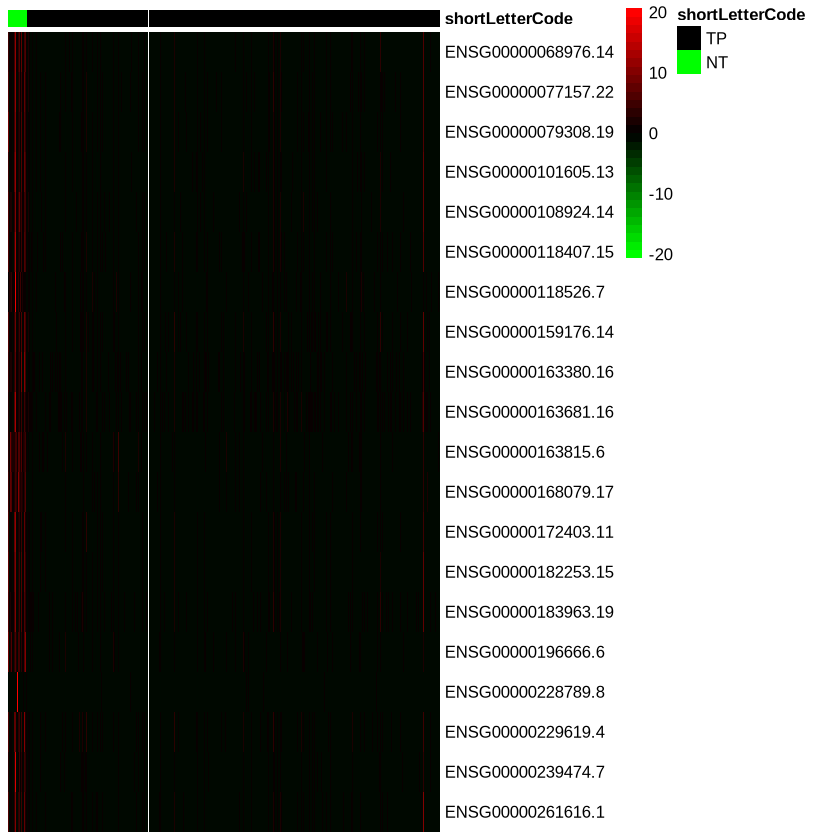

In [24]:
# Custom color schemes for annotations
annotation_colors <- list( shortLetterCode =c("TP" = "black", "NT" = "green"))

# Creating the heatmap
pheatmap(
  t(final_mat),  # Transpose data if necessary
  color = colorRampPalette(c("green", "black", "red"))(n = 30),
  scale = "row",
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  annotation_col = metadata,
  annotation_colors = annotation_colors,
  show_rownames = TRUE,
  show_colnames = FALSE,
  width = 1000,
  height = 500
)

## Volcano mRNA

### Change options because of error from labels 

In [41]:
options(ggrepel.max.overlaps = 20)

In [42]:
res<-TCGAVisualize_volcano(
    x = dataDEGs$logFC,
    y = dataDEGs$FDR,
    filename = "volcanoexp.png",
    names = rownames(dataDEGs),
    color = c("black","red","darkgreen"),
    names.size = 2,
    xlab = " Gene expression fold change (Log2)",
    legend = "State",
    title = "Volcano plot (TP vs NT)",
    width = 10,
    x.cut = 1
)

Saving file as: volcanoexp.png

Warning message:
“ggrepel: 4196 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


## PCA mRNA

In [ ]:
pca <- TCGAvisualize_PCA(
    dataFilt = data_matrix,
    dataDEGsFiltLevel = dataDEGsFiltLevel,
    ntopgenes = 200, 
    group1 = samples.primary.tumour,
    group2 =  samples.solid.tissue.normal
)

## Hist mRNA

In [31]:
# Find and print the maximum value of the matrix
max_value <- max(data_matrix)
max_value

# Flatten the matrix into a vector
mat_vector <- as.vector(data_matrix)

png(filename = "hist.png", width = 1200, height = 480,
    units = "px", pointsize = 12, bg = "white")

# Create a histogram
hist(mat_vector, main = "Histogram of Expression Values", xlab = "Values", col = "lightblue", border = "black", breaks=100)

dev.off()

[1] 319762.4

png 
  2

# miRNA


In [3]:
query.miRNA <- GDCquery(project = "TCGA-BLCA",experimental.strategy = "miRNA-Seq",data.category = "Transcriptome Profiling", 
    data.type = "miRNA Expression Quantification", access = "open")

samplesDown.miRNA <- getResults(query.miRNA,cols=c("cases"))

dataSmTP.miR <- TCGAquery_SampleTypes(barcode = samplesDown.miRNA,typesample = "TP")
dataSmNT.miR <- TCGAquery_SampleTypes(barcode = samplesDown.miRNA,typesample = "NT")

query.miRNA <- GDCquery(project = "TCGA-BLCA",experimental.strategy = "miRNA-Seq",data.category = "Transcriptome Profiling", 
    data.type = "miRNA Expression Quantification",barcode = c(dataSmTP.miR, dataSmNT.miR), access = "open")

GDCdownload(query = query.miRNA)

dataAssy.miR <- GDCprepare(query = query.miRNA)

rownames(dataAssy.miR) <- dataAssy.miR$miRNA_ID

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--------------------

ooo By access

ooo By experimental.strategy

ooo By data.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--

  |======================================================================| 100%


In [53]:
# saveRDS(dataAssy.miR, "downloaded_dataAssy_miR.rds")
# saveRDS(dataSmTP.miR, "dataSmTP._miR.rds")
# saveRDS(dataSmNT.miR, "dataSmNT_miRrds")

In [16]:
dataAssy.miR <- readRDS("downloaded_dataAssy_miR.rds")
# dataSmTP.miR <- readRDS("dataSmTP._miR.rds")
# dataSmNT.miR <- readRDS("dataSmNT_miRrds")

In [17]:
head(dataAssy.miR, 2)

,miRNA_ID,read_count_TCGA-DK-A2I2-01A-11R-A17X-13,reads_per_million_miRNA_mapped_TCGA-DK-A2I2-01A-11R-A17X-13,cross-mapped_TCGA-DK-A2I2-01A-11R-A17X-13,read_count_TCGA-E7-A6MF-01A-12R-A32J-13,reads_per_million_miRNA_mapped_TCGA-E7-A6MF-01A-12R-A32J-13,cross-mapped_TCGA-E7-A6MF-01A-12R-A32J-13,read_count_TCGA-DK-A3IV-01A-22R-A21E-13,reads_per_million_miRNA_mapped_TCGA-DK-A3IV-01A-22R-A21E-13,cross-mapped_TCGA-DK-A3IV-01A-22R-A21E-13,⋯,cross-mapped_TCGA-K4-A54R-11A-11R-A26X-13,read_count_TCGA-GD-A2C5-11A-11R-A17X-13,reads_per_million_miRNA_mapped_TCGA-GD-A2C5-11A-11R-A17X-13,cross-mapped_TCGA-GD-A2C5-11A-11R-A17X-13,read_count_TCGA-CU-A0YN-11A-11R-A10V-13,reads_per_million_miRNA_mapped_TCGA-CU-A0YN-11A-11R-A10V-13,cross-mapped_TCGA-CU-A0YN-11A-11R-A10V-13,read_count_TCGA-BT-A20Q-11A-11R-A14X-13,reads_per_million_miRNA_mapped_TCGA-BT-A20Q-11A-11R-A14X-13,cross-mapped_TCGA-BT-A20Q-11A-11R-A14X-13
,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,⋯,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<chr>
hsa-let-7a-1,hsa-let-7a-1,18587,4227.118,N,44934,25109.46,N,69295,9249.861,N,⋯,N,102603,10270.60,N,25562,4260.987,N,21645,1261.238,N
hsa-let-7a-2,hsa-let-7a-2,18617,4233.940,N,45179,25246.36,N,68297,9116.643,Y,⋯,N,101773,10187.51,Y,26018,4336.998,Y,21638,1260.830,Y


## Take columns that start with "read_count_" (for raw data) and create matrix

In [18]:
read_countData <-  colnames(dataAssy.miR)[grep("read_count_", colnames(dataAssy.miR))]

data_matrix_miR <- dataAssy.miR[,read_countData]

colnames(data_matrix_miR) <- gsub("read_count_","", colnames(data_matrix_miR))

head(data_matrix_miR, 2)

,TCGA-DK-A2I2-01A-11R-A17X-13,TCGA-E7-A6MF-01A-12R-A32J-13,TCGA-DK-A3IV-01A-22R-A21E-13,TCGA-FD-A6TA-01A-12R-A33A-13,TCGA-FD-A62S-01A-11R-A30J-13,TCGA-BT-A20T-01A-11R-A14X-13,TCGA-UY-A78M-01A-21R-A358-13,TCGA-DK-AA6L-01A-11R-A39B-13,TCGA-FD-A5BT-01A-11R-A26X-13,TCGA-KQ-A41S-01A-12R-A33A-13,⋯,TCGA-BT-A2LB-11A-11R-A18B-13,TCGA-GC-A3WC-11A-11R-A22V-13,TCGA-BL-A13J-11A-13R-A10V-13,TCGA-CU-A0YR-11A-13R-A10V-13,TCGA-BT-A2LA-11A-11R-A18B-13,TCGA-BT-A20U-11A-11R-A14X-13,TCGA-K4-A54R-11A-11R-A26X-13,TCGA-GD-A2C5-11A-11R-A17X-13,TCGA-CU-A0YN-11A-11R-A10V-13,TCGA-BT-A20Q-11A-11R-A14X-13
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
hsa-let-7a-1,18587,44934,69295,33473,41076,38391,18145,63904,41545,41340,⋯,57605,39790,51229,29017,86514,8503,36292,102603,25562,21645
hsa-let-7a-2,18617,45179,68297,33315,41241,38219,18167,63826,41446,41514,⋯,57248,39588,51276,28944,86180,8286,35489,101773,26018,21638


In [257]:
saveRDS(data_matrix_miR,"raw_data_matrix_miR.rds")

## DESeq2 for MOFA

In [258]:
miRcolData <- rep(NA, length(colnames(data_matrix_miR)))
miRcolData[which(colnames(data_matrix_miR) %in% dataSmTP.miR)] <- "TP"
miRcolData[which(colnames(data_matrix_miR) %in% dataSmNT.miR)] <- "NT"
miRcolData <- data.frame(shortLetterCode = miRcolData)
rownames(miRcolData) <- colnames(data_matrix_miR)
head(miRcolData, 2)

,shortLetterCode
,<chr>
TCGA-DK-A2I2-01A-11R-A17X-13,TP
TCGA-E7-A6MF-01A-12R-A32J-13,TP


In [259]:
# Create a DESeqDataSet object
miRdds <- DESeqDataSetFromMatrix(countData = data_matrix_miR,
                              colData = miRcolData,
                              design = ~ shortLetterCode)

# Estimate size factors
miRdds <- estimateSizeFactors(miRdds)

miRvst <- varianceStabilizingTransformation(miRdds, blind = FALSE)

# Extract the normalized counts
normalized_counts_miR <- assay(miRvst)

head(normalized_counts_miR, 2)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


,TCGA-DK-A2I2-01A-11R-A17X-13,TCGA-E7-A6MF-01A-12R-A32J-13,TCGA-DK-A3IV-01A-22R-A21E-13,TCGA-FD-A6TA-01A-12R-A33A-13,TCGA-FD-A62S-01A-11R-A30J-13,TCGA-BT-A20T-01A-11R-A14X-13,TCGA-UY-A78M-01A-21R-A358-13,TCGA-DK-AA6L-01A-11R-A39B-13,TCGA-FD-A5BT-01A-11R-A26X-13,TCGA-KQ-A41S-01A-12R-A33A-13,⋯,TCGA-BT-A2LB-11A-11R-A18B-13,TCGA-GC-A3WC-11A-11R-A22V-13,TCGA-BL-A13J-11A-13R-A10V-13,TCGA-CU-A0YR-11A-13R-A10V-13,TCGA-BT-A2LA-11A-11R-A18B-13,TCGA-BT-A20U-11A-11R-A14X-13,TCGA-K4-A54R-11A-11R-A26X-13,TCGA-GD-A2C5-11A-11R-A17X-13,TCGA-CU-A0YN-11A-11R-A10V-13,TCGA-BT-A20Q-11A-11R-A14X-13
hsa-let-7a-1,14.15373,16.95934,15.18639,14.55119,14.63024,15.97608,14.88960,15.71214,14.50654,14.96509,⋯,15.60613,15.36820,16.41457,16.14623,15.97692,15.99141,15.13047,15.78532,15.94804,15.85062
hsa-let-7a-2,14.15606,16.96719,15.16547,14.54437,14.63603,15.96960,14.89135,15.71038,14.50309,14.97114,⋯,15.59716,15.36085,16.41590,16.14260,15.97134,15.95411,15.09819,15.77360,15.97354,15.85015


## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [ ]:
# # keep first 16 characters from colnames, which are sample ids
# sample_ids <- substr(colnames(data_matrix_miR), 0, 16)

# # find duplicated samples in colData(dataPrep)
# patient_duplicates <- sample_ids[which(duplicated(sample_ids))]

# # use function duplicates_index_to_remove for every element in patient_duplicates
# patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove, input_matrix = data_matrix_miR)

# print("Index of duplicates with the most zeros per patient with duplicates")
# patient_duplicates_to_remove

# print("The names of the columns that will be removed")
# colnames(data_matrix_miR)[patient_duplicates_to_remove]

In [17]:
# # Remove the specified-duplicated columns
# data_matrix_miR <- data_matrix_miR[, -patient_duplicates_to_remove, drop = FALSE]
# dim(data_matrix_miR)

[1] 1881  431

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [21]:
# TRUE if matrix contains any NAs/NaNs
any(is.na(data_matrix_miR))
any(is.nan(as.matrix(data_matrix_miR)))

# Get indices of non-numeric
which(is.na(as.numeric(as.matrix(data_matrix_miR))))

[1] FALSE

[1] FALSE

integer(0)

In [22]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(data_matrix_miR, 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 313

In [23]:
dim(data_matrix_miR)

[1] 1881  436

### A matrix in R can only hold one type of data, if first element is integer/double, then all the elements in this matrix are integers/doubles

In [24]:
typeof(data_matrix_miR[1,1])

[1] "integer"

## Take columns that start with "reads_per_million_miRNA" (for normalized data) and create matrix

In [42]:
read_countData <-  colnames(dataAssy.miR)[grep("reads_per_million_miRNA", colnames(dataAssy.miR))]

data_matrix_miR <- dataAssy.miR[,read_countData]

colnames(data_matrix_miR) <- gsub("reads_per_million_miRNA_mapped_","", colnames(data_matrix_miR))

head(data_matrix_miR, 2)

,TCGA-DK-A2I2-01A-11R-A17X-13,TCGA-E7-A6MF-01A-12R-A32J-13,TCGA-DK-A3IV-01A-22R-A21E-13,TCGA-FD-A6TA-01A-12R-A33A-13,TCGA-FD-A62S-01A-11R-A30J-13,TCGA-BT-A20T-01A-11R-A14X-13,TCGA-UY-A78M-01A-21R-A358-13,TCGA-DK-AA6L-01A-11R-A39B-13,TCGA-FD-A5BT-01A-11R-A26X-13,TCGA-KQ-A41S-01A-12R-A33A-13,⋯,TCGA-BT-A2LB-11A-11R-A18B-13,TCGA-GC-A3WC-11A-11R-A22V-13,TCGA-BL-A13J-11A-13R-A10V-13,TCGA-CU-A0YR-11A-13R-A10V-13,TCGA-BT-A2LA-11A-11R-A18B-13,TCGA-BT-A20U-11A-11R-A14X-13,TCGA-K4-A54R-11A-11R-A26X-13,TCGA-GD-A2C5-11A-11R-A17X-13,TCGA-CU-A0YN-11A-11R-A10V-13,TCGA-BT-A20Q-11A-11R-A14X-13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-let-7a-1,4227.118,25109.46,9249.861,5408.821,5888.805,11645.36,5980.638,9529.839,6661.821,5619.656,⋯,8035.191,4950.450,3714.047,4619.003,11074.03,5780.253,8489.891,10270.60,4260.987,1261.238
hsa-let-7a-2,4233.940,25246.36,9116.643,5383.290,5912.460,11593.18,5987.890,9518.207,6645.946,5643.309,⋯,7985.394,4925.318,3717.455,4607.383,11031.28,5632.738,8302.043,10187.51,4336.998,1260.830


## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [19]:
# keep first 16 characters from colnames, which are sample ids
sample_ids <- substr(colnames(data_matrix_miR), 0, 16)

# find duplicated samples in colData(dataPrep)
patient_duplicates <- sample_ids[which(duplicated(sample_ids))]

# use function duplicates_index_to_remove for every element in patient_duplicates
patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove, input_matrix = data_matrix_miR)

print("Index of duplicates with the most zeros per patient with duplicates")
patient_duplicates_to_remove

print("The names of the columns that will be removed")
colnames(data_matrix_miR)[patient_duplicates_to_remove]

TCGA-C4-A0F7-01A-11R-A25G-13 TCGA-C4-A0F7-01A-11R-A085-13 
                        1110                         1318 
TCGA-C4-A0F1-01A-11R-A25G-13 TCGA-C4-A0F1-01A-11R-A035-13 
                        1149                         1309 
TCGA-BL-A0C8-01A-11R-A10V-13 TCGA-BL-A0C8-01A-11R-A27D-13 
                        1215                         1179 
TCGA-BL-A13I-01A-11R-A27D-13 TCGA-BL-A13I-01A-11R-A13X-13 
                        1207                         1274 
TCGA-BL-A13J-01A-11R-A27D-13 TCGA-BL-A13J-01A-11R-A10V-13 
                        1141                         1172 
[1] "Index of duplicates with the most zeros per patient with duplicates"


TCGA-C4-A0F7-01A TCGA-C4-A0F1-01A TCGA-BL-A0C8-01A TCGA-BL-A13I-01A 
             132              148              130              264 
TCGA-BL-A13J-01A 
             375

[1] "The names of the columns that will be removed"


[1] "TCGA-C4-A0F7-01A-11R-A085-13" "TCGA-C4-A0F1-01A-11R-A035-13"
[3] "TCGA-BL-A0C8-01A-11R-A10V-13" "TCGA-BL-A13I-01A-11R-A13X-13"
[5] "TCGA-BL-A13J-01A-11R-A10V-13"

In [20]:
# Remove the specified-duplicated columns
data_matrix_miR <- data_matrix_miR[, -patient_duplicates_to_remove, drop = FALSE]
dim(data_matrix_miR)

[1] 1881  431

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [81]:
# TRUE if matrix contains any NAs/NaNs
any(is.na(data_matrix_miR))
any(is.nan(as.matrix(data_matrix_miR)))

# Get indices of non-numeric
which(is.na(as.numeric(as.matrix(data_matrix_miR))))

[1] FALSE

[1] FALSE

integer(0)

In [80]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(data_matrix_miR, 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 313

### A matrix in R can only hold one type of data, if first element is integer/double, then all the elements in this matrix are integers/doubles

In [70]:
typeof(data_matrix_miR[1,1])

[1] "double"

## Max value of a matrix

In [30]:
which(data_matrix_miR == max(data_matrix_miR), arr.ind = TRUE)
colnames(data_matrix_miR)[418]
data_matrix_miR[190,418]

,row,col
hsa-mir-143,190,418


## DEA

In [29]:
dataSmNT.miR <- grep("-11A-", colnames(data_matrix_miR))
dataSmTP.miR <- grep("-11A-", colnames(data_matrix_miR), invert = TRUE)

In [30]:
samples<-substr(colnames(data_matrix_miR), 1, 16)
samples[1]

[1] "TCGA-DK-A2I2-01A"

In [31]:
# check the states after removal of duplicates
unique(colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$sample %in% samples[dataSmTP.miR])])
length(colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$sample %in% samples[dataSmTP.miR])])

[1] "TP"

[1] 409

In [32]:
# check the states after removal of duplicates for samples that don't exist in dataPrep
# find and save the samples that don't exist in dataPrep
remainingSamples <- colData(dataPrep)$sample[which(!colData(dataPrep)$sample %in% samples)]

unique(colData(data_met)$shortLetterCode[which(colData(data_met)$sample %in% remainingSamples)])
length(colData(data_met)$shortLetterCode[which(colData(data_met)$sample %in% remainingSamples)])

[1] "TP"

[1] 3

In [33]:
# check the states after removal of duplicates
unique(colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$sample %in% samples[dataSmNT.miR])])
length(colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$sample %in% samples[dataSmNT.miR])])

[1] "NT"

[1] 19

In [34]:
dataDEGs.miR <- TCGAanalyze_DEA(mat1 = data_matrix_miR[,dataSmNT.miR],mat2 = data_matrix_miR[,dataSmTP.miR],Cond1type = "Normal",
    Cond2type = "Tumor",fdr.cut = 1, logFC.cut = 0,method = "glmLRT") 

dataDEGsFiltLevel.miR <- TCGAanalyze_LevelTab(FC_FDR_table_mRNA = dataDEGs.miR,typeCond1 = "Normal",typeCond2 = "Tumor",TableCond1 = data_matrix_miR[,dataSmNT.miR],
    TableCond2 = data_matrix_miR[,dataSmTP.miR])

Batch correction skipped since no factors provided

----------------------- DEA -------------------------------

o 19 samples in Cond1type Normal

o 412 samples in Cond2type Tumor

o 1881 features as miRNA or genes 

This may take some minutes...

----------------------- END DEA -------------------------------



In [35]:
dataDEGs.miR <- dataDEGs.miR[order(dataDEGs.miR$FDR),]
head(dataDEGs.miR)

,logFC,logCPM,LR,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-mir-21,2.220563,18.165299,125.23404,4.523251e-29,8.508235e-26
hsa-mir-671,2.704770,3.588835,90.40739,1.938410e-21,1.823075e-18
hsa-mir-210,5.558504,10.132822,82.31073,1.162892e-19,5.468499e-17
hsa-mir-96,4.300988,5.356699,82.36721,1.130131e-19,5.468499e-17
hsa-mir-143,-2.132307,17.232635,81.20112,2.038765e-19,7.669833e-17
hsa-mir-148b,1.838960,7.131147,80.36784,3.108123e-19,9.743966e-17


In [36]:
mirna_degs50 <- rownames(dataDEGs.miR)[1:50]
mirna_degs100 <- rownames(dataDEGs.miR)[1:100]
mirna_degs150 <- rownames(dataDEGs.miR)[1:150]
head(mirna_degs50)
head(mirna_degs100)
head(mirna_degs150)

[1] "hsa-mir-21"   "hsa-mir-671"  "hsa-mir-210"  "hsa-mir-96"   "hsa-mir-143" 
[6] "hsa-mir-148b"

[1] "hsa-mir-21"   "hsa-mir-671"  "hsa-mir-210"  "hsa-mir-96"   "hsa-mir-143" 
[6] "hsa-mir-148b"

[1] "hsa-mir-21"   "hsa-mir-671"  "hsa-mir-210"  "hsa-mir-96"   "hsa-mir-143" 
[6] "hsa-mir-148b"

## Changed first column to miRNA, but maybe TCGAanalyze_LevelTab is only for mRNA (FC_FDR_table_mRNA)

In [59]:
dataDEGsFiltLevel.miR <- TCGAanalyze_LevelTab(FC_FDR_table_mRNA = dataDEGs.miR,typeCond1 = "Tumor",typeCond2 = "Normal",TableCond1 = data_matrix_miR[,dataSmTP.miR],
    TableCond2 = data_matrix_miR[,dataSmNT.miR])

colnames(dataDEGsFiltLevel.miR)[1] <- "miRNA"

head(dataDEGsFiltLevel.miR)

,miRNA,logFC,FDR,Delta,Tumor,Normal
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-mir-21,hsa-mir-21,2.216279,6.710475e-26,672882.66,303609.24,65335.314
hsa-mir-182,hsa-mir-182,2.830011,1.867410e-11,73838.71,26091.32,3669.148
hsa-mir-203a,hsa-mir-203a,1.987820,3.825456e-03,65968.12,33186.16,8366.787
hsa-mir-183,hsa-mir-183,3.575300,2.108294e-14,52980.80,14818.56,1243.064
hsa-mir-200c,hsa-mir-200c,2.017406,2.092149e-06,35751.15,17721.34,4377.110
hsa-mir-205,hsa-mir-205,2.650162,1.723964e-06,28852.65,10887.13,1734.238


## PCA miRNA

Warning message:
“In prcomp.default(t(expr2), cor = TRUE) :
 extra argument ‘cor’ will be disregarded”
Warning message:
“Removed 25 rows containing missing values (`geom_text()`).”


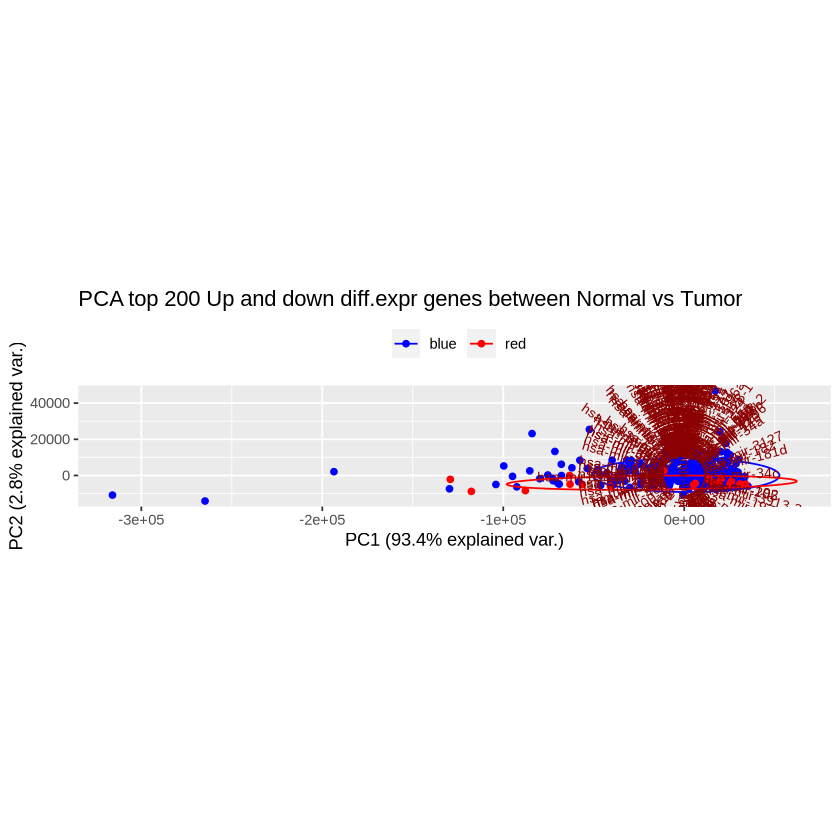

In [10]:
pca <- TCGAvisualize_PCA(
    dataFilt = data_matrix_miR,
    dataDEGsFiltLevel = dataDEGsFiltLevel.miR,
    ntopgenes = 200, 
    group1 = dataSmTP.miR,
    group2 = dataSmNT.miR
)

## Hist miRNA

In [37]:
# Find and print the maximum value of the matrix
max_value <- max(data_matrix_miR)
max_value
# Assuming df is your dataframe
# You can use the unlist function to convert the dataframe to a vector
data_vector <- unlist(data_matrix_miR)

png(filename = "hist_miRNA.png", width = 1200, height = 480,
    units = "px", pointsize = 12, bg = "white")

# Create a histogram
hist(data_vector, main = "Histogram of All Columns", xlab = "Values", col = "lightblue", border = "black", breaks=100)

dev.off()

[1] 937080.8

png 
  2

# Methylation


In [81]:
query_met <- GDCquery(
    project = "TCGA-BLCA", 
    data.category = "DNA Methylation", 
    data.type = "Methylation Beta Value",
    platform = "Illumina Human Methylation 450", 
    access = "open"
)

samplesDown_met <- getResults(query_met,cols=c("cases"))

# return barcodes that are TP
dataSmTP_met <- TCGAquery_SampleTypes(barcode = samplesDown_met,typesample = "TP")
# return barcodes that are NT
dataSmNT_met <- TCGAquery_SampleTypes(barcode = samplesDown_met,typesample = "NT")

query_met <- GDCquery(
    project = "TCGA-BLCA", 
    data.category = "DNA Methylation", 
    data.type = "Methylation Beta Value",
    platform = "Illumina Human Methylation 450", 
    access = "open",
    barcode = c(dataSmTP_met, dataSmNT_met)
)

GDCdownload(query = query_met)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--------------------

ooo By platform

ooo By access

ooo By data.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

---------------

Downloading: 390 MB     

Downloading: 390 MB     

Downloading: 390 MB     

Downloading: 400 MB     

Downloading: 390 MB     

Downloading: 310 MB     

In [82]:
saveRDS(query_met, "query_met.rds")

In [4]:
query_met <- readRDS("query_met.rds")

In [ ]:
data_met <- GDCprepare(query_met)
# saveRDS(data_met, "downloaded_data_met.rds")
# saveRDS(dataSmTP_met,"dataSmTP_met.rds")
# saveRDS(dataSmNT_met,"dataSmNT_met.rds")

In [37]:
data_met <- readRDS("downloaded_data_met.rds")
# dataSmTP_met <- readRDS("dataSmTP_met.rds")
# dataSmNT_met <- readRDS("dataSmNT_met.rds")
data_met

class: RangedSummarizedExperiment 
dim: 485577 439 
metadata(1): data_release
assays(1): ''
rownames(485577): cg13869341 cg14008030 ... cg11478607 cg08417382
rowData names(52): address_A address_B ... MASK_extBase MASK_general
colnames(439): TCGA-FD-A3NA-01A-11D-A21B-05
  TCGA-E7-A6MF-01A-12D-A32C-05 ... TCGA-BL-A13J-11A-13D-A10W-05
  TCGA-GD-A3OQ-11A-21D-A223-05
colData names(238): barcode patient ... paper_Fusion in TNFRSF21
  paper_Fusion in ASIP

In [38]:
dim(assay(data_met))
head(assay(data_met), 1)

[1] 485577    439

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
cg13869341,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [74]:
meth_matrix <- assay(data_met)
head(meth_matrix, 1)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
cg13869341,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Convertion to M-values for MOFA

In [260]:
meth_mat_mean <- readRDS("meth_mat_mean_with_na.rds")

m_values <- log2(meth_mat_mean / (1 - meth_mat_mean))

dim(m_values)
head(m_values, 2)

[1] 37930   439

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
ENSG00000000003,-1.6731590,-2.496407,-1.5537959,-1.7752266,-2.147910,-1.750815,-1.832955,-2.2118050,-0.8630033,-1.419756,⋯,-1.399898,-0.6412204,-0.7384546,-1.16531,-0.4496351,-0.530620,-1.548875,-0.8266681,-1.123247,-1.597692
ENSG00000000005,0.6200819,1.397996,0.3556771,-0.0869612,2.279113,1.443138,3.583669,0.9985654,-0.1273481,1.161536,⋯,2.899890,1.3499670,1.8978214,2.90263,2.2700290,1.574616,3.031188,1.6356497,3.253244,3.363951


In [261]:
# Create a logical matrix indicating where NAs or NaNs are present
is_na_nan <- is.na(m_values) | is.nan(m_values)

# Summarize each row to check if all elements are NA or NaN
all_na_nan_rows <- apply(is_na_nan, 1, all)

# Identify row indices where all elements are TRUE
rows_with_only_na_nan <- which(all_na_nan_rows)

m_values <- m_values[!all_na_nan_rows, ]

## Remove patient duplicate with the most zeros in the column, for every patient with duplicates

In [45]:
duplicates_index_to_remove_for_methylation <- function(patient,input_matrix) {
  # for every element in patient search colnames that start with this sample id, whih are from duplicated samples 
  duplicated_columns <- colnames(input_matrix)[grep(patient, colnames(input_matrix))]
  
  # Count the number of NA values in each specified column
  na_counts <- colSums(is.na(input_matrix[, duplicated_columns]))
  print(na_counts)

  # find which column for every duplicated sample has more zeros
  index_of_larger_number <- which.max(na_counts)

  # Find the index from the matrix, of the column with more zeros to remove
  column_index_to_remove <- which(colnames(input_matrix) %in% duplicated_columns[index_of_larger_number])

  return (column_index_to_remove)
}

In [46]:
# find duplicated samples in colData(dataPrep)
patient_duplicates <- colData(data_met)$sample[which(duplicated(colData(data_met)$sample))]

# use function duplicates_index_to_remove for every element in patient_duplicates
patient_duplicates_to_remove <- sapply(patient_duplicates, duplicates_index_to_remove_for_methylation, input_matrix = meth_matrix)

print("Index of duplicates with the most zeros per patient with duplicates")
patient_duplicates_to_remove

print("The names of the columns that will be removed")
colnames(meth_matrix)[patient_duplicates_to_remove]

TCGA-BL-A13I-01A-11D-A13Z-05 TCGA-BL-A13I-01A-11D-A276-05 
                       70003                        78309 
TCGA-BL-A0C8-01A-11D-A276-05 TCGA-BL-A0C8-01A-11D-A10W-05 
                       77030                        93139 
TCGA-BL-A13J-01A-11D-A10W-05 TCGA-BL-A13J-01A-11D-A276-05 
                       77227                        81411 
[1] "Index of duplicates with the most zeros per patient with duplicates"


TCGA-BL-A13I-01A TCGA-BL-A0C8-01A TCGA-BL-A13J-01A 
             300              345              398

[1] "The names of the columns that will be removed"


[1] "TCGA-BL-A13I-01A-11D-A276-05" "TCGA-BL-A0C8-01A-11D-A10W-05"
[3] "TCGA-BL-A13J-01A-11D-A276-05"

In [47]:
# Remove the specified-duplicated columns
meth_matrix <- meth_matrix[, -patient_duplicates_to_remove, drop = FALSE]
dim(meth_matrix)

[1] 485577    436

In [48]:
saveRDS(meth_matrix, "processed_meth_matrix.rds")

## Check for rows that have only 0 or NA/NaN, there isn't None in R, instead of this is NULL, but rows with NULL can't appear in matrix

In [83]:
is_all_zeros_or_na <- function(value) {all(value == 0 | is.na(value))}

# Checking for rows where all elements are zeros
rows_with_all_zeros <- apply(assay(data_met), 1, is_all_zeros_or_na)

# Counting the number of columns with all zeros
num_columns_with_all_zeros <- sum(rows_with_all_zeros)

num_columns_with_all_zeros

[1] 64220

### A matrix in R can only hold one type of data, if first element is integer/double, then all the elements in this matrix are integers/doubles

In [25]:
typeof(assay(data_met)[1,1])

[1] "double"

## Remove the rows that have at least one NA

In [62]:
# na.omit
# data_met <- data_met[rowSums(is.na(assay(data_met))) == 0,]
# head(assay(data_met))

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
cg16619049,0.3756185,0.03666365,0.4997181,0.2023811,0.3520077,0.3108895,0.2993181,0.2349854,0.2127136,0.4577936,⋯,0.4038090,0.4894903,0.4352221,0.4644328,0.4522823,0.3883846,0.3454956,0.4294653,0.3881193,0.3837940
cg18147296,0.6587823,0.75214447,0.7269647,0.6757211,0.6300320,0.5469870,0.8340163,0.6970405,0.6927025,0.7092280,⋯,0.6744512,0.6361787,0.6522986,0.6125903,0.6445321,0.5559067,0.5434577,0.6293830,0.5565833,0.6541837
cg13938959,0.4730780,0.91998643,0.4880943,0.4145957,0.6354954,0.3862603,0.4176617,0.5102106,0.3306258,0.6812871,⋯,0.7340995,0.7816124,0.7907097,0.7685573,0.8704710,0.7944413,0.8729773,0.5421802,0.8290652,0.8006693
cg12445832,0.2910751,0.88852353,0.3300772,0.2093543,0.3620125,0.2583255,0.2360047,0.2946073,0.2390897,0.4281056,⋯,0.5190293,0.5062436,0.6467032,0.5405029,0.7525516,0.5865062,0.6265222,0.4008233,0.6150903,0.6264947
cg23999112,0.5600379,0.89377422,0.4990788,0.5443186,0.8551309,0.4092382,0.4892752,0.4753013,0.3533445,0.6960211,⋯,0.8633101,0.8123911,0.8906572,0.8954997,0.9194234,0.9157894,0.9187857,0.6748022,0.9166921,0.8302839
cg11527153,0.7307246,0.52660896,0.7823555,0.5567775,0.5710294,0.4140516,0.6276143,0.6893751,0.6281392,0.8491099,⋯,0.8524084,0.7904111,0.8995841,0.8998211,0.8944471,0.9118951,0.8879874,0.6809255,0.8821675,0.8974090


## DMC (p.cut = 10^-5 from tutorial, 0.01 and 0.2 are defaults)

In [39]:
meth_mat_mean <- readRDS("processed_meth_mat_mean_with_na.rds")
head(meth_mat_mean)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
ENSG00000000419,0.1178325,0.1234904,0.1074870,0.1131896,0.1210688,0.1209866,0.1081228,0.1165495,0.1198469,0.1083114,⋯,0.1283536,0.1279853,0.1322744,0.1328414,0.1118885,0.1289726,0.1308155,0.1161732,0.1299091,0.1082305
ENSG00000000457,0.2670827,0.2168660,0.2770998,0.2431043,0.2516276,0.2287701,0.2518552,0.2284875,0.2557735,0.2775308,⋯,0.2772068,0.2743403,0.2659583,0.2732396,0.2737861,0.2705068,0.2681463,0.2741836,0.2584690,0.2666568
ENSG00000000460,0.4436307,0.3737125,0.4417753,0.3872603,0.3896061,0.3454119,0.4138059,0.2615974,0.3971209,0.4005870,⋯,0.4519261,0.3996746,0.4449273,0.4474967,0.4534179,0.4513251,0.4400299,0.4234064,0.4144037,0.4409280
ENSG00000000938,0.5438053,0.4496814,0.5568034,0.6666494,0.5146676,0.4753789,0.5400387,0.5367315,0.5435034,0.5757990,⋯,0.5679367,0.5774811,0.5839556,0.5459100,0.6185687,0.5658374,0.5650642,0.5350111,0.5637159,0.5888963
ENSG00000000971,0.6216070,0.6661692,0.9006889,0.9097789,0.6608042,0.7458700,0.8074217,0.8506302,0.8727606,0.8675989,⋯,0.7717404,0.8997663,0.7740093,0.8193182,0.7805154,0.8468994,0.8901277,0.7498218,0.9070394,0.7607745
ENSG00000001036,0.3544977,0.3657452,0.3613011,0.3648329,0.3475062,0.3139948,0.3520011,0.3125920,0.3670936,0.3553785,⋯,0.3569708,0.3554612,0.3506902,0.3503416,0.3503033,0.3441136,0.3354080,0.3554639,0.3420196,0.3440526


In [40]:
# Function to calculate the percentage of NAs per row
na_percentage_per_row <- function(mat) {
  apply(mat, 1, function(row) {
    na_count <- sum(is.na(row))
    total_count <- length(row)
    percentage_na <- (na_count / total_count) * 100
    return(percentage_na)
  })
}

# Calculate the percentage of NAs per row
na_percentages <- na_percentage_per_row(meth_mat_mean)

In [41]:
length(na_percentages[na_percentages>10])
dim(meth_mat_mean)
meth_mat_mean <- meth_mat_mean[na_percentages<=10, ]
dim(meth_mat_mean)

[1] 2103

[1] 34925   436

[1] 32822   436

In [42]:
imputed_matrix <- impute.knn(meth_mat_mean,k = 5, rowmax = 0.6, maxp = dim(meth_mat_mean)[1])$data
any(is.na(imputed_matrix))

[1] FALSE

In [43]:
dim(meth_mat_mean)[1]

[1] 32822

In [44]:
chromosomes <- rep(c("chr1"), length.out = dim(meth_mat_mean)[1])

# Create GRanges with dummy ranges
gr <- GRanges(seqnames = Rle(chromosomes),
              ranges = IRanges(start = rep(1, length(chromosomes)), width = 1))

# Print the GRanges object
gr

GRanges object with 32822 ranges and 0 metadata columns:
          seqnames    ranges strand
             <Rle> <IRanges>  <Rle>
      [1]     chr1         1      *
      [2]     chr1         1      *
      [3]     chr1         1      *
      [4]     chr1         1      *
      [5]     chr1         1      *
      ...      ...       ...    ...
  [32818]     chr1         1      *
  [32819]     chr1         1      *
  [32820]     chr1         1      *
  [32821]     chr1         1      *
  [32822]     chr1         1      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

In [45]:
data_met <- data_met[, colnames(imputed_matrix)]
data_met

class: RangedSummarizedExperiment 
dim: 485577 436 
metadata(1): data_release
assays(1): ''
rownames(485577): cg13869341 cg14008030 ... cg11478607 cg08417382
rowData names(52): address_A address_B ... MASK_extBase MASK_general
colnames(436): TCGA-FD-A3NA-01A-11D-A21B-05
  TCGA-E7-A6MF-01A-12D-A32C-05 ... TCGA-BL-A13J-11A-13D-A10W-05
  TCGA-GD-A3OQ-11A-21D-A223-05
colData names(238): barcode patient ... paper_Fusion in TNFRSF21
  paper_Fusion in ASIP

In [46]:
identical(colnames(imputed_matrix), colnames(data_met))
identical(colnames(imputed_matrix), colData(data_met)$barcode)

unique(colData(data_met)$shortLetterCode[grep("-11A-", colData(data_met)$barcode)])
unique(colData(data_met)$shortLetterCode[grep("-11A-", colData(data_met)$barcode, invert=TRUE)])

[1] TRUE

[1] TRUE

[1] "NT"

[1] "TP"

In [47]:
metadata <- colData(data_met)[which(colData(data_met)$barcode %in% colnames(meth_mat_mean)), c("sample","barcode","shortLetterCode")]

se <- SummarizedExperiment(assays = meth_mat_mean, colData = metadata)
# colnames(colData(se))[1] <- "shortLetterCode"
# Assign GRanges to rowRanges
rowRanges(se) <- gr
rownames(se) <- rownames(meth_mat_mean)

In [48]:
se

class: RangedSummarizedExperiment 
dim: 32822 436 
metadata(0):
assays(1): ''
rownames(32822): ENSG00000000419 ENSG00000000457 ... ENSG00000288674
  ENSG00000288675
rowData names(0):
colnames(436): TCGA-FD-A3NA-01A-11D-A21B-05
  TCGA-E7-A6MF-01A-12D-A32C-05 ... TCGA-BL-A13J-11A-13D-A10W-05
  TCGA-GD-A3OQ-11A-21D-A223-05
colData names(3): sample barcode shortLetterCode

In [49]:
unique(colData(data_met)$shortLetterCode[which(colData(data_met)$barcode  %in% colData(se)$barcode [which(colData(se)$shortLetterCode == "NT")], "shortLetterCode")])
length(colData(data_met)$shortLetterCode[which(colData(data_met)$barcode  %in% colData(se)$barcode [which(colData(se)$shortLetterCode == "NT")], "shortLetterCode")])

[1] "NT"

[1] 21

In [50]:
unique(colData(data_met)$shortLetterCode[which(colData(data_met)$barcode  %in% colData(se)$barcode [which(colData(se)$shortLetterCode == "TP")], "shortLetterCode")])
length(colData(data_met)$shortLetterCode[which(colData(data_met)$barcode  %in% colData(se)$barcode [which(colData(se)$shortLetterCode == "TP")], "shortLetterCode")])

[1] "TP"

[1] 415

In [51]:
data <- TCGAanalyze_DMC(
    data = se, 
    groupCol = "shortLetterCode",
    group1 = "TP",
    group2 = "NT",
    p.cut = 0.01,
    diffmean.cut = 0.2,
    legend = "State",
    plot.filename = "seTP_vs_NT_volcanoMeth.pdf"
)

saveRDS(data,"sedmc_data_new.rds")

Group1:TP

Group2:NT

Calculating the p-values of each probe...



|====================================================|100%                      gCompleted after 2 m 


Saving volcano plot as: seTP_vs_NT_volcanoMeth.pdf

Saving file as: seTP_vs_NT_volcanoMeth.pdf

Saving the results also in a csv file: ./DMR_results_shortLetterCode_TP_NT_pcut_0.01_meancut_0.2.csv



In [24]:
data<-readRDS("sedmc_data_new.rds")

In [52]:
data <- data[order(data$p.value.adj.TP.NT	),]
head(data) 

,mean.TP,mean.NT,mean.TP.minus.mean.NT,p.value.TP.NT,p.value.adj.TP.NT,status
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000013523,0.3592515,0.4380690,-0.07881750,2.081154e-13,9.080048e-11,Not Significant
ENSG00000060558,0.5125488,0.6211273,-0.10857842,3.438023e-13,9.080048e-11,Not Significant
ENSG00000069943,0.2116262,0.3034490,-0.09182273,2.137109e-13,9.080048e-11,Not Significant
ENSG00000070950,0.4554807,0.5086635,-0.05318284,2.859021e-13,9.080048e-11,Not Significant
ENSG00000078295,0.4352796,0.6733589,-0.23807932,4.709719e-13,9.080048e-11,Hypomethylated in TP
ENSG00000086288,0.6006834,0.8660188,-0.26533542,1.271071e-13,9.080048e-11,Hypomethylated in TP


In [53]:
meth_degs50 <- rownames(data)[1:50]
meth_degs100 <- rownames(data)[1:100]
meth_degs150 <- rownames(data)[1:150]
head(meth_degs50)
head(meth_degs100)
head(meth_degs150)

[1] "ENSG00000013523" "ENSG00000060558" "ENSG00000069943" "ENSG00000070950"
[5] "ENSG00000078295" "ENSG00000086288"

[1] "ENSG00000013523" "ENSG00000060558" "ENSG00000069943" "ENSG00000070950"
[5] "ENSG00000078295" "ENSG00000086288"

[1] "ENSG00000013523" "ENSG00000060558" "ENSG00000069943" "ENSG00000070950"
[5] "ENSG00000078295" "ENSG00000086288"

In [54]:
degs50 <- c(mrna_degs50, mirna_degs50, meth_degs50)
degs100 <- c(mrna_degs100, mirna_degs100, meth_degs100)
degs150 <- c(mrna_degs150, mirna_degs150, meth_degs150)
degs50

[1] "ENSG00000163815.6"  "ENSG00000101605.13" "ENSG00000239474.7" 
  [4] "ENSG00000163380.16" "ENSG00000068976.14" "ENSG00000183963.19"
  [7] "ENSG00000159176.14" "ENSG00000228789.8"  "ENSG00000077157.22"
 [10] "ENSG00000196666.6"  "ENSG00000182253.15" "ENSG00000079308.19"
 [13] "ENSG00000229619.4"  "ENSG00000108924.14" "ENSG00000172403.11"
 [16] "ENSG00000118407.15" "ENSG00000118526.7"  "ENSG00000168079.17"
 [19] "ENSG00000065325.13" "ENSG00000163681.16" "ENSG00000261616.1" 
 [22] "ENSG00000144655.15" "ENSG00000158445.10" "ENSG00000181856.15"
 [25] "ENSG00000112425.16" "ENSG00000123358.20" "ENSG00000065534.19"
 [28] "ENSG00000165410.15" "ENSG00000128591.16" "ENSG00000140416.23"
 [31] "ENSG00000135842.17" "ENSG00000187942.12" "ENSG00000115556.14"
 [34] "ENSG00000141052.18" "ENSG00000091436.17" "ENSG00000126218.12"
 [37] "ENSG00000148339.12" "ENSG00000197361.8"  "ENSG00000075073.15"
 [40] "ENSG00000133392.18" "ENSG00000168309.18" "ENSG00000121577.14"
 [43] "ENSG00000117600.12" "ENSG00000168477.19" "ENSG00000106034.18"
 [46] "ENSG00000259370.2"  "ENSG00000267505.1"  "ENSG00000153531.13"
 [49] "ENSG00000197766.8"  "ENSG00000095637.22" "hsa-mir-21"        
 [52] "hsa-mir-671"        "hsa-mir-210"        "hsa-mir-96"        
 [55] "hsa-mir-143"        "hsa-mir-148b"       "hsa-mir-1298"      
 [58] "hsa-mir-17"         "hsa-mir-1307"       "hsa-mir-18a"       
 [61] "hsa-mir-185"        "hsa-mir-130b"       "hsa-mir-7705"      
 [64] "hsa-mir-1-2"        "hsa-mir-590"        "hsa-mir-183"       
 [67] "hsa-mir-3613"       "hsa-mir-454"        "hsa-mir-19a"       
 [70] "hsa-mir-301b"       "hsa-mir-93"         "hsa-mir-1-1"       
 [73] "hsa-mir-301a"       "hsa-mir-20a"        "hsa-mir-139"       
 [76] "hsa-mir-133a-1"     "hsa-mir-33a"        "hsa-mir-425"       
 [79] "hsa-mir-503"        "hsa-mir-106b"       "hsa-mir-133a-2"    
 [82] "hsa-mir-19b-2"      "hsa-mir-19b-1"      "hsa-mir-345"       
 [85] "hsa-mir-576"        "hsa-mir-877"        "hsa-mir-92a-2"     
 [88] "hsa-mir-92a-1"      "hsa-mir-331"        "hsa-mir-1277"      
 [91] "hsa-mir-940"        "hsa-mir-937"        "hsa-mir-141"       
 [94] "hsa-mir-1912"       "hsa-mir-182"        "hsa-mir-1301"      
 [97] "hsa-mir-188"        "hsa-mir-133b"       "hsa-mir-651"       
[100] "hsa-mir-191"        "ENSG00000013523"    "ENSG00000060558"   
[103] "ENSG00000069943"    "ENSG00000070950"    "ENSG00000078295"   
[106] "ENSG00000086288"    "ENSG00000099330"    "ENSG00000102699"   
[109] "ENSG00000104808"    "ENSG00000105352"    "ENSG00000106648"   
[112] "ENSG00000108700"    "ENSG00000108848"    "ENSG00000110484"   
[115] "ENSG00000113387"    "ENSG00000114487"    "ENSG00000115386"   
[118] "ENSG00000115425"    "ENSG00000115484"    "ENSG00000118242"   
[121] "ENSG00000119899"    "ENSG00000120341"    "ENSG00000122133"   
[124] "ENSG00000122507"    "ENSG00000124608"    "ENSG00000126262"   
[127] "ENSG00000131068"    "ENSG00000131808"    "ENSG00000132693"   
[130] "ENSG00000132703"    "ENSG00000132744"    "ENSG00000132911"   
[133] "ENSG00000133835"    "ENSG00000138160"    "ENSG00000138363"   
[136] "ENSG00000140093"    "ENSG00000143546"    "ENSG00000146221"   
[139] "ENSG00000146904"    "ENSG00000147676"    "ENSG00000150459"   
[142] "ENSG00000151090"    "ENSG00000151577"    "ENSG00000152611"   
[145] "ENSG00000155087"    "ENSG00000162779"    "ENSG00000162783"   
[148] "ENSG00000163534"    "ENSG00000163563"    "ENSG00000163636"

In [55]:
length(degs50)
length(degs100)
length(degs150)

[1] 150

[1] 300

[1] 450

In [56]:
write.csv(degs50,file="DEGs50.csv",row.names=F)
write.csv(degs100,file="DEGs100.csv",row.names=F)
write.csv(degs150,file="DEGs150.csv",row.names=F)

In [ ]:
# data <- TCGAanalyze_DMC(
#     data = data_met, 
#     groupCol = "shortLetterCode",
#     group1 = "TP",
#     group2 = "NT",
#     p.cut = 0.01,
#     diffmean.cut = 0.2,
#     legend = "State",
#     plot.filename = "TP_vs_NT_volcanoMeth.pdf"
# )

# saveRDS(data,"dmc_data_new.rds")

In [76]:
# data <- readRDS("dmc_data_new.rds")

In [30]:
# Get content into a data frame
# data <- read.csv("DMR_results_shortLetterCode_TP_NT_pcut_1e-05_meancut_0.25.csv", header = TRUE)

In [77]:
head(data)

,mean.TP,mean.NT,mean.TP.minus.mean.NT,p.value.TP.NT,p.value.adj.TP.NT,status
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
cg16619049,0.3050122,0.4284076,-0.12339541,5.958731e-05,2.176044e-04,Not Significant
cg18147296,0.6752837,0.6369843,0.03829937,1.162804e-02,2.238072e-02,Not Significant
cg13938959,0.5108953,0.7744803,-0.26358494,3.742539e-09,4.562984e-08,Hypomethylated in TP
cg12445832,0.3073540,0.5808143,-0.27346027,9.698621e-11,2.590277e-09,Hypomethylated in TP
cg23999112,0.5795147,0.8530734,-0.27355870,4.630471e-09,5.452269e-08,Hypomethylated in TP
cg11527153,0.6718636,0.8591173,-0.18725372,1.368352e-07,9.916008e-07,Not Significant


In [80]:
# mapping_data <- readRDS("mapping_data_102_with_na_features.rds")
# head(mapping_data)
# df50 <- data.frame(probeIDS = meth_degs50)
# df100 <- data.frame(probeIDS = meth_degs100)
# df150 <- data.frame(probeIDS = meth_degs150)
# head(df50)

probeID,transcriptIDs,ensembl_ids
<chr>,<chr>,<chr>
cg13869341,ENST00000488147.1,ENSG00000227232
cg24669183,ENST00000357876.6,ENSG00000230021
cg24669183,ENST00000419394.2,ENSG00000230021
cg24669183,ENST00000440196.3,ENSG00000230021
cg24669183,ENST00000634337.2,ENSG00000230021
cg24669183,ENST00000634833.2,ENSG00000230021


,probeIDS
,<chr>
1,cg12663811
2,cg05948763
3,cg24579224
4,cg01520454
5,cg00492341
6,cg03976856


In [82]:
# df50$ensembl_ids <- apply(as.matrix(df50$probeIDS),1, function (x){mapping_data$ensembl_ids[which(mapping_data$probeID %in% x)]})
# head(df50)
# df100$ensembl_ids <- apply(as.matrix(df100$probeIDS),1, function (x){mapping_data$ensembl_ids[which(mapping_data$probeID %in% x)]})
# head(df100)
# df150$ensembl_ids <- apply(as.matrix(df150$probeIDS),1, function (x){mapping_data$ensembl_ids[which(mapping_data$probeID %in% x)]})
# head(df150)

,probeIDS,ensembl_ids
,<chr>,<list>
1,cg12663811,ENSG0000....
2,cg05948763,ENSG0000....
3,cg24579224,ENSG0000....
4,cg01520454,ENSG0000....
5,cg00492341,ENSG0000....
6,cg03976856,


,probeIDS,ensembl_ids
,<chr>,<list>
1,cg12663811,ENSG0000....
2,cg05948763,ENSG0000....
3,cg24579224,ENSG0000....
4,cg01520454,ENSG0000....
5,cg00492341,ENSG0000....
6,cg03976856,


,probeIDS,ensembl_ids
,<chr>,<list>
1,cg12663811,ENSG0000....
2,cg05948763,ENSG0000....
3,cg24579224,ENSG0000....
4,cg01520454,ENSG0000....
5,cg00492341,ENSG0000....
6,cg03976856,


In [83]:
# head(df50$ensembl_ids)

[[1]]
[1] "ENSG00000187583" "ENSG00000187583" "ENSG00000187583"

[[2]]
[1] "ENSG00000157933" "ENSG00000157933" "ENSG00000157933"

[[3]]
[1] "ENSG00000157933" "ENSG00000157933" "ENSG00000157933"

[[4]]
[1] "ENSG00000116151" "ENSG00000116151" "ENSG00000116151" "ENSG00000116151"
[5] "ENSG00000116151" "ENSG00000116151"

[[5]]
[1] "ENSG00000142606" "ENSG00000142606" "ENSG00000142606" "ENSG00000142606"

[[6]]
character(0)

In [84]:
# values_vector50 <- unlist(df50$ensembl_ids)
# values_vector50
# values_vector100 <- unlist(df100$ensembl_ids)

# values_vector150 <- unlist(df150$ensembl_ids)


[1] "ENSG00000187583" "ENSG00000187583" "ENSG00000187583" "ENSG00000157933"
  [5] "ENSG00000157933" "ENSG00000157933" "ENSG00000157933" "ENSG00000157933"
  [9] "ENSG00000157933" "ENSG00000116151" "ENSG00000116151" "ENSG00000116151"
 [13] "ENSG00000116151" "ENSG00000116151" "ENSG00000116151" "ENSG00000142606"
 [17] "ENSG00000142606" "ENSG00000142606" "ENSG00000142606" "ENSG00000284745"
 [21] "ENSG00000284745" "ENSG00000162591" "ENSG00000162591" "ENSG00000207776"
 [25] "ENSG00000162591" "ENSG00000162591" "ENSG00000162591" "ENSG00000162591"
 [29] "ENSG00000116213" "ENSG00000116213" "ENSG00000116213" "ENSG00000116213"
 [33] "ENSG00000116213" "ENSG00000116213" "ENSG00000116254" "ENSG00000116254"
 [37] "ENSG00000116254" "ENSG00000116254" "ENSG00000116254" "ENSG00000116254"
 [41] "ENSG00000116254" "ENSG00000116254" "ENSG00000116254" "ENSG00000116254"
 [45] "ENSG00000116254" "ENSG00000097021" "ENSG00000097021" "ENSG00000097021"
 [49] "ENSG00000097021" "ENSG00000097021" "ENSG00000097021" "ENSG00000097021"
 [53] "ENSG00000097021" "ENSG00000097021" "ENSG00000097021" "ENSG00000097021"
 [57] "ENSG00000097021" "ENSG00000097021" "ENSG00000097021" "ENSG00000097021"
 [61] "ENSG00000097021" "ENSG00000097021" "ENSG00000097021" "ENSG00000171735"
 [65] "ENSG00000270330" "ENSG00000049249" "ENSG00000049249" "ENSG00000049249"
 [69] "ENSG00000237276" "ENSG00000237276" "ENSG00000117118" "ENSG00000117118"
 [73] "ENSG00000117118" "ENSG00000117154" "ENSG00000117154" "ENSG00000159189"
 [77] "ENSG00000159189" "ENSG00000159189" "ENSG00000173369" "ENSG00000173369"
 [81] "ENSG00000173369" "ENSG00000188822" "ENSG00000130695" "ENSG00000130695"
 [85] "ENSG00000130695" "ENSG00000130695" "ENSG00000130695" "ENSG00000130695"
 [89] "ENSG00000175793" "ENSG00000142765" "ENSG00000142765" "ENSG00000142765"
 [93] "ENSG00000142765" "ENSG00000142765" "ENSG00000142765" "ENSG00000142765"
 [97] "ENSG00000142765" "ENSG00000142765" "ENSG00000142765" "ENSG00000142765"
[101] "ENSG00000142765" "ENSG00000142765" "ENSG00000142765" "ENSG00000142765"
[105] "ENSG00000142765" "ENSG00000142765" "ENSG00000142765" "ENSG00000142765"
[109] "ENSG00000142765"

In [85]:
# meth_degs50<- unique(values_vector50)
# meth_degs100<- unique(values_vector100)
# meth_degs150<- unique(values_vector150)

In [86]:
# meth_degs50

[1] "ENSG00000187583" "ENSG00000157933" "ENSG00000116151" "ENSG00000142606"
 [5] "ENSG00000284745" "ENSG00000162591" "ENSG00000207776" "ENSG00000116213"
 [9] "ENSG00000116254" "ENSG00000097021" "ENSG00000171735" "ENSG00000270330"
[13] "ENSG00000049249" "ENSG00000237276" "ENSG00000117118" "ENSG00000117154"
[17] "ENSG00000159189" "ENSG00000173369" "ENSG00000188822" "ENSG00000130695"
[21] "ENSG00000175793" "ENSG00000142765"

## Mean Methylation

In [7]:
TCGAvisualize_meanMethylation(data = data_met,groupCol = "shortLetterCode")

==================== DATA Summary ====================



  groups      Mean    Median       Max       Min
1     NT 0.4936504 0.4942819 0.5051722 0.4741619
2     TP 0.4503661 0.4588729 0.5429089 0.3272561


==================== END DATA Summary ====================

==================== T test results ====================



             TP           NT
TP           NA 1.780016e-38
NT 1.780016e-38           NA


==================== END T test results ====================



  [1] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [16] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [31] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [46] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [61] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [76] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
 [91] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[106] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[121] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[136] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[151] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[166] "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP" "TP"
[181] "TP" "TP" "TP" "TP" "T

Plot saved in:  /home/thlamp/tcga/bladder_results/groupMeanMet.pdf



## Mean Methylation for probes

In [ ]:
tumor_meth_mat <- meth_matrix[, which(colnames(meth_matrix) %in% dataSmTP_met)]
tumor_means <- colMeans(tumor_meth_mat, na.rm=T)
cat("TP\n")
cat("Mean: ", round(mean(tumor_means), 7),"\n")
cat("Median: ", round(median(tumor_means), 7),"\n")
cat("Max: ", round(max(tumor_means), 7),"\n")
cat("Min: ", round(min(tumor_means), 7),"\n")
cat("NT\n")
control_meth_mat <- meth_matrix[, which(colnames(meth_matrix) %in% dataSmNT_met)]
control_means <- colMeans(control_meth_mat, na.rm=T)
cat("Mean: ", round(mean(control_means), 7),"\n")
cat("Median: ", round(median(control_means), 7),"\n")
cat("Max: ", round(max(control_means), 7),"\n")
cat("Min: ", round(min(control_means), 7),"\n")
cat("p-value: ", t.test(tumor_means, control_means)$p.value)

In [60]:
df_tumor <- data.frame(sample_means = tumor_means, class="TP")
df_control <- data.frame(sample_means = control_means, class="NT")
df = rbind(df_tumor,df_control)

In [ ]:
ggplot(df, aes(x=as.factor(class), y=sample_means, fill=class)) + geom_boxplot(outlier.shape = NA) + ylab("Mean DNA methylation") + 
geom_jitter(color="black", size=1.8, alpha=0.9, position = position_jitter(width = 0.1)) +theme_minimal() + 
labs(x = "", fill = "shortLetterCode", title = "Mean DNA methylation") + 
theme(plot.title = element_text(hjust = 0.5), legend.position = "top", legend.justification = "center", legend.box.just = "center")

## Mean Methylation for genes

In [5]:
meth_mat_mean <- readRDS("meth_mat_mean_with_na.rds")

tumor_meth_mat_genes <- meth_mat_mean[, which(colnames(meth_mat_mean) %in% dataSmTP_met)]
tumor_means_genes <- colMeans(tumor_meth_mat_genes, na.rm=T)
cat("TP\n")
cat("Mean: ", round(mean(tumor_means_genes), 7),"\n")
cat("Median: ", round(median(tumor_means_genes), 7),"\n")
cat("Max: ", round(max(tumor_means_genes), 7),"\n")
cat("Min: ", round(min(tumor_means_genes), 7),"\n")
cat("NT\n")
control_meth_mat_genes <- meth_mat_mean[, which(colnames(meth_mat_mean) %in% dataSmNT_met)]
control_means_genes <- colMeans(control_meth_mat_genes, na.rm=T)
cat("Mean: ", round(mean(control_means_genes), 7),"\n")
cat("Median: ", round(median(control_means_genes), 7),"\n")
cat("Max: ", round(max(control_means_genes), 7),"\n")
cat("Min: ", round(min(control_means_genes), 7),"\n")
cat("p-value: ", t.test(tumor_means_genes, control_means_genes)$p.value)

TP
Mean:  0.4458111 
Median:  0.4534232 
Max:  0.5292919 
Min:  0.3224818 
NT
Mean:  0.4979821 
Median:  0.4976319 
Max:  0.5109976 
Min:  0.4778294 
p-value:  4.085278e-43

In [65]:
df_tumor_genes <- data.frame(sample_means = tumor_means_genes, class="TP")
df_control_genes <- data.frame(sample_means = control_means_genes, class="NT")
df_genes = rbind(df_tumor_genes,df_control_genes)

In [ ]:
ggplot(df_genes, aes(x=as.factor(class), y=sample_means, fill=class)) + geom_boxplot(outlier.shape = NA) + ylab("Mean DNA methylation") + 
geom_jitter(color="black", size=1.8, alpha=0.9, position = position_jitter(width = 0.1)) +theme_minimal() + 
labs(x = "", fill = "shortLetterCode", title = "Mean DNA methylation") + 
theme(plot.title = element_text(hjust = 0.5), legend.position = "top", legend.justification = "center", legend.box.just = "center")

## Hist Meth

In [15]:
# Find the maximum value of the matrix
max_value <- max(meth_matrix)

# Print the result
print(max_value)

# Flatten the matrix into a vector
mat_vector <- as.vector(meth_matrix)

png(filename = "hist_meth.png", width = 1200, height = 480,
    units = "px", pointsize = 12, bg = "white")

# Create a histogram
hist(mat_vector, main = "Histogram of Methylation Values", xlab = "Values", col = "lightblue", border = "black", breaks=100)

dev.off()

[1] 0.9951354


png 
  2

In [36]:
head(dataDEGs)

,logFC,logCPM,LR,PValue,FDR,gene_name,gene_type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000000003.15,-0.1527518,6.934034,1.183089,0.2767280419,0.90654878,NA,NA
ENSG00000000005.6,0.9458677,5.075900,5.652517,0.0174303388,0.19878254,NA,NA
ENSG00000000460.17,-0.7218856,6.145499,9.701813,0.0018408635,0.03681727,NA,NA
ENSG00000000938.13,0.1911563,6.273903,1.135949,0.2865099859,0.91587146,NA,NA
ENSG00000000971.16,0.4955941,6.587191,11.865264,0.0005719067,0.01462557,NA,NA
ENSG00000001036.14,-0.1503554,6.905229,1.118471,0.2902478855,0.91863067,NA,NA


## Add gene name and gene type at dataDEGs_new (for mRNA)

In [14]:
dataDEGs_new <- dataDEGs
dataDEGs_new$gene_name <- apply(as.matrix(rownames(dataDEGs_new)),1, function (x){
  row_data$gene_name[which(row_data$gene_id %in% x)]})
dataDEGs_new$gene_type <- apply(as.matrix(rownames(dataDEGs_new)),1, function (x){
  row_data$gene_type[which(row_data$gene_id %in% x)]})
head(dataDEGs_new)

ERROR: Error in eval(expr, envir, enclos): object 'data_dmc' not found


## data_dmc is object from readRDS for DMC data, add new column with probe IDS

In [ ]:
data_dmc_new <- data_dmc
data_dmc_new$probeID <- ""
dmc_rownames <- rownames(data_dmc_new)
data_dmc_new$probeID <-dmc_rownames

In [39]:
head(data_dmc_new)

,mean.TP,mean.NT,mean.TP.minus.mean.NT,p.value.TP.NT,p.value.adj.TP.NT,status,probeID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cg16619049,0.3050122,0.4284076,-0.12339541,5.958731e-05,2.176044e-04,Not Significant,cg16619049
cg18147296,0.6752837,0.6369843,0.03829937,1.162804e-02,2.238072e-02,Not Significant,cg18147296
cg13938959,0.5108953,0.7744803,-0.26358494,3.742539e-09,4.562984e-08,Hypomethylated in TP,cg13938959
cg12445832,0.3073540,0.5808143,-0.27346027,9.698621e-11,2.590277e-09,Hypomethylated in TP,cg12445832
cg23999112,0.5795147,0.8530734,-0.27355870,4.630471e-09,5.452269e-08,Hypomethylated in TP,cg23999112
cg11527153,0.6718636,0.8591173,-0.18725372,1.368352e-07,9.916008e-07,Not Significant,cg11527153


## Change mean.TP.minus.mean.NT to diffmean.TP.NT to avoid error in TCGAvisualize_starburst

In [40]:
colnames(data_dmc_new)[3] ="diffmean.TP.NT"

## Starburst with data_dmc_new and dataDEGs_new

In [53]:
starburst <- TCGAvisualize_starburst(
    met = data_dmc_new, 
    exp = dataDEGs_new,
    genome = "hg38",
    group1 = "TP",
    group2 = "NT",
    filename = "starburst(logFC_1).png",
    met.platform = "Illumina Human Methylation 450",
    met.p.cut = 10^-5,
    exp.p.cut = 10^-5,
    diffmean.cut = 0.25,
    logFC.cut = 1,
    names = FALSE, 
    height = 10,
    width = 15,
    dpi = 300
)

o Fetching auxiliary information

oo Fetching probes genomic information

Accessing DNAm annotation from sesame package for: hg38 - HM450

see ?sesameData and browseVignettes('sesameData') for documentation

loading from cache

o Mapping results information

o Plotting figure

Saving figure as starburst(logFC_1).png

o Saving results

oo Saving significant results as: starburst_results.csv

oo It contains pair with changes both in the expression level of the nearest gene and  in the DNA methylation level



## Download hg38 manifest by sesame package

In [3]:
meth_matrix <- readRDS("processed_meth_matrix.rds")
dim(meth_matrix)

[1] 433660    436

In [4]:
tsv_path <- sesameAnno_download("HM450.hg38.manifest.gencode.v36.tsv.gz")
df <- sesameAnno_readManifestTSV(tsv_path)

Warning message:
“The following named parsers don't match the column names: address_A, address_B, target, nextBase, channel, Probe_ID, mapFlag_A, mapChrm_A, mapPos_A, mapQ_A, mapCigar_A, AlleleA_ProbeSeq, mapNM_A, mapAS_A, mapYD_A, mapFlag_B, mapChrm_B, mapPos_B, mapQ_B, mapCigar_B, AlleleB_ProbeSeq, mapNM_B, mapAS_B, mapYD_B, type”


In [5]:
head(df)

CpG_chrm,CpG_beg,CpG_end,probe_strand,probeID,genesUniq,geneNames,transcriptTypes,transcriptIDs,distToTSS,CGI,CGIposition
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,15864,15866,-,cg13869341,WASH7P,WASH7P,unprocessed_pseudogene,ENST00000488147.1,13706,NA,NA
chr1,18826,18828,-,cg14008030,MIR6859-1;WASH7P,MIR6859-1;WASH7P,miRNA;unprocessed_pseudogene,ENST00000619216.1;ENST00000488147.1,-1390;10744,NA,NA
chr1,29406,29408,-,cg12045430,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1,-959;-860;-147;164,CGI:chr1:28735-29737,Island
chr1,29424,29426,-,cg20826792,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1,-941;-842;-129;146,CGI:chr1:28735-29737,Island
chr1,29434,29436,-,cg00381604,MIR1302-2;MIR1302-2HG;WASH7P,MIR1302-2;MIR1302-2HG;MIR1302-2HG;WASH7P,miRNA;lncRNA;lncRNA;unprocessed_pseudogene,ENST00000607096.1;ENST00000469289.1;ENST00000473358.1;ENST00000488147.1,-931;-832;-119;136,CGI:chr1:28735-29737,Island
chr1,68848,68850,-,cg20253340,OR4F5,OR4F5;OR4F5,protein_coding;protein_coding,ENST00000335137.4;ENST00000641515.2,-206;3430,NA,NA


In [6]:
# keep only probes that exist in matrix
processed_df <- df[which(df$probeID %in% rownames(meth_matrix)), ]
dim(processed_df)

# check for existing chromosomes in annotation dataframe
unique(processed_df$CpG_chrm)

# find the probes that are in chrX or chrY
processed_df$probeID[which(processed_df$CpG_chrm %in% c("chrX", "chrY"))]

[1] 433660     12

[1] "chr1"  "chr2"  "chr3"  "chr4"  "chr5"  "chr6"  "chr7"  "chr8"  "chr9" 
[10] "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18"
[19] "chr19" "chr20" "chr21" "chr22" "chrX"  NA

[1] "rs2521373"  "rs798149"   "cg12724894" "rs5926356"  "cg09955705"
 [6] "cg13456241" "cg05965490" "rs5936512"  "rs5987737"  "rs5931272" 
[11] "rs1416770"  "rs6626309"

In [7]:
# remove the remaining probes from chrX
meth_matrix <- meth_matrix[!rownames(meth_matrix) %in% processed_df$probeID[which(processed_df$CpG_chrm %in% c("chrX", "chrY"))], ]
dim(meth_matrix)

[1] 433648    436

In [8]:
# check for the remaining probes from chrX and chrY
which(rownames(meth_matrix) %in% processed_df$probeID[which(processed_df$CpG_chrm %in% c("chrX", "chrY"))])

integer(0)

### Keep only the columns that I need

In [9]:
mapping_data <- processed_df[c("probeID","transcriptIDs")]
head(mapping_data)

probeID,transcriptIDs
<chr>,<chr>
cg13869341,ENST00000488147.1
cg24669183,ENST00000357876.6;ENST00000419394.2;ENST00000440196.3;ENST00000634337.2;ENST00000634833.2;ENST00000635509.2;ENST00000641296.1;ENST00000648019.1
cg15560884,ENST00000428504.2;ENST00000506640.2;ENST00000634337.2;ENST00000635509.2
cg01014490,ENST00000506640.2;ENST00000634337.2;ENST00000635509.2;ENST00000412115.2;ENST00000429505.6;ENST00000434264.6;ENST00000443772.2;ENST00000457084.1;ENST00000589899.5;ENST00000609830.1;ENST00000651411.1;ENST00000655765.1;ENST00000656571.1;ENST00000657896.1;ENST00000658648.1;ENST00000665719.1;ENST00000665867.1;ENST00000666217.1;ENST00000669749.1;ENST00000670700.1
cg17505339,ENST00000634337.2;ENST00000635509.2;ENST00000412115.2;ENST00000429505.6;ENST00000443772.2;ENST00000585745.5;ENST00000585768.5;ENST00000586288.1;ENST00000586928.5;ENST00000587530.5;ENST00000588951.5;ENST00000589531.5;ENST00000590848.5;ENST00000591440.5;ENST00000591702.1;ENST00000593022.5;ENST00000651411.1;ENST00000655765.1;ENST00000656571.1;ENST00000657896.1;ENST00000658648.1;ENST00000665719.1;ENST00000665867.1;ENST00000666217.1;ENST00000669749.1;ENST00000670700.1
cg11954957,ENST00000634337.2;ENST00000635509.2


### Retain only probe IDs from the matrix after removing NAs

In [10]:
selected_probe_ids <- rownames(meth_matrix)
mapping_data <- mapping_data[which(mapping_data$probeID %in% selected_probe_ids),]
dim(mapping_data)

[1] 433648      2

### Separate transcriptIDs by ; into different row per id

In [11]:
library(tidyr)
mapping_data <- separate_rows(mapping_data, transcriptIDs, sep=";")
dim(mapping_data)
head(mapping_data,10)


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand




[1] 2535556       2

probeID,transcriptIDs
<chr>,<chr>
cg13869341,ENST00000488147.1
cg24669183,ENST00000357876.6
cg24669183,ENST00000419394.2
cg24669183,ENST00000440196.3
cg24669183,ENST00000634337.2
cg24669183,ENST00000634833.2
cg24669183,ENST00000635509.2
cg24669183,ENST00000641296.1
cg24669183,ENST00000648019.1


### NAs per column

In [12]:
colSums(is.na(mapping_data))

probeID transcriptIDs 
            0         52500

### Remove probeIDs that don't match with transcriptIDs

In [13]:
mapping_data <- mapping_data[complete.cases(mapping_data),]
dim(mapping_data)

[1] 2483056       2

### Create column with transcriptIDs_without_version

In [21]:
# mapping_data$transcriptIDs_without_version <-gsub("\\.[0-9]*", "", mapping_data$transcriptIDs)
# head(mapping_data)

### Check values in transcriptIDs_without_version

In [22]:
# test <- grep("*\\..",mapping_data$transcriptIDs)

In [14]:
head(mapping_data)

probeID,transcriptIDs
<chr>,<chr>
cg13869341,ENST00000488147.1
cg24669183,ENST00000357876.6
cg24669183,ENST00000419394.2
cg24669183,ENST00000440196.3
cg24669183,ENST00000634337.2
cg24669183,ENST00000634833.2


### Biomart transcriptIDs to ensemblIDs

In [15]:
library(biomaRt)

In [16]:
ensembl <- useEnsembl(biomart = 'genes',dataset = "hsapiens_gene_ensembl",version = 102)

### Search for unique transcriptIDs to avoid repetitions of same transcriptIDs

In [17]:
# check number of unique transcriptIDs to be sure there are all in bm_results with ensembl_gene_id
length(unique(mapping_data$transcriptIDs))

[1] 175766

In [18]:
searchAttributes(mart = ensembl, pattern = "transcript_id")

,name,description,page
,<chr>,<chr>,<chr>
3,ensembl_transcript_id,Transcript stable ID,feature_page
4,ensembl_transcript_id_version,Transcript stable ID version,feature_page
203,ensembl_transcript_id,Transcript stable ID,structure
204,ensembl_transcript_id_version,Transcript stable ID version,structure
243,ensembl_transcript_id,Transcript stable ID,homologs
244,ensembl_transcript_id_version,Transcript stable ID version,homologs
2922,ensembl_transcript_id,Transcript stable ID,snp
2923,ensembl_transcript_id_version,Transcript stable ID version,snp
2966,ensembl_transcript_id,Transcript stable ID,snp_somatic


In [19]:
# transcript_ids <- unique(mapping_data$transcriptIDs_without_version)
transcript_ids <- unique(mapping_data$transcriptIDs)

# bm_results <- getBM(attributes = c('ensembl_gene_id', 'ensembl_transcript_id'),
#       filters = 'ensembl_transcript_id',
#       values = transcript_ids, 
#       mart = ensembl)
bm_results <- getBM(attributes = c('ensembl_gene_id', 'ensembl_transcript_id_version'),
      filters = 'ensembl_transcript_id_version',
      values = transcript_ids, 
      mart = ensembl)

In [20]:
dim(bm_results)

[1] 175766      2

In [21]:
head(bm_results)

,ensembl_gene_id,ensembl_transcript_id_version
,<chr>,<chr>
1,ENSG00000227232,ENST00000488147.1
2,ENSG00000230021,ENST00000634833.2
3,ENSG00000230021,ENST00000419394.2
4,ENSG00000230021,ENST00000440196.3
5,ENSG00000230021,ENST00000641296.1
6,ENSG00000230021,ENST00000357876.6


In [22]:
head(mapping_data)

probeID,transcriptIDs
<chr>,<chr>
cg13869341,ENST00000488147.1
cg24669183,ENST00000357876.6
cg24669183,ENST00000419394.2
cg24669183,ENST00000440196.3
cg24669183,ENST00000634337.2
cg24669183,ENST00000634833.2


### Match ensembl_gene_id with the data from mapping_data by ensembl_transcript_id

In [23]:
# mapping_data$ensembl_ids <- apply(as.matrix(mapping_data$transcriptIDs_without_version),1, function (x){bm_results$ensembl_gene_id[which(bm_results$ensembl_transcript_id %in% x)]})
# head(mapping_data)
mapping_data$ensembl_ids <- apply(as.matrix(mapping_data$transcriptIDs),1, function (x){bm_results$ensembl_gene_id[which(bm_results$ensembl_transcript_id_version %in% x)]})
head(mapping_data)

probeID,transcriptIDs,ensembl_ids
<chr>,<chr>,<chr>
cg13869341,ENST00000488147.1,ENSG00000227232
cg24669183,ENST00000357876.6,ENSG00000230021
cg24669183,ENST00000419394.2,ENSG00000230021
cg24669183,ENST00000440196.3,ENSG00000230021
cg24669183,ENST00000634337.2,ENSG00000230021
cg24669183,ENST00000634833.2,ENSG00000230021


In [24]:
saveRDS(mapping_data,"mapping_data_102_with_na_features.rds")

In [102]:
mapping_data <- readRDS("mapping_data_102_with_na_features.rds")
head(mapping_data)

probeID,transcriptIDs,ensembl_ids
<chr>,<chr>,<chr>
cg13869341,ENST00000488147.1,ENSG00000227232
cg24669183,ENST00000357876.6,ENSG00000230021
cg24669183,ENST00000419394.2,ENSG00000230021
cg24669183,ENST00000440196.3,ENSG00000230021
cg24669183,ENST00000634337.2,ENSG00000230021
cg24669183,ENST00000634833.2,ENSG00000230021


### Keep only probeID and ensembl_ids with unique pairs of probeID and ensembl_ids

In [103]:
mapping_data <- mapping_data[c("probeID","ensembl_ids")]
dim(mapping_data)
mapping_data <- mapping_data[!duplicated(mapping_data[,c('probeID','ensembl_ids')]),]
dim(mapping_data)

[1] 2483056       2

[1] 524827      2

In [104]:
head(mapping_data)

probeID,ensembl_ids
<chr>,<chr>
cg13869341,ENSG00000227232
cg24669183,ENSG00000230021
cg15560884,ENSG00000228327
cg15560884,ENSG00000230021
cg01014490,ENSG00000228327
cg01014490,ENSG00000230021


### Check results from matching

In [105]:
which(duplicated(mapping_data$probeID))

[1]      4      6      7      9     12     13     20     22     24     26
   [11]     28     41     43     45     47     49     51     53     55     56
   [21]     58     59     61     62     64     65     67     68    137    160
   [31]    162    164    166    181    183    185    187    189    233    235
   [41]    237    239    241    243    245    247    249    251    253    255
   [51]    257    259    261    279    281    283    285    287    289    303
   [61]    305    307    309    311    313    315    317    319    321    399
   [71]    401    403    405    407    409    411    422    424    426    428
   [81]    430    432    434    539    541    543    545    547    550    552
   [91]    554    556    557    559    560    562    564    566    568    570
  [101]    572    577    579    581    583    585    587    589    591    593
  [111]    595    597    599    601    603    605    607    609    611    613
  [121]    615    617    619    621    623    625    627    629    631    711
  [131]    713    715    717    719    721    723    725    727    785    787
  [141]    789    791    793    795    797    831    833    850    852    854
  [151]    856    858    860    862    864    866    868    870    872    874
  [161]    876    878    880    882    884    886    888    891    893    895
  [171]    897    899    901    903    906    908    910    915    917    919
  [181]    921    923    925    927    929    931    933    935    978    980
  [191]    982   1050   1052   1054   1056   1058   1060   1062   1064   1066
  [201]   1068   1070   1072   1074   1076   1080   1082   1084   1086   1088
  [211]   1092   1094   1096   1098   1100   1103   1105   1107   1109   1111
  [221]   1113   1115   1117   1131   1133   1135   1137   1139   1141   1143
  [231]   1145   1147   1149   1151   1258   1260   1262   1302   1304   1306
  [241]   1308   1310   1312   1314   1316   1318   1320   1323   1325   1327
  [251]   1329   1331   1333   1336   1338   1340   1342   1344   1346   1348
  [261]   1350   1352   1354   1356   1358   1360   1362   1364   1366   1404
  [271]   1406   1408   1410   1412   1414   1416   1426   1428   1430   1432
  [281]   1434   1436   1438   1455   1457   1459   1460   1462   1463   1465
  [291]   1466   1467   1538   1540   1542   1544   1546   1548   1550   1552
  [301]   1554   1556   1558   1560   1738   1740   1742   1744   1746   1748
  [311]   1750   1752   1754   1756   1923   1925   1927   2002   2004   2006
  [321]   2007   2009   2010   2012   2013   2015   2016   2071   2073   2075
  [331]   2077   2079   2081   2083   2247   2249   2251   2253   2255   2257
  [341]   2263   2265   2267   2269   2271   2273   2275   2277   2317   2319
  [351]   2321   2323   2325   2327   2329   2331   2333   2335   2372   2374
  [361]   2376   2378   2380   2382   2384   2386   2388   2390   2392   2394
  [371]   2396   2398   2400   2402   2425   2427   2429   2431   2433   2435
  [381]   2437   2439   2578   2580   2582   2583   2585   2586   2588   2589
  [391]   2591   2592   2594   2595   2683   2685   2687   2689   2691   2693
  [401]   2695   2697   2699   2701   2703   2705   2707   2762   2764   2800
  [411]   2802   2804   2806   2808   2810   2812   2845   2847   2889   2891
  [421]   2893   2895   2897   2899   2901   2903   2905   2907   2909   2911
  [431]   2913   2915   2917   2919   2921   2923   2925   3028   3030   3032
  [441]   3034   3036   3166   3168   3170   3172   3174   3176   3178   3180
  [451]   3182   3354   3356   3362   3364   3366   3368   3370   3372   3374
  [461]   3376   3378   3380   3382   3384   3386   3388   3390   3392   3394
  [471]   3396   3439   3441   3443   3445   3692   3694   3696   3698   3700
  [481]   3702   3704   3759   3761   3763   3765   3767   3769   3771   3773
  [491]   3775   3777   3779   3781   3783   3863   3865   3867   3869   3871
  [501]   3873   3875   3877   3879   3881   3883   3885   3887   3889   3891
  [511]   3893   3895   38

In [106]:
mapping_data[which(mapping_data$probeID %in% mapping_data$probeID[524060]),]

probeID,ensembl_ids
<chr>,<chr>
cg24733497,ENSG00000276753
cg24733497,ENSG00000198355


### Create an empty dataframe to match mapping_data with values from meth_matrix

In [107]:
meth_df <- data.frame(matrix(NA, nrow = nrow(mapping_data), ncol = ncol(meth_matrix)+ncol(mapping_data)))
dim(meth_df)

[1] 524827    438

### Set colnames and insert probeID and ensembl_ids

In [108]:
colnames(meth_df)[1:2] <- c("probeID", "ensembl_ids") 
meth_df$probeID <- mapping_data$probeID
meth_df$ensembl_ids <- mapping_data$ensembl_ids
colnames(meth_df)[3:ncol(meth_df)] <- colnames(meth_matrix)
head(meth_df)

,probeID,ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,cg13869341,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,cg24669183,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,cg15560884,ENSG00000228327,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,cg15560884,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,cg01014490,ENSG00000228327,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,cg01014490,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Insert values to meth_df from meth_matrix matched by probeID

In [109]:
transfer_values <- function(df, mat) {
  matching_rows <- match(df$probeID, rownames(mat))
  df[, 3:ncol(df)] <- mat[matching_rows, ]
  return(df)
}

meth_df_updated <- transfer_values(meth_df, meth_matrix)

In [110]:
head(meth_df_updated,100)

,probeID,ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cg13869341,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,cg24669183,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,cg15560884,ENSG00000228327,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,cg15560884,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,cg01014490,ENSG00000228327,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,cg01014490,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,cg01014490,ENSG00000237491,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,cg17505339,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,cg17505339,ENSG00000237491,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [ ]:
# saveRDS(meth_df_updated,"meth_df_updated_with_na.rds")

In [31]:
# meth_df_updated <- readRDS("meth_df_updated_with_na.rds")

## Check results from id mapping

In [111]:
head(meth_df_updated,2)

,probeID,ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cg13869341,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,cg24669183,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [112]:
head(meth_matrix,2)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
cg13869341,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cg24669183,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [113]:
# convert df to matrix without two first columns
meth_mat_updated <- as.matrix(meth_df_updated[-c(1,2)])

rownames(meth_mat_updated) <- meth_df_updated$probeID

colnames(meth_mat_updated) <- colnames(meth_df_updated)[3:ncol(meth_df_updated)]

# keep unique rownames, if the one row is ok then the duplicate will be the same
check_meth_mat_updated <- meth_mat_updated[!duplicated(rownames(meth_mat_updated)), ]

# Identify common row names
common_row_names <- intersect(rownames(check_meth_mat_updated), rownames(meth_matrix))

# Check if values for common row names are identical
values_identical <- identical(check_meth_mat_updated[common_row_names, ], meth_matrix[common_row_names, ])

# Print the results
if (values_identical) {
  print("The values for the common row names are identical")
} else {
  print("The values for the common row names are not identical")
}

[1] "The values for the common row names are identical"


### Calculate mean value per column for common ensembl ids

In [114]:
meth_df_updated <- meth_df_updated[,2:length(colnames(meth_df_updated))]
head(meth_df_updated)

,ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000227232,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,ENSG00000228327,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,ENSG00000228327,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,ENSG00000230021,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [115]:
# group by ensembl_ids and then calculate the mean per column that start with TCGA for every ensembl id
meth_df_updated <- meth_df_updated %>% group_by(ensembl_ids) %>% summarise(across(starts_with("TCGA"), ~mean(., na.rm = TRUE)))
dim(meth_df_updated)

[1] 34925   437

In [116]:
# meth_df_updated <- aggregate(meth_df_updated[3:ncol(meth_df_updated)], by=list(meth_df_updated$ensembl_ids), FUN=mean)
head(meth_df_updated)

ensembl_ids,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000419,0.1178325,0.1234904,0.1074870,0.1131896,0.1210688,0.1209866,0.1081228,0.1165495,0.1198469,⋯,0.1283536,0.1279853,0.1322744,0.1328414,0.1118885,0.1289726,0.1308155,0.1161732,0.1299091,0.1082305
ENSG00000000457,0.2670827,0.2168660,0.2770998,0.2431043,0.2516276,0.2287701,0.2518552,0.2284875,0.2557735,⋯,0.2772068,0.2743403,0.2659583,0.2732396,0.2737861,0.2705068,0.2681463,0.2741836,0.2584690,0.2666568
ENSG00000000460,0.4436307,0.3737125,0.4417753,0.3872603,0.3896061,0.3454119,0.4138059,0.2615974,0.3971209,⋯,0.4519261,0.3996746,0.4449273,0.4474967,0.4534179,0.4513251,0.4400299,0.4234064,0.4144037,0.4409280
ENSG00000000938,0.5438053,0.4496814,0.5568034,0.6666494,0.5146676,0.4753789,0.5400387,0.5367315,0.5435034,⋯,0.5679367,0.5774811,0.5839556,0.5459100,0.6185687,0.5658374,0.5650642,0.5350111,0.5637159,0.5888963
ENSG00000000971,0.6216070,0.6661692,0.9006889,0.9097789,0.6608042,0.7458700,0.8074217,0.8506302,0.8727606,⋯,0.7717404,0.8997663,0.7740093,0.8193182,0.7805154,0.8468994,0.8901277,0.7498218,0.9070394,0.7607745
ENSG00000001036,0.3544977,0.3657452,0.3613011,0.3648329,0.3475062,0.3139948,0.3520011,0.3125920,0.3670936,⋯,0.3569708,0.3554612,0.3506902,0.3503416,0.3503033,0.3441136,0.3354080,0.3554639,0.3420196,0.3440526


### Convert df with mean values per gene to matrix

In [117]:
meth_mat_mean <- as.matrix(meth_df_updated[, 2:ncol(meth_df_updated)])

rownames(meth_mat_mean) <- meth_df_updated$ensembl_ids

head(meth_mat_mean)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
ENSG00000000419,0.1178325,0.1234904,0.1074870,0.1131896,0.1210688,0.1209866,0.1081228,0.1165495,0.1198469,0.1083114,⋯,0.1283536,0.1279853,0.1322744,0.1328414,0.1118885,0.1289726,0.1308155,0.1161732,0.1299091,0.1082305
ENSG00000000457,0.2670827,0.2168660,0.2770998,0.2431043,0.2516276,0.2287701,0.2518552,0.2284875,0.2557735,0.2775308,⋯,0.2772068,0.2743403,0.2659583,0.2732396,0.2737861,0.2705068,0.2681463,0.2741836,0.2584690,0.2666568
ENSG00000000460,0.4436307,0.3737125,0.4417753,0.3872603,0.3896061,0.3454119,0.4138059,0.2615974,0.3971209,0.4005870,⋯,0.4519261,0.3996746,0.4449273,0.4474967,0.4534179,0.4513251,0.4400299,0.4234064,0.4144037,0.4409280
ENSG00000000938,0.5438053,0.4496814,0.5568034,0.6666494,0.5146676,0.4753789,0.5400387,0.5367315,0.5435034,0.5757990,⋯,0.5679367,0.5774811,0.5839556,0.5459100,0.6185687,0.5658374,0.5650642,0.5350111,0.5637159,0.5888963
ENSG00000000971,0.6216070,0.6661692,0.9006889,0.9097789,0.6608042,0.7458700,0.8074217,0.8506302,0.8727606,0.8675989,⋯,0.7717404,0.8997663,0.7740093,0.8193182,0.7805154,0.8468994,0.8901277,0.7498218,0.9070394,0.7607745
ENSG00000001036,0.3544977,0.3657452,0.3613011,0.3648329,0.3475062,0.3139948,0.3520011,0.3125920,0.3670936,0.3553785,⋯,0.3569708,0.3554612,0.3506902,0.3503416,0.3503033,0.3441136,0.3354080,0.3554639,0.3420196,0.3440526


In [118]:
saveRDS(meth_mat_mean,"processed_meth_mat_mean_with_na.rds")

In [12]:
# meth_mat_mean <- readRDS("meth_mat_mean_with_na.rds")
meth_mat_mean <- readRDS("processed_meth_mat_mean_with_na.rds")
dim(meth_mat_mean)
head(meth_mat_mean, 2)

[1] 34925   436

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
ENSG00000000419,0.1178325,0.1234904,0.1074870,0.1131896,0.1210688,0.1209866,0.1081228,0.1165495,0.1198469,0.1083114,⋯,0.1283536,0.1279853,0.1322744,0.1328414,0.1118885,0.1289726,0.1308155,0.1161732,0.1299091,0.1082305
ENSG00000000457,0.2670827,0.2168660,0.2770998,0.2431043,0.2516276,0.2287701,0.2518552,0.2284875,0.2557735,0.2775308,⋯,0.2772068,0.2743403,0.2659583,0.2732396,0.2737861,0.2705068,0.2681463,0.2741836,0.2584690,0.2666568


In [73]:
head(mapping_data)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'mapping_data' not found


In [35]:
check_and_compare <- function(ensembl_id, mapping_data, meth_matrix, meth_mat_mean) {
  # Subset the mapping_data based on the ensembl_id
  check_subset <- mapping_data[mapping_data$ensembl_ids %in% ensembl_id, ]
  
  # Remove duplicated rows based on 'probeID' and 'ensembl_ids', because use only one time per probe id every ensembl id 
  check_subset <- check_subset[!duplicated(check_subset[, c('probeID', 'ensembl_ids')]), ]
    
  # if length(check_subset$probeID)== 1 then it returns error in colMeans
  if (length(check_subset$probeID)>1) {
      # Calculate the column means for the selected rows in meth_matrix
      matrix_col_means <- colMeans(meth_matrix[check_subset$probeID, ])
      
      # Check if the column means are identical to the corresponding row in meth_mat_mean
      is_identical <- all.equal(meth_mat_mean[ensembl_id, ], matrix_col_means)
  # if length(check_subset$probeID)== 1 I compare the row from meth_mat_mean with the unique row from meth_matrix
  } else {
      is_identical <- all.equal(meth_mat_mean[ensembl_id,],meth_matrix[check_subset$probeID,])
  }
  return(is_identical = is_identical)
}


In [ ]:
# vector of Ensembl IDs from rownames
ensembl_ids_vector <- rownames(meth_mat_mean)[20000:34000]

# Apply check_and_compare to each Ensembl ID in the vector
results_list <- lapply(ensembl_ids_vector, function(ensembl_id) {
  check_and_compare(ensembl_id, mapping_data, meth_matrix, meth_mat_mean)
})

# Convert the list to a vector if needed
results_vector <- unlist(results_list)

# Print ensembl_ids that they aren't identical
print("Results: ")
rownames(meth_mat_mean)[which(! rownames(meth_mat_mean)[20000:34000] %in% ensembl_ids_vector)]

# MOFA

## mRNA

In [7]:
head(normalized_counts, 2)

,TCGA-CU-A3KJ-01A-11R-A21D-07,TCGA-K4-A3WU-01B-11R-A23N-07,TCGA-DK-A3IU-01A-11R-A20F-07,TCGA-GV-A40G-01A-11R-A23N-07,TCGA-DK-A3IN-01A-11R-A20F-07,TCGA-SY-A9G0-01A-12R-A38B-07,TCGA-XF-A9SU-01A-31R-A39I-07,TCGA-UY-A78O-01A-12R-A33J-07,TCGA-GD-A2C5-01A-12R-A180-07,TCGA-G2-A2EK-01A-22R-A18C-07,⋯,TCGA-DK-A1AD-01A-11R-A13Y-07,TCGA-XF-AAMJ-01A-11R-A42T-07,TCGA-DK-A1A6-01A-11R-A13Y-07,TCGA-XF-AAN2-01A-11R-A42T-07,TCGA-GU-A42Q-01A-11R-A23W-07,TCGA-GC-A4ZW-01A-11R-A26T-07,TCGA-XF-AAMY-01A-11R-A42T-07,TCGA-XF-AAN7-01A-11R-A42T-07,TCGA-E7-A6MD-01A-41R-A352-07,TCGA-ZF-A9R5-01A-12R-A42T-07
ENSG00000000003.15,11.0550661,13.948765,9.546326,12.952404,12.0431342,11.074673,12.429122,13.645186,13.040419,13.7640291,⋯,14.401186,12.2145779,13.13209,11.349758,9.8527139,12.6923794,12.790391,11.613530,12.278166,13.768165
ENSG00000000005.6,0.9656929,3.917102,1.864089,2.327022,0.9656929,3.082569,2.600421,2.039279,2.188613,0.9656929,⋯,3.012336,0.9656929,1.84750,2.641802,0.9656929,0.9656929,3.445115,9.286095,3.890358,2.283959


In [11]:
barcode <- colnames(normalized_counts)
sample_ids <- ""
sample_ids <- apply(as.matrix(barcode),1, function (x){dataPrep$sample[which(dataPrep$barcode %in% x)]})

shortLetterCode <- ""
shortLetterCode <- apply(as.matrix(barcode),1, function (x){dataPrep$shortLetterCode[which(dataPrep$barcode %in% x)]})

ajcc_pathologic_stage <- ""
ajcc_pathologic_stage <- apply(as.matrix(barcode),1, function (x){dataPrep$ajcc_pathologic_stage[which(dataPrep$barcode %in% x)]})

age_at_diagnosis <- ""
age_at_diagnosis <- apply(as.matrix(barcode),1, function (x){dataPrep$age_at_diagnosis[which(dataPrep$barcode %in% x)]})

primary_diagnosis <- ""
primary_diagnosis <- apply(as.matrix(barcode),1, function (x){dataPrep$primary_diagnosis[which(dataPrep$barcode %in% x)]})

cigarettes_per_day  <- ""
cigarettes_per_day  <- apply(as.matrix(barcode),1, function (x){dataPrep$cigarettes_per_day [which(dataPrep$barcode %in% x)]})

gender <- ""
gender <- apply(as.matrix(barcode),1, function (x){dataPrep$gender[which(dataPrep$barcode %in% x)]})

ethnicity <- ""
ethnicity <- apply(as.matrix(barcode),1, function (x){dataPrep$ethnicity[which(dataPrep$barcode %in% x)]})

age_at_index <- ""
age_at_index <- apply(as.matrix(barcode),1, function (x){dataPrep$age_at_index[which(dataPrep$barcode %in% x)]})

race <- ""
race <- apply(as.matrix(barcode),1, function (x){dataPrep$race[which(dataPrep$barcode %in% x)]})

days_to_death <- ""
days_to_death <- apply(as.matrix(barcode),1, function (x){dataPrep$days_to_death[which(dataPrep$barcode %in% x)]})

mrna_samples <- data.frame(barcode,sample_ids, shortLetterCode, ajcc_pathologic_stage, age_at_diagnosis, cigarettes_per_day, gender,ethnicity, 
                           age_at_index, race, days_to_death)
head(mrna_samples,2)

,barcode,sample_ids,shortLetterCode,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
1,TCGA-CU-A3KJ-01A-11R-A21D-07,TCGA-CU-A3KJ-01A,TP,Stage III,27692,3.287671,male,not hispanic or latino,75,white,NA
2,TCGA-K4-A3WU-01B-11R-A23N-07,TCGA-K4-A3WU-01B,TP,Stage III,32134,NA,male,not hispanic or latino,87,white,NA


### Add "-1" at the end of duplicate sample ids to modified_sample_ids to make integration easier.

In [12]:
mrna_samples$modified_sample_ids <- mrna_samples$sample_ids
modified_ids <- which(duplicated(mrna_samples$sample_ids))
mrna_samples$modified_sample_ids[modified_ids] <- paste0(mrna_samples$modified_sample_ids[modified_ids], "-1")
head(mrna_samples,2)

,barcode,sample_ids,shortLetterCode,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death,modified_sample_ids
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,TCGA-CU-A3KJ-01A-11R-A21D-07,TCGA-CU-A3KJ-01A,TP,Stage III,27692,3.287671,male,not hispanic or latino,75,white,NA,TCGA-CU-A3KJ-01A
2,TCGA-K4-A3WU-01B-11R-A23N-07,TCGA-K4-A3WU-01B,TP,Stage III,32134,NA,male,not hispanic or latino,87,white,NA,TCGA-K4-A3WU-01B


In [13]:
mrna_samples[mrna_samples$sample_ids %in% c("TCGA-BL-A13J-01A","TCGA-BL-A13I-01A","TCGA-BL-A0C8-01A"), ]

,barcode,sample_ids,shortLetterCode,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death,modified_sample_ids
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
38,TCGA-BL-A13J-01A-11R-A277-07,TCGA-BL-A13J-01A,TP,Stage IV,23927,1.3150685,male,not hispanic or latino,65,white,81,TCGA-BL-A13J-01A
52,TCGA-BL-A13J-01A-11R-A10U-07,TCGA-BL-A13J-01A,TP,Stage IV,23927,1.3150685,male,not hispanic or latino,65,white,81,TCGA-BL-A13J-01A-1
116,TCGA-BL-A13I-01A-11R-A277-07,TCGA-BL-A13I-01A,TP,Stage III,20885,0.8219178,female,not hispanic or latino,57,white,223,TCGA-BL-A13I-01A
222,TCGA-BL-A13I-01A-11R-A13Y-07,TCGA-BL-A13I-01A,TP,Stage III,20885,0.8219178,female,not hispanic or latino,57,white,223,TCGA-BL-A13I-01A-1
241,TCGA-BL-A0C8-01A-11R-A277-07,TCGA-BL-A0C8-01A,TP,Stage I,26819,0.5479452,male,not hispanic or latino,73,white,NA,TCGA-BL-A0C8-01A
242,TCGA-BL-A0C8-01A-11R-A10U-07,TCGA-BL-A0C8-01A,TP,Stage I,26819,0.5479452,male,not hispanic or latino,73,white,NA,TCGA-BL-A0C8-01A-1


### Replace barcodes with sample ids at colnames

In [14]:
colnames(normalized_counts) <- apply(as.matrix(colnames(normalized_counts)),1, function (x){mrna_samples$modified_sample_ids[which(mrna_samples$barcode %in% x)]})
head(normalized_counts, 1)

,TCGA-CU-A3KJ-01A,TCGA-K4-A3WU-01B,TCGA-DK-A3IU-01A,TCGA-GV-A40G-01A,TCGA-DK-A3IN-01A,TCGA-SY-A9G0-01A,TCGA-XF-A9SU-01A,TCGA-UY-A78O-01A,TCGA-GD-A2C5-01A,TCGA-G2-A2EK-01A,⋯,TCGA-DK-A1AD-01A,TCGA-XF-AAMJ-01A,TCGA-DK-A1A6-01A,TCGA-XF-AAN2-01A,TCGA-GU-A42Q-01A,TCGA-GC-A4ZW-01A,TCGA-XF-AAMY-01A,TCGA-XF-AAN7-01A,TCGA-E7-A6MD-01A,TCGA-ZF-A9R5-01A
ENSG00000000003.15,11.05507,13.94876,9.546326,12.9524,12.04313,11.07467,12.42912,13.64519,13.04042,13.76403,⋯,14.40119,12.21458,13.13209,11.34976,9.852714,12.69238,12.79039,11.61353,12.27817,13.76816


### Biomart transcriptIDs to ensemblIDs

In [15]:
library(biomaRt)

In [16]:
ensembl <- useEnsembl(biomart = 'genes',dataset = "hsapiens_gene_ensembl",version = 102)

### Search for unique transcriptIDs to avoid repetitions of same transcriptIDs

In [17]:
# check number of rownames to be sure there are all in bm_results with ensembl_gene_id
length(rownames(normalized_counts))

[1] 60660

In [18]:
searchAttributes(mart = ensembl, pattern = "ensembl")

,name,description,page
,<chr>,<chr>,<chr>
1,ensembl_gene_id,Gene stable ID,feature_page
2,ensembl_gene_id_version,Gene stable ID version,feature_page
3,ensembl_transcript_id,Transcript stable ID,feature_page
4,ensembl_transcript_id_version,Transcript stable ID version,feature_page
5,ensembl_peptide_id,Protein stable ID,feature_page
6,ensembl_peptide_id_version,Protein stable ID version,feature_page
7,ensembl_exon_id,Exon stable ID,feature_page
51,clone_based_ensembl_gene,Clone-based (Ensembl) gene ID,feature_page
52,clone_based_ensembl_transcript,Clone-based (Ensembl) transcript ID,feature_page


In [19]:
gene_ids_versions <- rownames(normalized_counts)

bm_results <- getBM(attributes = c('ensembl_gene_id', 'ensembl_gene_id_version'),
      filters = 'ensembl_gene_id_version',
      values = gene_ids_versions, 
      mart = ensembl)

In [20]:
dim(bm_results)

[1] 60616     2

In [21]:
head(bm_results,2)

,ensembl_gene_id,ensembl_gene_id_version
,<chr>,<chr>
1,ENSG00000000003,ENSG00000000003.15
2,ENSG00000000005,ENSG00000000005.6


In [22]:
# Load the tidyverse package
library(tidyverse)

# Create the initial data frame
df <- data.frame(
  ensembl_gene_id_version = gene_ids_versions[grep("PAR_Y", gene_ids_versions)]
)

# Use regular expressions to extract the desired part and add it as a new column
df <- df %>%
  mutate(
    ensembl_gene_id = str_remove(ensembl_gene_id_version, "\\.\\d+")
  )

# Reorder the columns of df to match bm_results
df <- df[, colnames(bm_results)]

# Combine the two data frames using rbind
bm_results <- rbind(bm_results, df)

dim(bm_results)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::ident()        masks dbplyr::ident()
✖ dplyr::lag()          masks stats::lag()
✖ ggplot2::Position()   masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()       masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()       masks S4Vectors::ren

[1] 60660     2

### Match ensembl_gene_id with the data from mapping_data by ensembl_transcript_id

In [23]:
rownames(normalized_counts) <- apply(as.matrix(rownames(normalized_counts)),1, function (x){bm_results$ensembl_gene_id[which(bm_results$ensembl_gene_id_version %in% x)]})
head(normalized_counts, 2)

,TCGA-CU-A3KJ-01A,TCGA-K4-A3WU-01B,TCGA-DK-A3IU-01A,TCGA-GV-A40G-01A,TCGA-DK-A3IN-01A,TCGA-SY-A9G0-01A,TCGA-XF-A9SU-01A,TCGA-UY-A78O-01A,TCGA-GD-A2C5-01A,TCGA-G2-A2EK-01A,⋯,TCGA-DK-A1AD-01A,TCGA-XF-AAMJ-01A,TCGA-DK-A1A6-01A,TCGA-XF-AAN2-01A,TCGA-GU-A42Q-01A,TCGA-GC-A4ZW-01A,TCGA-XF-AAMY-01A,TCGA-XF-AAN7-01A,TCGA-E7-A6MD-01A,TCGA-ZF-A9R5-01A
ENSG00000000003,11.0550661,13.948765,9.546326,12.952404,12.0431342,11.074673,12.429122,13.645186,13.040419,13.7640291,⋯,14.401186,12.2145779,13.13209,11.349758,9.8527139,12.6923794,12.790391,11.613530,12.278166,13.768165
ENSG00000000005,0.9656929,3.917102,1.864089,2.327022,0.9656929,3.082569,2.600421,2.039279,2.188613,0.9656929,⋯,3.012336,0.9656929,1.84750,2.641802,0.9656929,0.9656929,3.445115,9.286095,3.890358,2.283959


## miRNA

In [276]:
head(normalized_counts_miR, 2)

,TCGA-DK-A2I2-01A-11R-A17X-13,TCGA-E7-A6MF-01A-12R-A32J-13,TCGA-DK-A3IV-01A-22R-A21E-13,TCGA-FD-A6TA-01A-12R-A33A-13,TCGA-FD-A62S-01A-11R-A30J-13,TCGA-BT-A20T-01A-11R-A14X-13,TCGA-UY-A78M-01A-21R-A358-13,TCGA-DK-AA6L-01A-11R-A39B-13,TCGA-FD-A5BT-01A-11R-A26X-13,TCGA-KQ-A41S-01A-12R-A33A-13,⋯,TCGA-BT-A2LB-11A-11R-A18B-13,TCGA-GC-A3WC-11A-11R-A22V-13,TCGA-BL-A13J-11A-13R-A10V-13,TCGA-CU-A0YR-11A-13R-A10V-13,TCGA-BT-A2LA-11A-11R-A18B-13,TCGA-BT-A20U-11A-11R-A14X-13,TCGA-K4-A54R-11A-11R-A26X-13,TCGA-GD-A2C5-11A-11R-A17X-13,TCGA-CU-A0YN-11A-11R-A10V-13,TCGA-BT-A20Q-11A-11R-A14X-13
hsa-let-7a-1,14.15373,16.95934,15.18639,14.55119,14.63024,15.97608,14.88960,15.71214,14.50654,14.96509,⋯,15.60613,15.36820,16.41457,16.14623,15.97692,15.99141,15.13047,15.78532,15.94804,15.85062
hsa-let-7a-2,14.15606,16.96719,15.16547,14.54437,14.63603,15.96960,14.89135,15.71038,14.50309,14.97114,⋯,15.59716,15.36085,16.41590,16.14260,15.97134,15.95411,15.09819,15.77360,15.97354,15.85015


In [277]:
# miRcolData is the metadata that is needed to create DESeq2 object for miRNA
head(miRcolData, 2)

,shortLetterCode
,<chr>
TCGA-DK-A2I2-01A-11R-A17X-13,TP
TCGA-E7-A6MF-01A-12R-A32J-13,TP


In [278]:
miRcolData$sample_ids <- ""
miRcolData$sample_ids <- rownames(miRcolData)
miRcolData$sample_ids <- substr(miRcolData$sample_ids, 1, 16)   
head(miRcolData, 1)

,shortLetterCode,sample_ids
,<chr>,<chr>
TCGA-DK-A2I2-01A-11R-A17X-13,TP,TCGA-DK-A2I2-01A


In [279]:
miRcolData$modified_sample_ids <- miRcolData$sample_ids

duplicated_sample_ids <- which(duplicated(miRcolData$sample_ids))
duplicates_sample_ids <- miRcolData$sample_ids[duplicated_sample_ids]

miRcolData$modified_sample_ids[duplicated_sample_ids] <- paste0(miRcolData$modified_sample_ids[duplicated_sample_ids], "-1")

head(miRcolData, 1)

,shortLetterCode,sample_ids,modified_sample_ids
,<chr>,<chr>,<chr>
TCGA-DK-A2I2-01A-11R-A17X-13,TP,TCGA-DK-A2I2-01A,TCGA-DK-A2I2-01A


### Keep 16 first characters of barcode that are the sample id

In [280]:
colnames(normalized_counts_miR) <- substr(colnames(normalized_counts_miR), 1, 16)   
head(normalized_counts_miR, 1)

,TCGA-DK-A2I2-01A,TCGA-E7-A6MF-01A,TCGA-DK-A3IV-01A,TCGA-FD-A6TA-01A,TCGA-FD-A62S-01A,TCGA-BT-A20T-01A,TCGA-UY-A78M-01A,TCGA-DK-AA6L-01A,TCGA-FD-A5BT-01A,TCGA-KQ-A41S-01A,⋯,TCGA-BT-A2LB-11A,TCGA-GC-A3WC-11A,TCGA-BL-A13J-11A,TCGA-CU-A0YR-11A,TCGA-BT-A2LA-11A,TCGA-BT-A20U-11A,TCGA-K4-A54R-11A,TCGA-GD-A2C5-11A,TCGA-CU-A0YN-11A,TCGA-BT-A20Q-11A
hsa-let-7a-1,14.15373,16.95934,15.18639,14.55119,14.63024,15.97608,14.8896,15.71214,14.50654,14.96509,⋯,15.60613,15.3682,16.41457,16.14623,15.97692,15.99141,15.13047,15.78532,15.94804,15.85062


### Paste "-1" at the end of duplicated sample ids to make easier the integration

In [281]:
duplicated_mirna <- which(duplicated(colnames(normalized_counts_miR)))
duplicates <- colnames(normalized_counts_miR)[duplicated_mirna]
colnames(normalized_counts_miR)[duplicated_mirna] <- paste0(colnames(normalized_counts_miR)[duplicated_mirna], "-1")

In [282]:
colnames(normalized_counts_miR)[which(colnames(normalized_counts_miR) %in% duplicates)]
colnames(normalized_counts_miR)[duplicated_mirna]

[1] "TCGA-C4-A0F7-01A" "TCGA-BL-A13J-01A" "TCGA-C4-A0F1-01A" "TCGA-BL-A0C8-01A"
[5] "TCGA-BL-A13I-01A"

[1] "TCGA-C4-A0F7-01A-1" "TCGA-C4-A0F1-01A-1" "TCGA-BL-A0C8-01A-1"
[4] "TCGA-BL-A13I-01A-1" "TCGA-BL-A13J-01A-1"

## Methylation

In [283]:
head(m_values, 2)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
ENSG00000000003,-1.6731590,-2.496407,-1.5537959,-1.7752266,-2.147910,-1.750815,-1.832955,-2.2118050,-0.8630033,-1.419756,⋯,-1.399898,-0.6412204,-0.7384546,-1.16531,-0.4496351,-0.530620,-1.548875,-0.8266681,-1.123247,-1.597692
ENSG00000000005,0.6200819,1.397996,0.3556771,-0.0869612,2.279113,1.443138,3.583669,0.9985654,-0.1273481,1.161536,⋯,2.899890,1.3499670,1.8978214,2.90263,2.2700290,1.574616,3.031188,1.6356497,3.253244,3.363951


In [284]:
barcode <- colnames(m_values)

sample_ids <- ""
sample_ids <- apply(as.matrix(barcode),1, function (x){data_met$sample[which(data_met$barcode %in% x)]})

shortLetterCode <- ""
shortLetterCode <- apply(as.matrix(barcode),1, function (x){data_met$shortLetterCode[which(data_met$barcode %in% x)]})

ajcc_pathologic_stage <- ""
ajcc_pathologic_stage <- apply(as.matrix(barcode),1, function (x){data_met$ajcc_pathologic_stage[which(data_met$barcode %in% x)]})

age_at_diagnosis <- ""
age_at_diagnosis <- apply(as.matrix(barcode),1, function (x){data_met$age_at_diagnosis[which(data_met$barcode %in% x)]})

primary_diagnosis <- ""
primary_diagnosis <- apply(as.matrix(barcode),1, function (x){data_met$primary_diagnosis[which(data_met$barcode %in% x)]})

cigarettes_per_day  <- ""
cigarettes_per_day  <- apply(as.matrix(barcode),1, function (x){data_met$cigarettes_per_day [which(data_met$barcode %in% x)]})

gender <- ""
gender <- apply(as.matrix(barcode),1, function (x){data_met$gender[which(data_met$barcode %in% x)]})

ethnicity <- ""
ethnicity <- apply(as.matrix(barcode),1, function (x){data_met$ethnicity[which(data_met$barcode %in% x)]})

age_at_index <- ""
age_at_index <- apply(as.matrix(barcode),1, function (x){data_met$age_at_index[which(data_met$barcode %in% x)]})

race <- ""
race <- apply(as.matrix(barcode),1, function (x){data_met$race[which(data_met$barcode %in% x)]})

days_to_death <- ""
days_to_death <- apply(as.matrix(barcode),1, function (x){data_met$days_to_death[which(data_met$barcode %in% x)]})

methylation_samples <- data.frame(barcode, sample_ids, shortLetterCode, ajcc_pathologic_stage, age_at_diagnosis, cigarettes_per_day, gender, ethnicity, 
                           age_at_index, race, days_to_death)
head(methylation_samples,2)

,barcode,sample_ids,shortLetterCode,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
1,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-FD-A3NA-01A,TP,Stage II,21936,2.4657534,male,not hispanic or latino,60,white,NA
2,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-E7-A6MF-01A,TP,Stage II,13867,0.1369863,male,not hispanic or latino,37,asian,NA


### Replace barcodes of meth matrix with sample ids

In [285]:
colnames(m_values) <- apply(as.matrix(colnames(m_values)),1, function (x){data_met$sample[which(data_met$barcode %in% x)]})
head(m_values, 2)

,TCGA-FD-A3NA-01A,TCGA-E7-A6MF-01A,TCGA-UY-A9PB-01A,TCGA-E7-A4IJ-01A,TCGA-DK-A3IV-01A,TCGA-FD-A6TA-01A,TCGA-GU-A42R-01A,TCGA-FD-A6TG-01A,TCGA-UY-A78M-01A,TCGA-FD-A5BT-01A,⋯,TCGA-BT-A20W-11A,TCGA-K4-A5RI-11A,TCGA-BT-A20V-11A,TCGA-BT-A20N-11A,TCGA-K4-A3WV-11A,TCGA-BT-A20P-11A,TCGA-CU-A0YN-11A,TCGA-GD-A2C5-11A,TCGA-BL-A13J-11A,TCGA-GD-A3OQ-11A
ENSG00000000003,-1.6731590,-2.496407,-1.5537959,-1.7752266,-2.147910,-1.750815,-1.832955,-2.2118050,-0.8630033,-1.419756,⋯,-1.399898,-0.6412204,-0.7384546,-1.16531,-0.4496351,-0.530620,-1.548875,-0.8266681,-1.123247,-1.597692
ENSG00000000005,0.6200819,1.397996,0.3556771,-0.0869612,2.279113,1.443138,3.583669,0.9985654,-0.1273481,1.161536,⋯,2.899890,1.3499670,1.8978214,2.90263,2.2700290,1.574616,3.031188,1.6356497,3.253244,3.363951


### Paste "-1" at the end of duplicated sample ids to make easier the integration

In [286]:
duplicated_meth <- which(duplicated(colnames(m_values)))
colnames(m_values)[duplicated_meth] <- paste0(colnames(m_values)[duplicated_meth], "-1")

### Add "-1" at the end of duplicate sample ids to modified_sample_ids to make integration easier.

In [287]:
methylation_samples$modified_sample_ids <- methylation_samples$sample_ids
modified_ids <- which(duplicated(methylation_samples$sample_ids))
methylation_samples$modified_sample_ids[modified_ids] <- paste0(methylation_samples$modified_sample_ids[modified_ids], "-1")
head(methylation_samples,2)

,barcode,sample_ids,shortLetterCode,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death,modified_sample_ids
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-FD-A3NA-01A,TP,Stage II,21936,2.4657534,male,not hispanic or latino,60,white,NA,TCGA-FD-A3NA-01A
2,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-E7-A6MF-01A,TP,Stage II,13867,0.1369863,male,not hispanic or latino,37,asian,NA,TCGA-E7-A6MF-01A


### Combine metadata from mRNA, miRNA and methylation 

In [288]:
# Combine dataframes and remove duplicates based on sample_ids
combined_df <- bind_rows(mrna_samples[c("modified_sample_ids","shortLetterCode","sample_ids")], 
                         miRcolData[c("modified_sample_ids","shortLetterCode","sample_ids")], 
                         methylation_samples[c("modified_sample_ids","shortLetterCode","sample_ids")]) %>% distinct(modified_sample_ids, .keep_all = TRUE)

# .keep_all = TRUE ensures that all columns are kept in the resulting dataframe
head(combined_df, 2)

,modified_sample_ids,shortLetterCode,sample_ids
,<chr>,<chr>,<chr>
...1,TCGA-CU-A3KJ-01A,TP,TCGA-CU-A3KJ-01A
...2,TCGA-K4-A3WU-01B,TP,TCGA-K4-A3WU-01B


In [289]:
# Combine the dataframes and keep unique rows based on the ID column
combined_samples_df <- bind_rows(mrna_samples, methylation_samples) %>% distinct(sample_ids, .keep_all = TRUE)

# Print the result
head(combined_samples_df, 1)

,barcode,sample_ids,shortLetterCode,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death,modified_sample_ids
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,TCGA-CU-A3KJ-01A-11R-A21D-07,TCGA-CU-A3KJ-01A,TP,Stage III,27692,3.287671,male,not hispanic or latino,75,white,NA,TCGA-CU-A3KJ-01A


In [290]:
combined_df$ajcc_pathologic_stage <- ""
combined_df$ajcc_pathologic_stage <- apply(as.matrix(combined_df$sample_ids),1, function (x){combined_samples_df$ajcc_pathologic_stage[which(combined_samples_df$sample_ids %in% x)]})

combined_df$age_at_diagnosis <- ""
combined_df$age_at_diagnosis <- apply(as.matrix(combined_df$sample_ids),1, function (x){combined_samples_df$age_at_diagnosis[which(combined_samples_df$sample_ids %in% x)]})

combined_df$cigarettes_per_day <- ""
combined_df$cigarettes_per_day <- apply(as.matrix(combined_df$sample_ids),1, function (x){combined_samples_df$cigarettes_per_day[which(combined_samples_df$sample_ids %in% x)]})

combined_df$gender <- ""
combined_df$gender <- apply(as.matrix(combined_df$sample_ids),1, function (x){combined_samples_df$gender[which(combined_samples_df$sample_ids %in% x)]})

combined_df$ethnicity <- ""
combined_df$ethnicity <- apply(as.matrix(combined_df$sample_ids),1, function (x){combined_samples_df$ethnicity[which(combined_samples_df$sample_ids %in% x)]})

combined_df$age_at_index <- ""
combined_df$age_at_index <- apply(as.matrix(combined_df$sample_ids),1, function (x){combined_samples_df$age_at_index[which(combined_samples_df$sample_ids %in% x)]})

combined_df$race <- ""
combined_df$race <- apply(as.matrix(combined_df$sample_ids),1, function (x){combined_samples_df$race[which(combined_samples_df$sample_ids %in% x)]})

combined_df$days_to_death <- ""
combined_df$days_to_death <- apply(as.matrix(combined_df$sample_ids),1, function (x){combined_samples_df$days_to_death[which(combined_samples_df$sample_ids %in% x)]})

head(combined_df, 2)

,modified_sample_ids,shortLetterCode,sample_ids,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
...1,TCGA-CU-A3KJ-01A,TP,TCGA-CU-A3KJ-01A,Stage III,27692,3.287671,male,not hispanic or latino,75,white,NA
...2,TCGA-K4-A3WU-01B,TP,TCGA-K4-A3WU-01B,Stage III,32134,NA,male,not hispanic or latino,87,white,NA


### Combine the rownames from the three matrices, keep only unique names (the duplictes have -1) and sort them 

In [291]:
colnames_normalized_counts <- colnames(normalized_counts)
colnames_normalized_counts_miR <- colnames(normalized_counts_miR)
colnames_m_values <- colnames(m_values)
all_colnames <- c(colnames_normalized_counts, colnames_normalized_counts_miR, colnames_m_values)
unique_colnames <- unique(all_colnames)
head(unique_colnames,10)
sorted_colnames <- sort(unique_colnames)
head(sorted_colnames,10)

[1] "TCGA-CU-A3KJ-01A" "TCGA-K4-A3WU-01B" "TCGA-DK-A3IU-01A" "TCGA-GV-A40G-01A"
 [5] "TCGA-DK-A3IN-01A" "TCGA-SY-A9G0-01A" "TCGA-XF-A9SU-01A" "TCGA-UY-A78O-01A"
 [9] "TCGA-GD-A2C5-01A" "TCGA-G2-A2EK-01A"

[1] "TCGA-2F-A9KO-01A" "TCGA-2F-A9KP-01A" "TCGA-2F-A9KQ-01A" "TCGA-2F-A9KR-01A"
 [5] "TCGA-2F-A9KT-01A" "TCGA-2F-A9KW-01A" "TCGA-4Z-AA7M-01A" "TCGA-4Z-AA7N-01A"
 [9] "TCGA-4Z-AA7O-01A" "TCGA-4Z-AA7Q-01A"

### Create matrix with unique sorted colnames with the mRNA data

In [292]:
counts_new_matrix <- matrix(NA, nrow=nrow(normalized_counts), ncol=length(sorted_colnames))

colnames(counts_new_matrix) <- sorted_colnames
rownames(counts_new_matrix) <- rownames(normalized_counts)

cols <- colnames(normalized_counts)

counts_new_matrix[, cols] <- normalized_counts[, cols]
head(counts_new_matrix, 2)

,TCGA-2F-A9KO-01A,TCGA-2F-A9KP-01A,TCGA-2F-A9KQ-01A,TCGA-2F-A9KR-01A,TCGA-2F-A9KT-01A,TCGA-2F-A9KW-01A,TCGA-4Z-AA7M-01A,TCGA-4Z-AA7N-01A,TCGA-4Z-AA7O-01A,TCGA-4Z-AA7Q-01A,⋯,TCGA-ZF-AA4X-01A,TCGA-ZF-AA51-01A,TCGA-ZF-AA52-01A,TCGA-ZF-AA53-01A,TCGA-ZF-AA54-01A,TCGA-ZF-AA56-01A,TCGA-ZF-AA58-01A,TCGA-ZF-AA5H-01A,TCGA-ZF-AA5N-01A,TCGA-ZF-AA5P-01A
ENSG00000000003,12.6946362,13.222089,12.355052,11.85758,11.9124854,11.4702872,13.076414,12.114428,13.4209171,12.1917281,⋯,13.672861,11.719792,11.437472,10.8592240,10.5788160,11.4742853,11.4907553,10.92714,9.3281494,11.878130
ENSG00000000005,0.9656929,2.726634,1.960971,1.90030,0.9656929,0.9656929,2.906977,2.774506,0.9656929,0.9656929,⋯,2.198356,2.195061,2.073109,0.9656929,0.9656929,0.9656929,0.9656929,1.80505,0.9656929,2.441933


### Create matrix with unique sorted colnames with the miRNA data

In [293]:
counts_miR_new_matrix <- matrix(NA, nrow=nrow(normalized_counts_miR), ncol=length(sorted_colnames))

colnames(counts_miR_new_matrix) <- sorted_colnames
rownames(counts_miR_new_matrix) <- rownames(normalized_counts_miR)

cols <- colnames(normalized_counts_miR)

counts_miR_new_matrix[, cols] <- normalized_counts_miR[, cols]
head(counts_miR_new_matrix, 2)

,TCGA-2F-A9KO-01A,TCGA-2F-A9KP-01A,TCGA-2F-A9KQ-01A,TCGA-2F-A9KR-01A,TCGA-2F-A9KT-01A,TCGA-2F-A9KW-01A,TCGA-4Z-AA7M-01A,TCGA-4Z-AA7N-01A,TCGA-4Z-AA7O-01A,TCGA-4Z-AA7Q-01A,⋯,TCGA-ZF-AA4X-01A,TCGA-ZF-AA51-01A,TCGA-ZF-AA52-01A,TCGA-ZF-AA53-01A,TCGA-ZF-AA54-01A,TCGA-ZF-AA56-01A,TCGA-ZF-AA58-01A,TCGA-ZF-AA5H-01A,TCGA-ZF-AA5N-01A,TCGA-ZF-AA5P-01A
hsa-let-7a-1,14.59512,14.65350,15.38205,16.01086,14.78508,14.79394,15.32831,15.10238,15.37974,14.2713,⋯,15.40001,13.90488,14.99428,14.93976,14.72083,13.99223,14.24225,14.03748,14.65595,14.64883
hsa-let-7a-2,14.60877,14.63601,15.37889,16.00504,14.79639,14.79191,15.32971,15.09611,15.36892,14.2771,⋯,15.39015,13.94718,14.98791,14.94132,14.74250,13.99779,14.22861,14.02139,14.66122,14.65366


### Create matrix with unique sorted colnames with the methylation data

In [294]:
m_values_new_matrix <- matrix(NA, nrow=nrow(m_values), ncol=length(sorted_colnames))

colnames(m_values_new_matrix) <- sorted_colnames
rownames(m_values_new_matrix) <- rownames(m_values)

cols <- colnames(m_values)

m_values_new_matrix[, cols] <- m_values[, cols]
head(m_values_new_matrix, 2)

,TCGA-2F-A9KO-01A,TCGA-2F-A9KP-01A,TCGA-2F-A9KQ-01A,TCGA-2F-A9KR-01A,TCGA-2F-A9KT-01A,TCGA-2F-A9KW-01A,TCGA-4Z-AA7M-01A,TCGA-4Z-AA7N-01A,TCGA-4Z-AA7O-01A,TCGA-4Z-AA7Q-01A,⋯,TCGA-ZF-AA4X-01A,TCGA-ZF-AA51-01A,TCGA-ZF-AA52-01A,TCGA-ZF-AA53-01A,TCGA-ZF-AA54-01A,TCGA-ZF-AA56-01A,TCGA-ZF-AA58-01A,TCGA-ZF-AA5H-01A,TCGA-ZF-AA5N-01A,TCGA-ZF-AA5P-01A
ENSG00000000003,-1.667347,-1.8706273,-2.2517431,-0.8937059,-1.6499249,-0.5191416,-1.739443,-1.351988,-1.960639,-1.688307,⋯,-2.187054,-1.2047944,-1.769464,-1.386530,-1.4428894,-0.9569728,-0.8921307,-0.9396673,-0.4354493,-1.403454
ENSG00000000005,1.289925,0.8919006,0.1669852,0.0556902,0.7210107,-1.3771913,1.906629,3.128610,2.361830,2.166447,⋯,2.875819,0.3592676,3.015692,1.736013,0.5102267,0.6967745,0.4253940,-0.9406158,-1.4805706,2.281694


In [295]:
dim(counts_new_matrix)
dim(counts_miR_new_matrix)
dim(m_values_new_matrix)

[1] 60660   443

[1] 1881  443

[1] 35020   443

### Add suffix for MOFA

In [296]:
rownames(m_values_new_matrix) <- paste0(rownames(m_values_new_matrix), "_methylation")

### Reorder the dataframe based on the sorted_colnames vector

In [297]:
# Reorder the dataframe based on sorted_colnames
# Match the row order of data based on sorted_colnames
sorted_combined_df <- combined_df[match(sorted_colnames, combined_df$modified_sample_ids), ]
head(sorted_combined_df)

,modified_sample_ids,shortLetterCode,sample_ids,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
...105,TCGA-2F-A9KO-01A,TP,TCGA-2F-A9KO-01A,Stage IV,23323,3.780822,male,not hispanic or latino,63,white,734
...39,TCGA-2F-A9KP-01A,TP,TCGA-2F-A9KP-01A,Stage IV,24428,3.397260,male,not hispanic or latino,66,white,364
...277,TCGA-2F-A9KQ-01A,TP,TCGA-2F-A9KQ-01A,Stage III,25259,NA,male,not hispanic or latino,69,white,NA
...229,TCGA-2F-A9KR-01A,TP,TCGA-2F-A9KR-01A,Stage III,21848,1.232877,female,not reported,59,not reported,3183
...407,TCGA-2F-A9KT-01A,TP,TCGA-2F-A9KT-01A,Stage II,30520,NA,male,not hispanic or latino,83,white,NA
...336,TCGA-2F-A9KW-01A,TP,TCGA-2F-A9KW-01A,Stage III,24703,NA,female,not hispanic or latino,67,white,254


## Create MOFA object for NT/TP

In [247]:
dim(counts_new_matrix)
dim(counts_miR_new_matrix)
dim(m_values_new_matrix)

# Combine preprocessed data into a list
data_list <- list(
  mRNA = counts_new_matrix,
  miRNA = counts_miR_new_matrix,
  Methylation = m_values_new_matrix
)

groups <- sorted_combined_df$shortLetterCode
length(groups)

# Create MOFA object
MOFAobject <- create_mofa(data_list, groups = groups)

[1] 60660   443

[1] 1881  443

[1] 35020   443

[1] 443

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [248]:
MOFAobject

Untrained MOFA model with the following characteristics: 
 Number of views: 3 
 Views names: mRNA miRNA Methylation 
 Number of features (per view): 60660 1881 35020 
 Number of groups: 2 
 Groups names: NT TP 
 Number of samples (per group): 23 420 
 

In [233]:
saveRDS(MOFAobject, file="MOFAobject.rds")

### Create MOFA object for tumor stage

In [298]:
control_samples <- sorted_combined_df$modified_sample_ids[which(sorted_combined_df$shortLetterCode %in% "NT")]
samples_without_stage <- sorted_combined_df$modified_sample_ids[which(sorted_combined_df$ajcc_pathologic_stage %in% NA)]

In [299]:
counts_new_matrix <- counts_new_matrix[ , !colnames(counts_new_matrix) %in% control_samples]
counts_new_matrix <- counts_new_matrix[ , !colnames(counts_new_matrix) %in% samples_without_stage]
dim(counts_new_matrix)

counts_miR_new_matrix <- counts_miR_new_matrix[ , !colnames(counts_miR_new_matrix) %in% control_samples]
counts_miR_new_matrix <- counts_miR_new_matrix[ , !colnames(counts_miR_new_matrix) %in% samples_without_stage]
dim(counts_miR_new_matrix)

m_values_new_matrix <- m_values_new_matrix[ , !colnames(m_values_new_matrix) %in% control_samples]
m_values_new_matrix <- m_values_new_matrix[ , !colnames(m_values_new_matrix) %in% samples_without_stage]
dim(m_values_new_matrix)

[1] 60660   418

[1] 1881  418

[1] 35020   418

In [300]:
sorted_combined_df <- sorted_combined_df[!sorted_combined_df$shortLetterCode %in% "NT", ]
sorted_combined_df <- sorted_combined_df[!sorted_combined_df$ajcc_pathologic_stage %in% NA, ]
dim(sorted_combined_df)

[1] 418  11

In [301]:
# Combine preprocessed data into a list
data_list <- list(
  mRNA = counts_new_matrix,
  miRNA = counts_miR_new_matrix,
  Methylation = m_values_new_matrix
)

groups <- sorted_combined_df$ajcc_pathologic_stage
length(groups)

# Create MOFA object
MOFAobject <- create_mofa(data_list, groups = groups)

[1] 418

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




### Define MOFA options

In [302]:
data_opts <- get_default_data_options(MOFAobject)
head(data_opts)
model_opts <- get_default_model_options(MOFAobject)
head(model_opts)

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] TRUE

$views
[1] "mRNA"        "miRNA"       "Methylation"

$groups
[1] "Stage I"   "Stage II"  "Stage III" "Stage IV"

$likelihoods
       mRNA       miRNA Methylation 
 "gaussian"  "gaussian"  "gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] FALSE

$ard_factors
[1] TRUE

$ard_weights
[1] TRUE

In [303]:
train_opts <- get_default_training_options(MOFAobject)
head(train_opts)

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] FALSE

$startELBO
[1] 1

$freqELBO
[1] 5

In [304]:
MOFAobject <- prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  training_options = train_opts
)

Warning message in prepare_mofa(object = MOFAobject, data_options = data_opts, model_options = model_opts, :
“Some group(s) have less than 10 samples, MOFA will have little power to learn meaningful factors for these group(s)...”
Warning message in prepare_mofa(object = MOFAobject, data_options = data_opts, model_options = model_opts, :
“Some view(s) have a lot of features, it is recommended to perform a more stringent feature selection before creating the MOFA object....”

# Multi-group mode requested.


This is an advanced option, if this is the first time that you are running MOFA, we suggest that you try do some exploration first without specifying groups. Two important remarks:


 - The aim of the multi-group framework is to identify the sources of variability *within* the groups. If your aim is to find a factor that 'separates' the groups, you DO NOT want to use the multi-group framework. Please see the FAQ on the MOFA2 webpage.


 - It is important to account for the group effec

In [305]:
outfile = file.path(getwd(),"modelStage.hdf5")
MOFAobject.trained <- run_mofa(MOFAobject, outfile)


Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in run_mofa(MOFAobject, outfile):
“The latest mofapy2 version is 0.7.0, you are using 0.7.1. Please upgrade with 'pip install mofapy2'”
Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 1 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


### Load trained model

In [46]:
model <- load_model("/home/thlamp/tcga/bladder_results/model.hdf5")
# model <- load_model("/home/thlamp/tcga/bladder_results/modelStage.hdf5")

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 3 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [4]:
head(samples_metadata(model), 1)

,group,sample
,<fct>,<chr>
1,Stage I,TCGA-BL-A0C8-01A


In [ ]:
samples_metadata(model)$ajcc_pathologic_stage <- ""
samples_metadata(model)$ajcc_pathologic_stage <- apply(as.matrix(samples_metadata(model)$sample),1, function (x){sorted_combined_df$ajcc_pathologic_stage[which(sorted_combined_df$modified_sample_ids %in% x)]})

samples_metadata(model)$age_at_diagnosis <- ""
samples_metadata(model)$age_at_diagnosis <- apply(as.matrix(samples_metadata(model)$sample),1, function (x){sorted_combined_df$age_at_diagnosis[which(sorted_combined_df$modified_sample_ids %in% x)]})

samples_metadata(model)$cigarettes_per_day <- ""
samples_metadata(model)$cigarettes_per_day <- apply(as.matrix(samples_metadata(model)$sample),1, function (x){sorted_combined_df$cigarettes_per_day[which(sorted_combined_df$modified_sample_ids %in% x)]})

samples_metadata(model)$gender <- ""
samples_metadata(model)$gender <- apply(as.matrix(samples_metadata(model)$sample),1, function (x){sorted_combined_df$gender[which(sorted_combined_df$modified_sample_ids %in% x)]})

samples_metadata(model)$ethnicity <- ""
samples_metadata(model)$ethnicity <- apply(as.matrix(samples_metadata(model)$sample),1, function (x){sorted_combined_df$ethnicity[which(sorted_combined_df$modified_sample_ids %in% x)]})

samples_metadata(model)$age_at_index <- ""
samples_metadata(model)$age_at_index <- apply(as.matrix(samples_metadata(model)$sample),1, function (x){sorted_combined_df$age_at_index[which(sorted_combined_df$modified_sample_ids %in% x)]})

samples_metadata(model)$race <- ""
samples_metadata(model)$race <- apply(as.matrix(samples_metadata(model)$sample),1, function (x){sorted_combined_df$race[which(sorted_combined_df$modified_sample_ids %in% x)]})

samples_metadata(model)$days_to_death <- ""
samples_metadata(model)$days_to_death <- apply(as.matrix(samples_metadata(model)$sample),1, function (x){sorted_combined_df$days_to_death[which(sorted_combined_df$modified_sample_ids %in% x)]})

head(samples_metadata(model), 1)

In [47]:
# saveRDS(model@samples_metadata, "modelStages_metadata.rds")
# saveRDS(model@samples_metadata, "model_metadata.rds")
samples_metadata <- readRDS("model_metadata.rds")
# samples_metadata <- readRDS("modelStages_metadata.rds")

In [48]:
samples_metadata(model) <- samples_metadata
head(samples_metadata(model), 3)

,group,sample,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death
,<fct>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
1,NT,TCGA-BL-A13J-11A,Stage IV,23927,1.315068,male,not hispanic or latino,65,white,81
2,NT,TCGA-BT-A20J-11A,Stage II,27646,1.095890,male,not hispanic or latino,75,white,579
3,NT,TCGA-BT-A20N-11A,Stage III,26456,2.739726,male,not reported,72,not reported,795


### Check metadata

In [49]:
samples <- samples_metadata(model)$sample

# Function to remove trailing '-1'
remove_trailing_minus_one <- function(strings) {
  sub("-1$", "", strings)
}

# Apply the function to the vector
cleaned_strings <- remove_trailing_minus_one(samples)

In [54]:
index <- c()
# length(sorted_combined_df$sample_ids)
for (x in 13:443) {
  index[x] <- which(data_met$sample %in% cleaned_strings[x])
}

Warning message in index[x] <- which(data_met$sample %in% cleaned_strings[x]):
“number of items to replace is not a multiple of replacement length”
Warning message in index[x] <- which(data_met$sample %in% cleaned_strings[x]):
“number of items to replace is not a multiple of replacement length”
Warning message in index[x] <- which(data_met$sample %in% cleaned_strings[x]):
“number of items to replace is not a multiple of replacement length”
Warning message in index[x] <- which(data_met$sample %in% cleaned_strings[x]):
“number of items to replace is not a multiple of replacement length”
Warning message in index[x] <- which(data_met$sample %in% cleaned_strings[x]):
“number of items to replace is not a multiple of replacement length”
Warning message in index[x] <- which(data_met$sample %in% cleaned_strings[x]):
“number of items to replace is not a multiple of replacement length”


In [55]:
x=13:443
identical(data_met$sample[index[x]], cleaned_strings[x])

# it works only for NT/TP model
identical(data_met$shortLetterCode[index[x]], as.character(samples_metadata(model)$group[x]))

identical(data_met$ajcc_pathologic_stage[index[x]], samples_metadata(model)$ajcc_pathologic_stage[x])
identical(data_met$age_at_diagnosis[index[x]], samples_metadata(model)$age_at_diagnosis[x])
identical(data_met$cigarettes_per_day[index[x]], samples_metadata(model)$cigarettes_per_day[x])
identical(data_met$gender[index[x]], samples_metadata(model)$gender[x])
identical(data_met$ethnicity[index[x]], samples_metadata(model)$ethnicity[x])
identical(data_met$age_at_index[index[x]], samples_metadata(model)$age_at_index[x])
identical(data_met$race[index[x]], samples_metadata(model)$race[x])
identical(data_met$days_to_death[index[x]], samples_metadata(model)$days_to_death[x])

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [318]:
samples_metadata(model)[c(225,10,35,350,400,158), ]

,group,sample,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death
,<fct>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
225,TP,TCGA-FD-A5BX-01A,Stage IV,30276,6.082192,male,not hispanic or latino,82,white,173
10,NT,TCGA-BT-A20X-11A,Stage IV,20519,NA,male,not hispanic or latino,56,white,251
35,TP,TCGA-4Z-AA7S-01A,Stage III,24111,NA,male,not reported,66,black or african american,1064
350,TP,TCGA-UY-A9PA-01A,Stage III,17520,NA,male,not hispanic or latino,48,white,NA
400,TP,TCGA-XF-AAN1-01A,Stage III,27687,2.575342,female,not hispanic or latino,75,not reported,941
158,TP,TCGA-DK-AA6P-01A,Stage II,26560,1.643836,female,not hispanic or latino,72,white,NA


In [324]:
colData(data_met)[which(data_met$sample %in% "TCGA-DK-AA6P-01A"), c("ajcc_pathologic_stage", "age_at_diagnosis", "cigarettes_per_day", "gender", "ethnicity", "age_at_index", "race", "days_to_death")]

DataFrame with 1 row and 8 columns
                             ajcc_pathologic_stage age_at_diagnosis
                                       <character>        <integer>
TCGA-DK-AA6P-01A-11D-A392-05              Stage II            26560
                             cigarettes_per_day      gender
                                      <numeric> <character>
TCGA-DK-AA6P-01A-11D-A392-05            1.64384      female
                                          ethnicity age_at_index        race
                                        <character>    <integer> <character>
TCGA-DK-AA6P-01A-11D-A392-05 not hispanic or latino           72       white
                             days_to_death
                                 <integer>
TCGA-DK-AA6P-01A-11D-A392-05            NA

### Missing samples from methylation

In [56]:
cleaned_strings[5]
cleaned_strings[12]

[1] "TCGA-BT-A20Q-11A"

[1] "TCGA-BT-A2LB-11A"

In [57]:
which(data_met$sample %in% cleaned_strings[5])
which(data_met$sample %in% cleaned_strings[12])

integer(0)

integer(0)

In [58]:
which(dataPrep$sample %in% cleaned_strings[5])
which(dataPrep$sample %in% cleaned_strings[12])

[1] 344

[1] 213

In [59]:
samples_metadata(model)[c(5,12), ]

,group,sample,ajcc_pathologic_stage,age_at_diagnosis,cigarettes_per_day,gender,ethnicity,age_at_index,race,days_to_death
,<fct>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<int>
5,NT,TCGA-BT-A20Q-11A,Stage IV,26778,NA,male,not hispanic or latino,73,white,593
12,NT,TCGA-BT-A2LB-11A,Stage III,26846,NA,female,not hispanic or latino,73,white,492


In [60]:
colData(dataPrep)[c(344,213), c("shortLetterCode","sample","ajcc_pathologic_stage","age_at_diagnosis","cigarettes_per_day","gender","ethnicity","age_at_index","race","days_to_death")]

DataFrame with 2 rows and 10 columns
                             shortLetterCode           sample
                                 <character>      <character>
TCGA-BT-A20Q-11A-11R-A14Y-07              NT TCGA-BT-A20Q-11A
TCGA-BT-A2LB-11A-11R-A18C-07              NT TCGA-BT-A2LB-11A
                             ajcc_pathologic_stage age_at_diagnosis
                                       <character>        <integer>
TCGA-BT-A20Q-11A-11R-A14Y-07              Stage IV            26778
TCGA-BT-A2LB-11A-11R-A18C-07             Stage III            26846
                             cigarettes_per_day      gender
                                      <numeric> <character>
TCGA-BT-A20Q-11A-11R-A14Y-07                 NA        male
TCGA-BT-A2LB-11A-11R-A18C-07                 NA      female
                                          ethnicity age_at_index        race
                                        <character>    <integer> <character>
TCGA-BT-A20Q-11A-11R-A14Y-07 not hispanic or lati

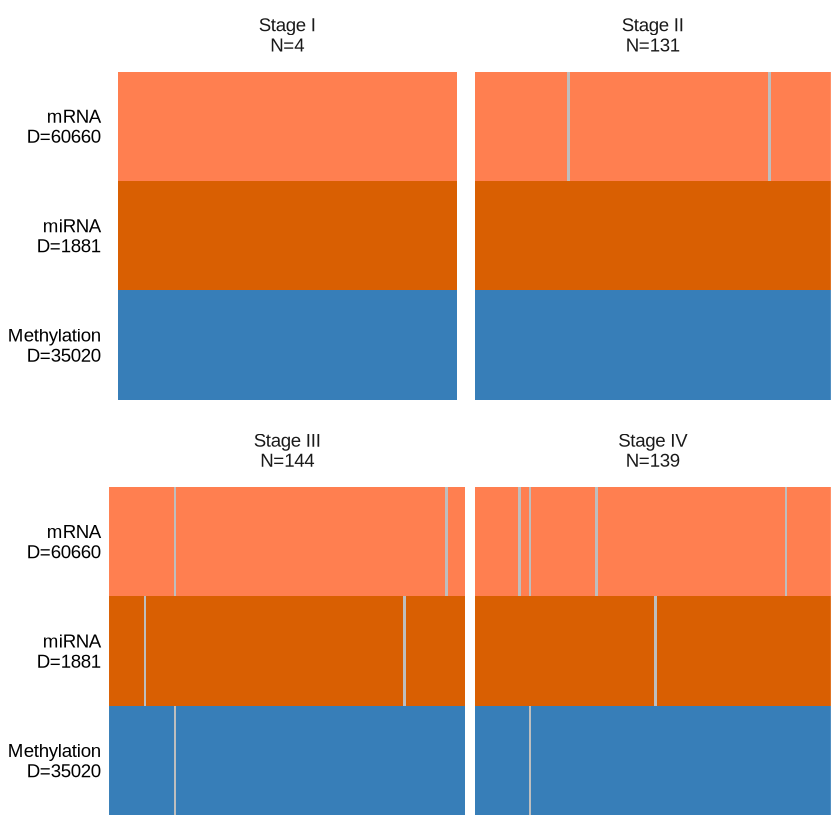

In [13]:
plot_data_overview(model)

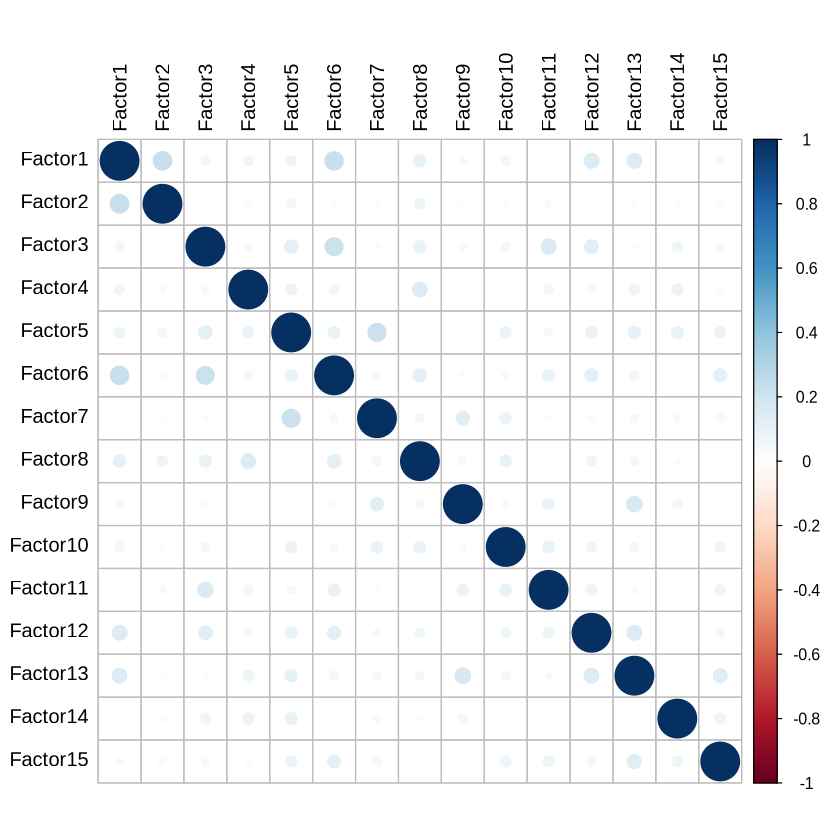

In [14]:
plot_factor_cor(model)

In [15]:
# Total variance explained per view and group
head(model@cache$variance_explained$r2_total)

$`Stage I`
       mRNA       miRNA Methylation 
  55.645233    9.279794   65.385884 

$`Stage II`
       mRNA       miRNA Methylation 
   30.41676    13.50176    49.87930 

$`Stage III`
       mRNA       miRNA Methylation 
   29.74123    12.83516    53.29781 

$`Stage IV`
       mRNA       miRNA Methylation 
   28.03012    10.80889    48.40111

In [16]:
# Variance explained for every factor in per view and group
head(model@cache$variance_explained$r2_per_factor)

,mRNA,miRNA,Methylation
Factor1,1.192093e-05,0.000000e+00,21.16234899
Factor2,1.089752e-01,7.078826e-01,-0.26185513
Factor3,3.776804e+01,2.384186e-05,0.87820888
Factor4,4.262525e+00,7.761407e+00,4.56437469
Factor5,1.192093e-05,0.000000e+00,30.82290292
Factor6,1.897120e+00,7.006466e-01,2.00111270
Factor7,1.077831e+00,0.000000e+00,9.52156186
Factor8,0.000000e+00,0.000000e+00,1.31514668
Factor9,3.861773e+00,0.000000e+00,0.01850724
Factor10,-9.589195e-02,-1.039028e-01,0.16245842


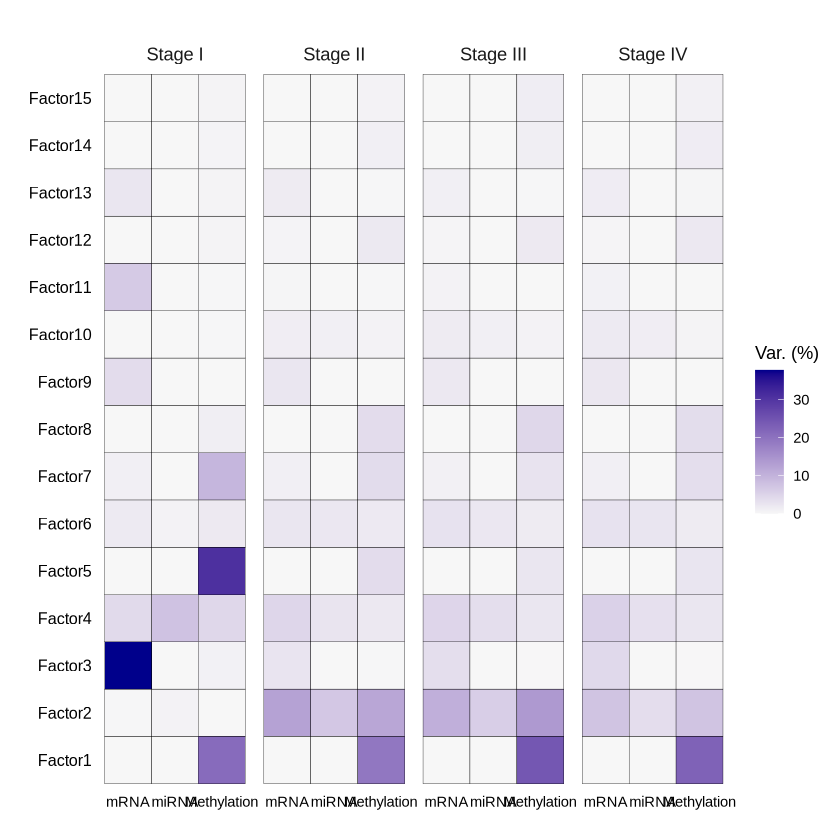

In [17]:
plot_variance_explained(model, x="view", y="factor")

### Save the plot from modelStage

In [18]:
# Generate the plot and store it in a variable
p <- plot_variance_explained(model, x = "view", y = "factor")

# Save the plot with increased width
ggsave("variance_explained_plot.png", plot = p, width = 15, height = 8)

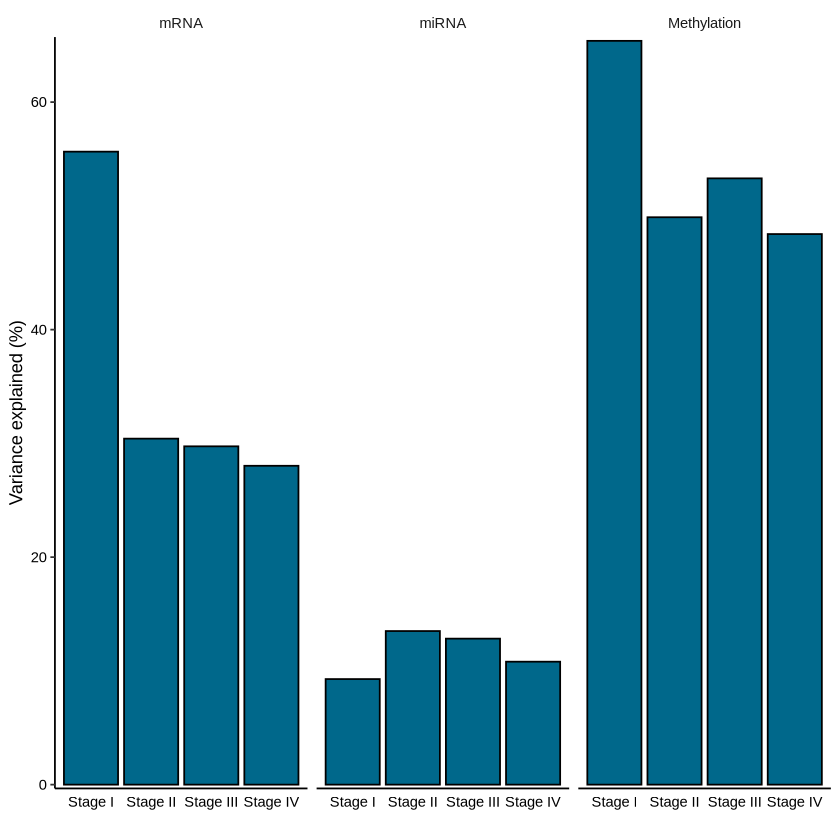

In [19]:
plot_variance_explained(model, x="group", y="factor", plot_total = T)[[2]]

In [106]:
colnames(model@samples_metadata)

[1] "group"                 "sample"                "ajcc_pathologic_stage"
 [4] "age_at_diagnosis"      "cigarettes_per_day"    "gender"               
 [7] "ethnicity"             "age_at_index"          "race"                 
[10] "days_to_death"

### plot_factor

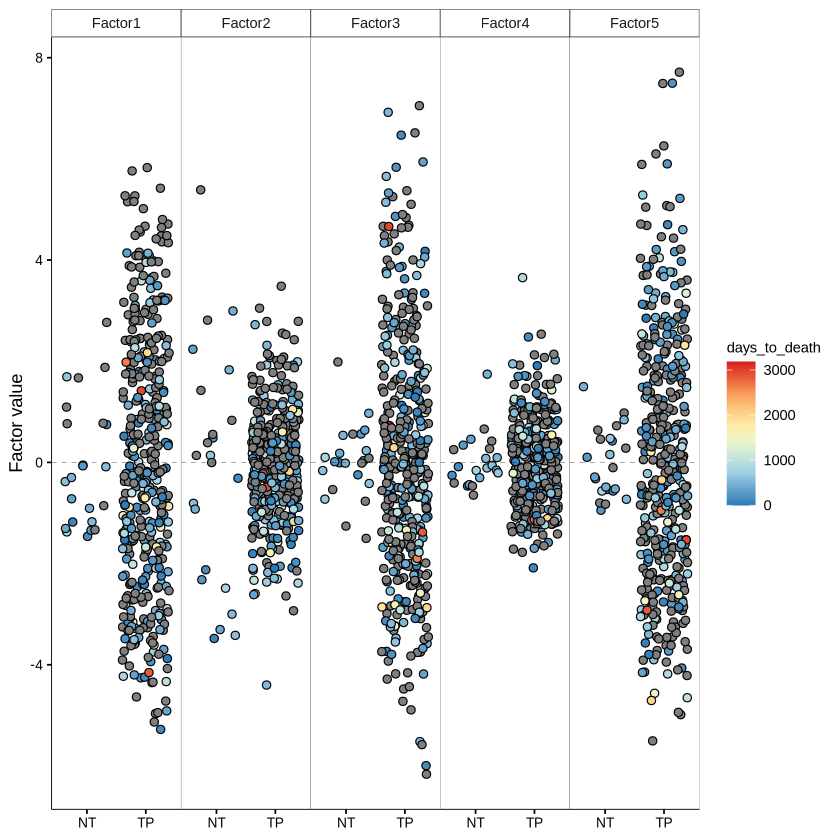

In [343]:
plot_factor(model, factor = 1:5, color_by = "days_to_death")

### Save the plot from modelStage

In [20]:
# Generate the plot and store it in a variable
p <- plot_factor(model, factor = 1:5, color_by = "age_at_diagnosis")

# Save the plot with increased width
ggsave("plot_factor_age_at_diagnosis.png", plot = p, width = 15, height = 8)

In [21]:
# Generate the plot and store it in a variable
p <- plot_factor(model, factor = 1:5, color_by = "cigarettes_per_day")

# Save the plot with increased width
ggsave("plot_factor_cigarettes_per_day.png", plot = p, width = 15, height = 8)

In [22]:
# Generate the plot and store it in a variable
p <- plot_factor(model, factor = 1:5, color_by = "gender")

# Save the plot with increased width
ggsave("plot_factor_gender.png", plot = p, width = 15, height = 8)

In [23]:
# Generate the plot and store it in a variable
p <- plot_factor(model, factor = 1:5, color_by = "ethnicity")

# Save the plot with increased width
ggsave("plot_factor_ethnicity.png", plot = p, width = 15, height = 8)

In [24]:
# Generate the plot and store it in a variable
p <- plot_factor(model, factor = 1:5, color_by = "age_at_index")

# Save the plot with increased width
ggsave("plot_factor_age_at_index.png", plot = p, width = 15, height = 8)

In [25]:
# Generate the plot and store it in a variable
p <- plot_factor(model, factor = 1:5, color_by = "race")

# Save the plot with increased width
ggsave("plot_factor_race.png", plot = p, width = 15, height = 8)

In [26]:
# Generate the plot and store it in a variable
p <- plot_factor(model, factor = 1:5, color_by = "days_to_death")

# Save the plot with increased width
ggsave("plot_factor_days_to_death.png", plot = p, width = 15, height = 8)

In [106]:
colnames(model@samples_metadata)

[1] "group"                 "sample"                "ajcc_pathologic_stage"
 [4] "age_at_diagnosis"      "cigarettes_per_day"    "gender"               
 [7] "ethnicity"             "age_at_index"          "race"                 
[10] "days_to_death"

In [118]:
head(model@samples_metadata$ethnicity)

[1] "not hispanic or latino" "not hispanic or latino" "not reported"          
[4] "not hispanic or latino" "not hispanic or latino" "not hispanic or latino"

In [27]:
p <- plot_factor(model, factors = c(1,2,3,4,5), color_by = "ajcc_pathologic_stage", dot_size = 3, dodge = T, legend = T, add_violin = T, violin_alpha = 0.25)

# The output of plot_factor is a ggplot2 object that we can edit
p <- p + 
  scale_color_manual(values=c("Stage I"="black", "Stage II"="green", "Stage III"="red", "Stage IV"="blue")) +
  scale_fill_manual(values=c("Stage I"="black", "Stage II"="green", "Stage III"="red", "Stage IV"="blue"))

# Save the plot with increased width
ggsave("plot_factor_ajcc_pathologic_stage.png", plot = p, width = 15, height = 8)

In [28]:
p <- plot_factor(model, factors = c(1,2,3,4,5), color_by = "gender", dot_size = 3, dodge = T, legend = T, add_violin = T, violin_alpha = 0.25)

# The output of plot_factor is a ggplot2 object that we can edit
p <- p + 
  scale_color_manual(values=c("male"="black", "female"="red")) +
  scale_fill_manual(values=c("male"="black", "female"="red"))

# Save the plot with increased width
ggsave("plot_factor_gender.png", plot = p, width = 15, height = 8)

In [29]:
p <- plot_factor(model, factors = c(1,2,3,4,5), color_by = "ethnicity", dot_size = 3, dodge = T, legend = T, add_violin = T, violin_alpha = 0.25)

# The output of plot_factor is a ggplot2 object that we can edit
p <- p + 
  scale_color_manual(values=c("hispanic or latino"="black", "not hispanic or latino"="green", "not reported"="red")) +
  scale_fill_manual(values=c("hispanic or latino"="black", "not hispanic or latino"="green", "not reported"="red"))

# Save the plot with increased width
ggsave("plot_factor_ethnicity.png", plot = p, width = 15, height = 8)

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


In [30]:
p <- plot_factor(model, factors = c(1,2,3,4,5), color_by = "race", dot_size = 3, dodge = T, legend = T, add_violin = T, violin_alpha = 0.25)

# The output of plot_factor is a ggplot2 object that we can edit
p <- p + 
  scale_color_manual(values=c("asian"="black", "black or african american"="green", "white"="blue", "not reported"="red")) +
  scale_fill_manual(values=c("asian"="black", "black or african american"="green", "white"="blue", "not reported"="red"))

# Save the plot with increased width
ggsave("plot_factor_race.png", plot = p, width = 15, height = 8)

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


### plot_factors

In [31]:
# Generate the plot and store it in a variable
p <- plot_factors(model, factors = 1:5, color_by = "group")

# Save the plot with increased width
ggsave("plot_factors.png", plot = p, width = 15, height = 8)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [ ]:
plot_top_weights(model, view = "mRNA", factor = 1, nfeatures = 10)

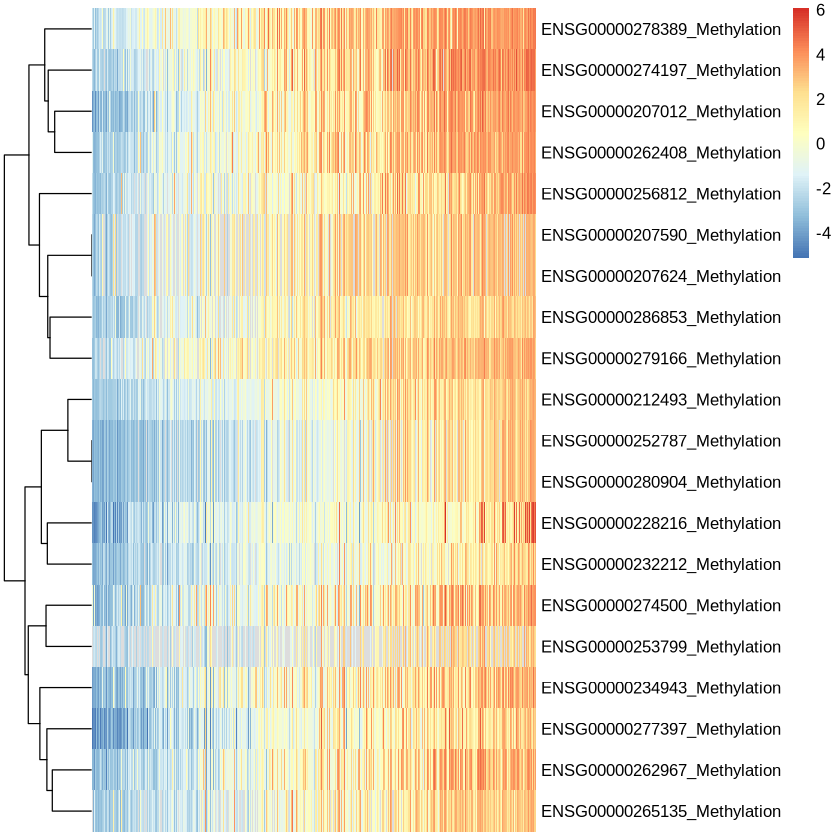

In [140]:
plot_data_heatmap(model,
  view = "Methylation",         # view of interest
  factor = 1,             # factor of interest
  features = 20,          # number of features to plot (they are selected by weight)
  
  # extra arguments that are passed to the `pheatmap` function
  cluster_rows = TRUE, cluster_cols = FALSE,
  show_rownames = TRUE, show_colnames = FALSE
)

### GSEA

In [40]:
# MSigDB_v6.0_C2_human
# MSigDB_v6.0_C5_human
# reactomeGS
data("reactomeGS")

enrichment.parametric <- run_enrichment(model,
  view = "mRNA", factors = 1:5,
  feature.sets = reactomeGS
)

Intersecting features names in the model and the gene set annotation results in a total of 18760 features.


Running feature set Enrichment Analysis with the following options...
View: mRNA 
Number of feature sets: 1279 
Set statistic: mean.diff 
Statistical test: parametric 







### Add suffix _methylation to match features names with colnames from gene set

In [56]:
# MSigDB_v6.0_C2_human
# MSigDB_v6.0_C5_human
# reactomeGS
data("reactomeGS")

colnames(reactomeGS) <- paste0(colnames(reactomeGS), "_methylation")
head(colnames(reactomeGS))

enrichment.parametric <- run_enrichment(model,
  view = "Methylation", factors = 1:5,
  feature.sets = reactomeGS
)

[1] "ENSG00000187634_methylation" "ENSG00000188976_methylation"
[3] "ENSG00000187961_methylation" "ENSG00000187583_methylation"
[5] "ENSG00000187642_methylation" "ENSG00000188290_methylation"

Intersecting features names in the model and the gene set annotation results in a total of 18074 features.


Running feature set Enrichment Analysis with the following options...
View: Methylation 
Number of feature sets: 1275 
Set statistic: mean.diff 
Statistical test: parametric 







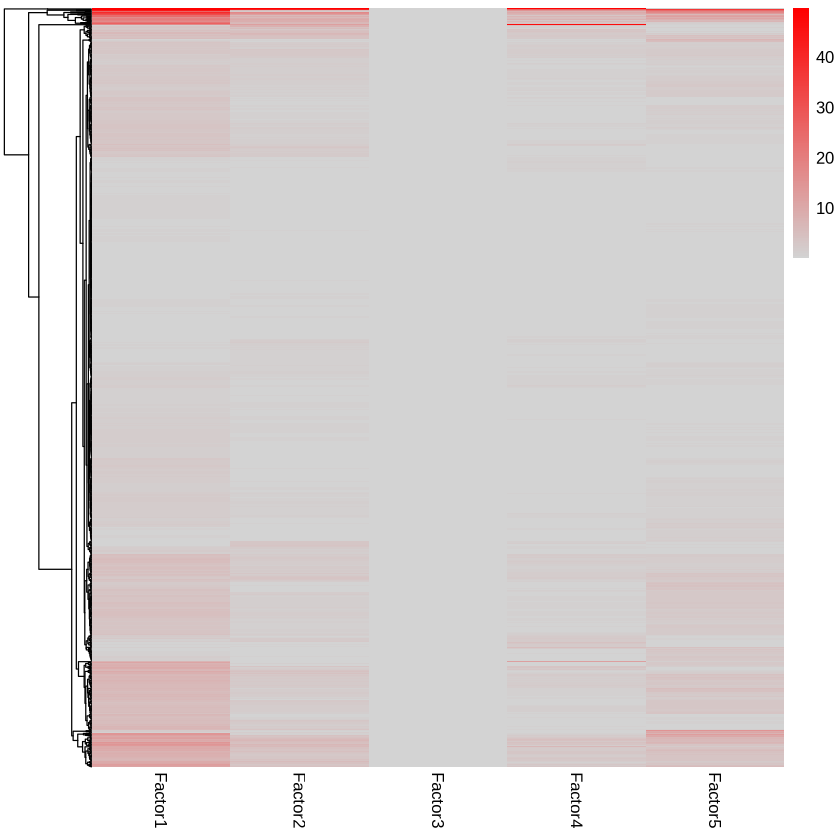

In [57]:
plot_enrichment_heatmap(enrichment.parametric)

In [59]:
for (x in 1:5){
    file=paste0("plot_enrichment_",as.character(x),".png")
    
    # Generate the plot and store it in a variable
    p <- plot_enrichment(enrichment.parametric, 
      factor = x, 
      max.pathways = 15
    )
    
    # Save the plot with increased width
    ggsave(file, plot = p, width = 15, height = 8)
}

In [60]:
for (x in 1:5){
    file=paste0("plot_enrichment_detailed_",as.character(x),".png")
    
    # Generate the plot and store it in a variable
    p <- plot_enrichment_detailed(enrichment.parametric, 
      factor = x
    )
    
    # Save the plot with increased width
    ggsave(file, plot = p, width = 15, height = 8)
}

### Remove pathways with rownames NA for reactomeGS

In [58]:
dim(enrichment.parametric$pval)
enrichment.parametric$feature.sets <- enrichment.parametric$feature.sets[! rownames(enrichment.parametric$feature.sets) %in% NA, ]
enrichment.parametric$pval <- enrichment.parametric$pval[! rownames(enrichment.parametric$pval) %in% NA, ]
enrichment.parametric$pval.adj <- enrichment.parametric$pval.adj[! rownames(enrichment.parametric$pval.adj) %in% NA, ]
enrichment.parametric$set.statistics <- enrichment.parametric$set.statistics[! rownames(enrichment.parametric$set.statistics) %in% NA, ]
dim(enrichment.parametric$pval)

[1] 1275    5

[1] 1274    5

# Integration


## mRNA
## Take barcode, sample_ids, patient, shortLetterCode ,definition and tumor stage data from dataPrep (mRNA)

In [16]:
barcode <- colnames(data_matrix)
sample_ids <- ""
sample_ids <- apply(as.matrix(barcode),1, function (x){dataPrep$sample[which(dataPrep$barcode %in% x)]})
definition <- ""
definition <- apply(as.matrix(barcode),1, function (x){dataPrep$definition[which(dataPrep$barcode %in% x)]})
stage <- ""
stage <- apply(as.matrix(barcode),1, function (x){dataPrep$ajcc_pathologic_stage[which(dataPrep$barcode %in% x)]})

In [17]:
mrna_info_df <- data.frame(barcode,sample_ids,definition,stage)
head(mrna_info_df)

,barcode,sample_ids,definition,stage
,<chr>,<chr>,<chr>,<chr>
1,TCGA-2F-A9KO-01A-11R-A38B-07,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV
2,TCGA-2F-A9KP-01A-11R-A38B-07,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV
3,TCGA-2F-A9KQ-01A-11R-A38B-07,TCGA-2F-A9KQ-01A,Primary solid Tumor,Stage III
4,TCGA-2F-A9KR-01A-11R-A38B-07,TCGA-2F-A9KR-01A,Primary solid Tumor,Stage III
5,TCGA-2F-A9KT-01A-11R-A38B-07,TCGA-2F-A9KT-01A,Primary solid Tumor,Stage II
6,TCGA-2F-A9KW-01A-11R-A38B-07,TCGA-2F-A9KW-01A,Primary solid Tumor,Stage III


### Add "-1" at the end of duplicate sample ids to modified_sample_ids to make integration easier.

In [18]:
# mrna_info_df$modified_sample_ids <- mrna_info_df$sample_ids
# modified_ids <- which(duplicated(mrna_info_df$sample_ids))
# mrna_info_df$modified_sample_ids[modified_ids] <- paste0(mrna_info_df$modified_sample_ids[modified_ids], "-1")
# head(mrna_info_df)

In [19]:
# saveRDS(mrna_info_df, file="mrna_info_df.rds")

In [20]:
# mrna_info_df <- readRDS("mrna_info_df.rds")

### Replace barcodes with sample ids at colnames

In [21]:
colnames(data_matrix) <- apply(as.matrix(colnames(data_matrix)),1, function (x){dataPrep$sample[which(dataPrep$barcode %in% x)]})
head(data_matrix)

,TCGA-2F-A9KO-01A,TCGA-2F-A9KP-01A,TCGA-2F-A9KQ-01A,TCGA-2F-A9KR-01A,TCGA-2F-A9KT-01A,TCGA-2F-A9KW-01A,TCGA-4Z-AA7M-01A,TCGA-4Z-AA7N-01A,TCGA-4Z-AA7O-01A,TCGA-4Z-AA7Q-01A,⋯,TCGA-CU-A0YR-11A,TCGA-GC-A3BM-11A,TCGA-GC-A3WC-11A,TCGA-GC-A6I3-11A,TCGA-GD-A2C5-11A,TCGA-GD-A3OP-11A,TCGA-GD-A3OQ-11A,TCGA-K4-A3WV-11A,TCGA-K4-A54R-11A,TCGA-K4-A5RI-11A
ENSG00000000003.15,108.0135,186.7056,72.4201,73.9806,76.9549,49.0722,159.5696,69.2064,155.7212,50.5693,⋯,27.3519,66.9105,39.2798,56.5882,152.7241,105.0533,125.2822,149.4164,77.8400,48.6603
ENSG00000000005.6,0.0000,0.1976,0.0411,0.0521,0.0000,0.0000,0.2330,0.1677,0.0000,0.0000,⋯,2.5092,0.2993,0.6569,0.0000,0.1715,0.0968,0.1468,0.2980,0.6020,0.2206
ENSG00000000419.13,204.8328,160.0243,99.3833,130.6741,254.8962,141.8646,191.0809,112.4019,85.7129,65.7745,⋯,74.0063,95.1648,81.6075,72.1844,115.9472,97.5357,82.1939,94.4974,105.4736,100.1734
ENSG00000000457.14,12.7153,8.6971,8.5596,9.7330,6.2762,6.2773,12.6685,5.0176,10.4437,7.8561,⋯,6.3928,3.9367,5.9285,3.9360,4.2650,4.4628,9.8345,7.9554,3.6381,5.3825
ENSG00000000460.17,9.2959,10.0028,3.7096,4.2981,4.8005,12.0951,22.3698,3.3797,10.0988,4.5288,⋯,1.6691,2.1460,1.5430,4.4411,2.9673,1.2684,2.4673,3.2538,1.6372,0.9597
ENSG00000000938.13,10.3989,2.4793,5.5616,13.2662,11.2466,8.4259,4.4497,15.3726,6.7245,12.7909,⋯,11.9936,10.2761,10.6082,16.5978,15.8787,14.0674,11.0964,6.9791,13.3277,30.6876


### Transpose matrix

In [22]:
data_matrix<- t(data_matrix)
head(data_matrix)

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,⋯,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-2F-A9KO-01A,108.0135,0.0000,204.8328,12.7153,9.2959,10.3989,85.2727,41.1606,67.2226,31.8547,⋯,0,0.000,0.6794,0,0,0.0000,8.3029,0,0.0252,0.0960
TCGA-2F-A9KP-01A,186.7056,0.1976,160.0243,8.6971,10.0028,2.4793,4.2396,74.9811,53.5222,42.5699,⋯,0,0.000,0.6909,0,0,0.0000,16.1807,0,0.0758,2.6909
TCGA-2F-A9KQ-01A,72.4201,0.0411,99.3833,8.5596,3.7096,5.5616,4.1743,65.1908,22.9030,23.6429,⋯,0,0.000,0.3194,0,0,0.0152,5.9433,0,0.0189,1.0113
TCGA-2F-A9KR-01A,73.9806,0.0521,130.6741,9.7330,4.2981,13.2662,52.5459,39.7470,39.5808,62.8356,⋯,0,0.000,0.8493,0,0,0.0000,14.1152,0,0.0479,0.8689
TCGA-2F-A9KT-01A,76.9549,0.0000,254.8962,6.2762,4.8005,11.2466,3.8422,73.8138,14.1576,33.3147,⋯,0,1.756,1.3681,0,0,0.0000,10.9036,0,0.0438,1.4425
TCGA-2F-A9KW-01A,49.0722,0.0000,141.8646,6.2773,12.0951,8.4259,9.2803,102.0816,7.9203,18.7707,⋯,0,1.401,0.7080,0,0,0.0000,7.6757,0,0.0087,0.7505


### Paste "-1" at the end of duplicated sample ids to make easier the integration

In [23]:
# duplicated_mrna <- which(duplicated(rownames(data_matrix)))
# rownames(data_matrix)[duplicated_mrna] <- paste0(rownames(data_matrix)[duplicated_mrna], "-1")

In [24]:
# rownames(data_matrix)[duplicated_mrna]
# grep("-1$", rownames(data_matrix), value = TRUE)

## miRNA

In [25]:
head(data_matrix_miR, 2)

,TCGA-DK-A2I2-01A-11R-A17X-13,TCGA-E7-A6MF-01A-12R-A32J-13,TCGA-DK-A3IV-01A-22R-A21E-13,TCGA-FD-A6TA-01A-12R-A33A-13,TCGA-FD-A62S-01A-11R-A30J-13,TCGA-BT-A20T-01A-11R-A14X-13,TCGA-UY-A78M-01A-21R-A358-13,TCGA-DK-AA6L-01A-11R-A39B-13,TCGA-FD-A5BT-01A-11R-A26X-13,TCGA-KQ-A41S-01A-12R-A33A-13,⋯,TCGA-BT-A2LB-11A-11R-A18B-13,TCGA-GC-A3WC-11A-11R-A22V-13,TCGA-BL-A13J-11A-13R-A10V-13,TCGA-CU-A0YR-11A-13R-A10V-13,TCGA-BT-A2LA-11A-11R-A18B-13,TCGA-BT-A20U-11A-11R-A14X-13,TCGA-K4-A54R-11A-11R-A26X-13,TCGA-GD-A2C5-11A-11R-A17X-13,TCGA-CU-A0YN-11A-11R-A10V-13,TCGA-BT-A20Q-11A-11R-A14X-13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-let-7a-1,4227.118,25109.46,9249.861,5408.821,5888.805,11645.36,5980.638,9529.839,6661.821,5619.656,⋯,8035.191,4950.450,3714.047,4619.003,11074.03,5780.253,8489.891,10270.60,4260.987,1261.238
hsa-let-7a-2,4233.940,25246.36,9116.643,5383.290,5912.460,11593.18,5987.890,9518.207,6645.946,5643.309,⋯,7985.394,4925.318,3717.455,4607.383,11031.28,5632.738,8302.043,10187.51,4336.998,1260.830


### Keep 16 first characters of barcode that are the sample id

In [26]:
colnames(data_matrix_miR) <- substr(colnames(data_matrix_miR), 1, 16)   
head(data_matrix_miR)

,TCGA-DK-A2I2-01A,TCGA-E7-A6MF-01A,TCGA-DK-A3IV-01A,TCGA-FD-A6TA-01A,TCGA-FD-A62S-01A,TCGA-BT-A20T-01A,TCGA-UY-A78M-01A,TCGA-DK-AA6L-01A,TCGA-FD-A5BT-01A,TCGA-KQ-A41S-01A,⋯,TCGA-BT-A2LB-11A,TCGA-GC-A3WC-11A,TCGA-BL-A13J-11A,TCGA-CU-A0YR-11A,TCGA-BT-A2LA-11A,TCGA-BT-A20U-11A,TCGA-K4-A54R-11A,TCGA-GD-A2C5-11A,TCGA-CU-A0YN-11A,TCGA-BT-A20Q-11A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-let-7a-1,4227.1177,25109.4564,9249.8609,5408.8206,5888.8051,11645.356,5980.6385,9529.8385,6661.8208,5619.6561,⋯,8035.1911,4950.4501,3714.0472,4619.0035,11074.0287,5780.2525,8489.8909,10270.5963,4260.9867,1261.2378
hsa-let-7a-2,4233.9404,25246.3643,9116.6426,5383.2897,5912.4601,11593.182,5987.8897,9518.2066,6645.9460,5643.3093,⋯,7985.3940,4925.3184,3717.4546,4607.3831,11031.2758,5632.7381,8302.0429,10187.5130,4336.9983,1260.8299
hsa-let-7a-3,4268.5087,25491.1219,9274.9561,5376.3415,5971.2392,11779.430,6066.9944,9486.5916,6757.2302,5669.5452,⋯,8007.1540,4936.2668,3707.3048,4590.1914,11046.6361,5640.2158,8477.7264,10249.8755,4327.4969,1243.1743
hsa-let-7b,4716.7601,23586.7060,12412.2601,7233.1442,5388.8961,19418.633,5901.8635,13403.8706,13138.1145,4467.7218,⋯,10492.2676,5002.7041,3274.1237,5613.8951,15188.8047,8621.7738,12019.2358,11618.6477,4884.2489,1274.4067
hsa-let-7c,312.4797,1066.2047,475.8749,573.7974,760.9742,1329.520,384.3166,898.9401,2784.5112,932.9390,⋯,4830.4603,2524.6176,1882.3619,2935.4876,2578.8711,2897.2641,2251.6037,4651.8635,2379.6982,461.2593
hsa-let-7d,822.3628,813.0649,737.1056,409.7861,545.9288,355.206,593.6142,366.8534,780.5932,452.9437,⋯,562.9725,244.8476,190.7447,226.9945,568.7162,205.9763,447.5135,473.0743,162.3582,132.0381


### Transpose matrix 

In [27]:
data_matrix_miR <- t(as.matrix(data_matrix_miR))
head(data_matrix_miR)

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,⋯,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-DK-A2I2-01A,4227.118,4233.940,4268.509,4716.760,312.4797,822.3628,1067.5252,3774.545,3860.056,433.6963,⋯,0,9.096934,0.682270,35.93289,0.454847,0,100.521118,65.49792,124.4006,16710.84
TCGA-E7-A6MF-01A,25109.456,25246.364,25491.122,23586.706,1066.2047,813.0649,2279.3758,10773.250,10957.656,881.2394,⋯,0,2.794038,0.000000,78.23305,0.558808,0,6.146883,35.20487,368.2541,27880.58
TCGA-DK-A3IV-01A,9249.861,9116.643,9274.956,12412.260,475.8749,737.1056,1141.1655,6222.682,6259.658,786.4951,⋯,0,14.149437,0.000000,12.41413,1.601823,0,16.285201,61.00276,168.9923,17873.94
TCGA-FD-A6TA-01A,5408.821,5383.290,5376.341,7233.144,573.7974,409.7861,1528.6184,2816.794,2828.106,516.4339,⋯,0,3.878102,0.000000,38.61943,0.484763,0,23.268609,74.65345,171.7676,41512.01
TCGA-FD-A62S-01A,5888.805,5912.460,5971.239,5388.896,760.9742,545.9288,1126.4082,4066.653,4198.834,362.8534,⋯,0,4.157546,0.000000,56.48528,0.286727,0,16.343456,67.66764,171.1762,18888.30
TCGA-BT-A20T-01A,11645.356,11593.182,11779.430,19418.633,1329.5198,355.2060,937.0036,5790.979,5776.419,332.4558,⋯,0,6.673383,0.303336,74.31721,0.910007,0,18.503470,99.19073,176.5413,13970.12


### Paste "-1" at the end of duplicated sample ids to make easier the integration

In [28]:
# duplicated_mirna <- which(duplicated(rownames(data_matrix_miR)))
# rownames(data_matrix_miR)[duplicated_mirna] <- paste0(rownames(data_matrix_miR)[duplicated_mirna], "-1")

In [29]:
# rownames(data_matrix_miR)[duplicated_mirna]
# grep("-1$", rownames(data_matrix_miR), value = TRUE)

In [29]:
# duplicated_mirna

## Meth

### Take sample_ids, patient, shortLetterCode, definition and tumor stage data from data_met (methylation). If they are duplicated i take only the first row that has the same data with duplicates

In [30]:
duplicated_rows <- duplicated(colData(data_met)$sample) 
sample_ids <- colData(data_met)[!duplicated_rows,"sample"]
definition <- colData(data_met)[!duplicated_rows,"definition"]
stage <- colData(data_met)[!duplicated_rows,"ajcc_pathologic_stage"]
info_df <- data.frame(sample_ids,definition,stage)
head(info_df)

,sample_ids,definition,stage
,<chr>,<chr>,<chr>
1,TCGA-FD-A3NA-01A,Primary solid Tumor,Stage II
2,TCGA-E7-A6MF-01A,Primary solid Tumor,Stage II
3,TCGA-UY-A9PB-01A,Primary solid Tumor,Stage III
4,TCGA-E7-A4IJ-01A,Primary solid Tumor,Stage II
5,TCGA-DK-A3IV-01A,Primary solid Tumor,Stage II
6,TCGA-FD-A6TA-01A,Primary solid Tumor,Stage IV


## Combine metadata from methylation and mRNA 

In [31]:
# remove barcode column from mrna_info_df, in order to have the same columns with info_df
mrna_info_df <- mrna_info_df[c("sample_ids","definition","stage")]
# Combine dataframes and remove duplicates based on sample_ids
combined_df <- bind_rows(mrna_info_df, info_df) %>% distinct(sample_ids, .keep_all = TRUE)
# .keep_all = TRUE ensures that all columns are kept in the resulting dataframe

head(combined_df, 2)

,sample_ids,definition,stage
,<chr>,<chr>,<chr>
1,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV
2,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV


In [32]:
# missing_elements <- colData(dataPrep)$sample[!(colData(dataPrep)$sample %in% colData(data_met)$sample)]
# missing_patient <- apply(as.matrix(missing_elements),1, function (x){colData(dataPrep)$patient[which(colData(dataPrep)$sample %in% x)]})
# missing_shortLetterCode <- apply(as.matrix(missing_elements),1, function (x){colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$sample %in% x)]})
# missing_definition <- apply(as.matrix(missing_elements),1, function (x){colData(dataPrep)$definition[which(colData(dataPrep)$sample %in% x)]})
# missing_stage <- apply(as.matrix(missing_elements),1, function (x){colData(dataPrep)$ajcc_pathologic_stage[which(colData(dataPrep)$sample %in% x)]})
# missing_info_df <- data.frame(sample_ids = missing_elements,patient = missing_patient,shortLetterCode = missing_shortLetterCode, definition = missing_definition,stage = missing_stage)
# missing_info_df

In [33]:
# missing_elements <- colData(dataPrep)$sample[!(colData(dataPrep)$sample %in% colData(data_met)$sample)]
# missing_sample_ids <- missing_elements
# missing_patient <- apply(as.matrix(missing_sample_ids),1, function (x){colData(dataPrep)$patient[which(colData(dataPrep)$sample %in% x)]})
# missing_shortLetterCode <- apply(as.matrix(missing_sample_ids),1, function (x){colData(dataPrep)$shortLetterCode[which(colData(dataPrep)$sample %in% x)]})
# missing_definition <- apply(as.matrix(missing_sample_ids),1, function (x){colData(dataPrep)$definition[which(colData(dataPrep)$sample %in% x)]})
# missing_stage <- apply(as.matrix(missing_sample_ids),1, function (x){colData(dataPrep)$ajcc_pathologic_stage[which(colData(dataPrep)$sample %in% x)]})
# missing_info_df <- data.frame(sample_ids = missing_sample_ids,patient = missing_patient,shortLetterCode = missing_shortLetterCode, definition = missing_definition,stage = missing_stage)
# missing_info_df

In [34]:
# dim(info_df)

## Add missing data to methylation

In [35]:
# info_df <- rbind(info_df,missing_info_df)
# dim(info_df)

In [36]:
saveRDS(combined_df, file="info_df.rds")

In [37]:
# info_df <- readRDS("info_df.rds")
info_df <- combined_df

In [38]:
head(info_df, 2)

,sample_ids,definition,stage
,<chr>,<chr>,<chr>
1,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV
2,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV


In [39]:
length(which(info_df[,2] %in% "Primary solid Tumor"))
length(which(info_df[,2] %in% "Solid Tissue Normal"))

[1] 415

[1] 23

## Replace barcodes of meth matrix with sample ids

In [40]:
# meth_matrix <- readRDS("meth_mat_mean_with_na.rds")
meth_matrix <- meth_mat_mean
head(meth_matrix, 2)

,TCGA-FD-A3NA-01A-11D-A21B-05,TCGA-E7-A6MF-01A-12D-A32C-05,TCGA-UY-A9PB-01A-11D-A38H-05,TCGA-E7-A4IJ-01A-31D-A26N-05,TCGA-DK-A3IV-01A-22D-A21B-05,TCGA-FD-A6TA-01A-12D-A33I-05,TCGA-GU-A42R-01A-11D-A23O-05,TCGA-FD-A6TG-01A-11D-A32C-05,TCGA-UY-A78M-01A-21D-A34V-05,TCGA-FD-A5BT-01A-11D-A26N-05,⋯,TCGA-BT-A20W-11A-11D-A14Z-05,TCGA-K4-A5RI-11A-11D-A28N-05,TCGA-BT-A20V-11A-11D-A14Z-05,TCGA-BT-A20N-11A-11D-A14Z-05,TCGA-K4-A3WV-11A-21D-A231-05,TCGA-BT-A20P-11A-11D-A14Z-05,TCGA-CU-A0YN-11A-11D-A10W-05,TCGA-GD-A2C5-11A-11D-A17Y-05,TCGA-BL-A13J-11A-13D-A10W-05,TCGA-GD-A3OQ-11A-21D-A223-05
ENSG00000000419,0.1178325,0.1234904,0.1074870,0.1131896,0.1210688,0.1209866,0.1081228,0.1165495,0.1198469,0.1083114,⋯,0.1283536,0.1279853,0.1322744,0.1328414,0.1118885,0.1289726,0.1308155,0.1161732,0.1299091,0.1082305
ENSG00000000457,0.2670827,0.2168660,0.2770998,0.2431043,0.2516276,0.2287701,0.2518552,0.2284875,0.2557735,0.2775308,⋯,0.2772068,0.2743403,0.2659583,0.2732396,0.2737861,0.2705068,0.2681463,0.2741836,0.2584690,0.2666568


In [41]:
colnames(meth_matrix) <- apply(as.matrix(colnames(meth_matrix)),1, function (x){data_met$sample[which(data_met$barcode %in% x)]})
head(meth_matrix, 2)

,TCGA-FD-A3NA-01A,TCGA-E7-A6MF-01A,TCGA-UY-A9PB-01A,TCGA-E7-A4IJ-01A,TCGA-DK-A3IV-01A,TCGA-FD-A6TA-01A,TCGA-GU-A42R-01A,TCGA-FD-A6TG-01A,TCGA-UY-A78M-01A,TCGA-FD-A5BT-01A,⋯,TCGA-BT-A20W-11A,TCGA-K4-A5RI-11A,TCGA-BT-A20V-11A,TCGA-BT-A20N-11A,TCGA-K4-A3WV-11A,TCGA-BT-A20P-11A,TCGA-CU-A0YN-11A,TCGA-GD-A2C5-11A,TCGA-BL-A13J-11A,TCGA-GD-A3OQ-11A
ENSG00000000419,0.1178325,0.1234904,0.1074870,0.1131896,0.1210688,0.1209866,0.1081228,0.1165495,0.1198469,0.1083114,⋯,0.1283536,0.1279853,0.1322744,0.1328414,0.1118885,0.1289726,0.1308155,0.1161732,0.1299091,0.1082305
ENSG00000000457,0.2670827,0.2168660,0.2770998,0.2431043,0.2516276,0.2287701,0.2518552,0.2284875,0.2557735,0.2775308,⋯,0.2772068,0.2743403,0.2659583,0.2732396,0.2737861,0.2705068,0.2681463,0.2741836,0.2584690,0.2666568


## Transpose matrix

In [42]:
meth_matrix <- t(meth_matrix)
head(meth_matrix, 2)

,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,⋯,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675
TCGA-FD-A3NA-01A,0.1178325,0.2670827,0.4436307,0.5438053,0.6216070,0.3544977,0.4259433,0.10318446,0.4157124,0.3464906,⋯,0.4325574,0.03078356,0.9159662,0.1609468,0.9499048,0.3749561,0.5761548,0.3478446,0.5823420,0.21956767
TCGA-E7-A6MF-01A,0.1234904,0.2168660,0.3737125,0.4496814,0.6661692,0.3657452,0.3195113,0.07328518,0.3765626,0.3123561,⋯,0.5889773,0.03299015,0.9305587,0.1658059,0.9376853,0.5153893,0.6778820,0.3307829,0.4846426,0.04450059


## Paste "-1" at the end of duplicated sample ids to make easier the integration

In [43]:
# duplicated_meth <- which(duplicated(rownames(meth_matrix)))
# rownames(meth_matrix)[duplicated_meth] <- paste0(rownames(meth_matrix)[duplicated_meth], "-1")

## Combine the rownames from the three matrices, keep only unique names (the duplictes have -1) and sort them 

In [44]:
rownames_data_matrix <- rownames(data_matrix)
rownames_data_matrix_miR <- rownames(data_matrix_miR)
rownames_data_matrix_meth <- rownames(meth_matrix)
all_rownames <- c(rownames_data_matrix, rownames_data_matrix_miR, rownames_data_matrix_meth)
unique_rownames <- unique(all_rownames)
head(unique_rownames,10)
sorted_rownames <- sort(unique_rownames)
head(sorted_rownames,10)

[1] "TCGA-2F-A9KO-01A" "TCGA-2F-A9KP-01A" "TCGA-2F-A9KQ-01A" "TCGA-2F-A9KR-01A"
 [5] "TCGA-2F-A9KT-01A" "TCGA-2F-A9KW-01A" "TCGA-4Z-AA7M-01A" "TCGA-4Z-AA7N-01A"
 [9] "TCGA-4Z-AA7O-01A" "TCGA-4Z-AA7Q-01A"

[1] "TCGA-2F-A9KO-01A" "TCGA-2F-A9KP-01A" "TCGA-2F-A9KQ-01A" "TCGA-2F-A9KR-01A"
 [5] "TCGA-2F-A9KT-01A" "TCGA-2F-A9KW-01A" "TCGA-4Z-AA7M-01A" "TCGA-4Z-AA7N-01A"
 [9] "TCGA-4Z-AA7O-01A" "TCGA-4Z-AA7Q-01A"

## Create matrix with unique sorted rownames with the mRNA data

In [45]:
mrna_new_matrix <- matrix(NA, nrow=length(sorted_rownames), ncol=ncol(data_matrix))

rownames(mrna_new_matrix) <- sorted_rownames
colnames(mrna_new_matrix) <- colnames(data_matrix)

rows <- rownames(data_matrix)

mrna_new_matrix[rows, ] <- data_matrix[rows, ]
head(mrna_new_matrix, 2)

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,⋯,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-2F-A9KO-01A,108.0135,0.0000,204.8328,12.7153,9.2959,10.3989,85.2727,41.1606,67.2226,31.8547,⋯,0,0,0.6794,0,0,0,8.3029,0,0.0252,0.0960
TCGA-2F-A9KP-01A,186.7056,0.1976,160.0243,8.6971,10.0028,2.4793,4.2396,74.9811,53.5222,42.5699,⋯,0,0,0.6909,0,0,0,16.1807,0,0.0758,2.6909


## Create matrix with unique sorted rownames with the miRNA data

In [46]:
mirna_new_matrix <- matrix(NA, nrow=length(sorted_rownames), ncol=ncol(data_matrix_miR))

rownames(mirna_new_matrix) <- sorted_rownames
colnames(mirna_new_matrix) <- colnames(data_matrix_miR)

rows_miR <- rownames(data_matrix_miR)

mirna_new_matrix[rows_miR, ] <- data_matrix_miR[rows_miR, ]

head(mirna_new_matrix, 2)

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,⋯,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-2F-A9KO-01A,6524.370,6586.408,6499.498,7784.978,924.9867,486.8057,1044.313,5857.876,5835.241,820.7510,⋯,0,12.29589,0,46.66851,0.558904,0,31.01919,71.81921,269.3919,11301.88
TCGA-2F-A9KP-01A,9504.759,9390.219,9459.109,9552.484,1336.7170,824.6062,2085.378,6095.944,6189.319,988.5315,⋯,0,14.94002,0,153.13523,2.905004,0,29.46504,121.18018,426.2056,39032.88


## Create matrix with unique sorted rownames with the methylation data

In [47]:
meth_new_matrix <- matrix(NA, nrow=length(sorted_rownames), ncol=ncol(meth_matrix))

rownames(meth_new_matrix) <- sorted_rownames
colnames(meth_new_matrix) <- colnames(meth_matrix)

rows_meth <- rownames(meth_matrix)

meth_new_matrix[rows_meth, ] <- meth_matrix[rows_meth, ]

head(meth_new_matrix, 2)

,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,⋯,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675
TCGA-2F-A9KO-01A,0.1120982,0.2472042,0.3787665,0.5957354,0.6870111,0.3733785,0.4145771,0.08814444,0.4073190,0.3458647,⋯,0.6688564,0.02663823,0.9105245,0.1491418,0.9568479,0.3982586,0.5648221,0.3348622,0.5809571,0.04180154
TCGA-2F-A9KP-01A,0.1107724,0.2497395,0.4159610,0.4672069,0.5008788,0.3394948,0.4058621,0.10142295,0.3970892,0.3021103,⋯,0.2493251,0.02518052,0.8638966,0.1373533,0.9553381,0.4540479,0.5762948,0.3430407,0.5682173,0.04503908


In [48]:
dim(meth_new_matrix)
dim(mirna_new_matrix)
dim(mrna_new_matrix)

[1]   438 34925

[1]  438 1881

[1]   438 60660

In [25]:
# saveRDS(meth_new_matrix,"meth_new_matrix.rds")
# saveRDS(mirna_new_matrix,"mirna_new_matrix.rds")
# saveRDS(mrna_new_matrix,"mrna_new_matrix.rds")

In [110]:
# meth_new_matrix <- readRDS("meth_new_matrix.rds")
# mirna_new_matrix <- readRDS("mirna_new_matrix.rds")
# mrna_new_matrix <- readRDS("mrna_new_matrix.rds")
# info_df <- readRDS("info_df.rds")

## Remove "-1" from rownames

In [36]:
# rownames(mrna_new_matrix) <- gsub("\\-1$", "", rownames(meth_new_matrix))
# rownames(mirna_new_matrix) <- gsub("\\-1$", "", rownames(meth_new_matrix))
# rownames(meth_new_matrix) <- gsub("\\-1$", "", rownames(meth_new_matrix))
# grep(".*-1$", rownames(mrna_new_matrix), value = TRUE)
# grep(".*-1$", rownames(mirna_new_matrix), value = TRUE)
# grep(".*-1$", rownames(meth_new_matrix), value = TRUE)

character(0)

character(0)

character(0)

## Encode classes of data with numbers

In [95]:
dim(info_df)
head(info_df, 2)

[1] 438   3

,sample_ids,definition,stage
,<chr>,<chr>,<chr>
1,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV
2,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV


In [70]:
# find the ids that end in -1
# info_df_for_duplicates <- data.frame(sample_ids = c(grep(".*-1$", unique_rownames, value = TRUE)))
# remove -1 in order to search for patients' metadata
# sample_ids_drom_duplicates <- gsub("\\-1$", "", info_df_for_duplicates$sample_ids)
# map ids that ends in -1 with patients' metadata 
# info_df_for_duplicates$definition <-   sapply(sample_ids_drom_duplicates, function (x){info_df$definition[which(info_df$sample_ids %in% x)]})
# info_df_for_duplicates$stage      <-   sapply(sample_ids_drom_duplicates, function (x){info_df$stage[which(info_df$sample_ids %in% x)]})
# info_df_for_duplicates

sample_ids,definition,stage
<chr>,<chr>,<chr>
TCGA-BL-A13J-01A-1,Primary solid Tumor,Stage IV
TCGA-BL-A13I-01A-1,Primary solid Tumor,Stage III
TCGA-BL-A0C8-01A-1,Primary solid Tumor,Stage I
TCGA-C4-A0F7-01A-1,Primary solid Tumor,Stage IV
TCGA-C4-A0F1-01A-1,Primary solid Tumor,Stage III


In [71]:
# Compare info_df_for_duplicates with the data from the duplicated patients 
# info_df[info_df$sample_ids %in% c("TCGA-BL-A0C8-01A", "TCGA-BL-A13I-01A", "TCGA-BL-A13J-01A", "TCGA-C4-A0F7-01A", "TCGA-C4-A0F1-01A"), ]

,sample_ids,definition,stage
,<chr>,<chr>,<chr>
38,TCGA-BL-A13J-01A,Primary solid Tumor,Stage IV
115,TCGA-BL-A13I-01A,Primary solid Tumor,Stage III
144,TCGA-C4-A0F1-01A,Primary solid Tumor,Stage III
239,TCGA-BL-A0C8-01A,Primary solid Tumor,Stage I
379,TCGA-C4-A0F7-01A,Primary solid Tumor,Stage IV


In [97]:
dim(info_df)
# dim(info_df_for_duplicates)
# info_df <- rbind(info_df, info_df_for_duplicates)
# dim(info_df)

[1] 438   3

In [98]:
unique(info_df$definition)
unique(info_df$stage)

[1] "Primary solid Tumor" "Solid Tissue Normal"

[1] "Stage IV"  "Stage III" "Stage II"  "Stage I"   NA

In [99]:
info_df$num_definition <- as.numeric(factor(info_df$definition))
info_df$num_stage      <- as.numeric(factor(info_df$stage))

In [100]:
# info_df$num_definition <- NA
# info_df$num_stage <- NA
# info_df$num_definition[info_df$definition %in% "Solid Tissue Normal"] <- 0
# info_df$num_definition[info_df$definition %in% "Primary solid Tumor"] <- 1

# info_df$num_stage[which(is.na(info_df$stage))] <- 0
# info_df$num_stage[info_df$stage %in% "Stage I"] <- 1
# info_df$num_stage[info_df$stage %in% "Stage II"] <- 2
# info_df$num_stage[info_df$stage %in% "Stage III"] <- 3
# info_df$num_stage[info_df$stage %in% "Stage IV"] <- 4

head(info_df)

,sample_ids,definition,stage,num_definition,num_stage
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV,1,4
2,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV,1,4
3,TCGA-2F-A9KQ-01A,Primary solid Tumor,Stage III,1,3
4,TCGA-2F-A9KR-01A,Primary solid Tumor,Stage III,1,3
5,TCGA-2F-A9KT-01A,Primary solid Tumor,Stage II,1,2
6,TCGA-2F-A9KW-01A,Primary solid Tumor,Stage III,1,3


In [55]:
# write.csv(info_df, "classes.csv", row.names=TRUE)

In [101]:
unique(info_df$num_definition)
unique(info_df$num_stage)

[1] 1 2

[1]  4  3  2  1 NA

## Create a matrix with sample ids, shortLetterCode and tumor_stage

In [102]:
definition_code <- rep(NA,length(sorted_rownames))
tumor_stage <- rep(NA,length(sorted_rownames))

definition_code <- apply(as.matrix(sorted_rownames),1, function (x){info_df$num_definition[which(info_df$sample_ids %in% x)]})
tumor_stage <- apply(as.matrix(sorted_rownames),1, function (x){info_df$num_stage[which(info_df$sample_ids %in% x)]})

metadata_matrix <- matrix(c(definition_code, tumor_stage), ncol = 2)

rownames(metadata_matrix) <- sorted_rownames
colnames(metadata_matrix) <- c("definition_code","tumor_stage")

head(metadata_matrix)

,definition_code,tumor_stage
TCGA-2F-A9KO-01A,1,4
TCGA-2F-A9KP-01A,1,4
TCGA-2F-A9KQ-01A,1,3
TCGA-2F-A9KR-01A,1,3
TCGA-2F-A9KT-01A,1,2
TCGA-2F-A9KW-01A,1,3


## Data integration

In [103]:
integrated_matrix <-cbind(mrna_new_matrix,mirna_new_matrix,meth_new_matrix,metadata_matrix)
dim(integrated_matrix)
head(integrated_matrix, 2)

[1]   438 97468

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,⋯,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675,definition_code,tumor_stage
TCGA-2F-A9KO-01A,108.0135,0.0000,204.8328,12.7153,9.2959,10.3989,85.2727,41.1606,67.2226,31.8547,⋯,0.9105245,0.1491418,0.9568479,0.3982586,0.5648221,0.3348622,0.5809571,0.04180154,1,4
TCGA-2F-A9KP-01A,186.7056,0.1976,160.0243,8.6971,10.0028,2.4793,4.2396,74.9811,53.5222,42.5699,⋯,0.8638966,0.1373533,0.9553381,0.4540479,0.5762948,0.3430407,0.5682173,0.04503908,1,4


## Save matrix to txt file 

In [104]:
write.table(integrated_matrix, 'normalized_data_integrated_matrix.txt')

In [3]:
df <- read.table(file='normalized_data_integrated_matrix.txt', header=TRUE)
head(df, 2)

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,⋯,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675,definition_code,tumor_stage
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
TCGA-2F-A9KO-01A,108.0135,0.0000,204.8328,12.7153,9.2959,10.3989,85.2727,41.1606,67.2226,31.8547,⋯,0.9105245,0.1491418,0.9568479,0.3982586,0.5648221,0.3348622,0.5809571,0.04180154,1,4
TCGA-2F-A9KP-01A,186.7056,0.1976,160.0243,8.6971,10.0028,2.4793,4.2396,74.9811,53.5222,42.5699,⋯,0.8638966,0.1373533,0.9553381,0.4540479,0.5762948,0.3430407,0.5682173,0.04503908,1,4


### Check feature selection by standard deviation for mRNA

In [18]:
df_mrna<-df[,1:60660]
dim(df_mrna)
head(df_mrna)

[1]   438 60660

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,⋯,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
TCGA-2F-A9KO-01A,108.0135,0.0000,204.8328,12.7153,9.2959,10.3989,85.2727,41.1606,67.2226,31.8547,⋯,0,0.000,0.6794,0,0,0.0000,8.3029,0,0.0252,0.0960
TCGA-2F-A9KP-01A,186.7056,0.1976,160.0243,8.6971,10.0028,2.4793,4.2396,74.9811,53.5222,42.5699,⋯,0,0.000,0.6909,0,0,0.0000,16.1807,0,0.0758,2.6909
TCGA-2F-A9KQ-01A,72.4201,0.0411,99.3833,8.5596,3.7096,5.5616,4.1743,65.1908,22.9030,23.6429,⋯,0,0.000,0.3194,0,0,0.0152,5.9433,0,0.0189,1.0113
TCGA-2F-A9KR-01A,73.9806,0.0521,130.6741,9.7330,4.2981,13.2662,52.5459,39.7470,39.5808,62.8356,⋯,0,0.000,0.8493,0,0,0.0000,14.1152,0,0.0479,0.8689
TCGA-2F-A9KT-01A,76.9549,0.0000,254.8962,6.2762,4.8005,11.2466,3.8422,73.8138,14.1576,33.3147,⋯,0,1.756,1.3681,0,0,0.0000,10.9036,0,0.0438,1.4425
TCGA-2F-A9KW-01A,49.0722,0.0000,141.8646,6.2773,12.0951,8.4259,9.2803,102.0816,7.9203,18.7707,⋯,0,1.401,0.7080,0,0,0.0000,7.6757,0,0.0087,0.7505


In [189]:
#count zeros per column
zero_counts<-c()
for (i in 1:length(colnames(df_mrna))){
    zero_counts[i]<- length(which(df_mrna[1:438, i] == 0))}

# Calculate the percentage of zeros per column
# use 438 because the counting of zeros is before filtering
zero_percentages <- zero_counts / 438 * 100

# Identify columns to remove (more than 20% zeros)
columns_to_remove <- colnames(df_mrna)[zero_percentages > 20]
length(columns_to_remove)

# Remove these columns from the DataFrame
df_mrna <- df_mrna[, !(colnames(df_mrna) %in% columns_to_remove)]
dim(df_mrna)

[1] 36983

[1]   438 23677

In [190]:
# samples that are removed in py scripts preprocessing 
rowtoremo<-c('TCGA-BL-A5ZZ-01A', 'TCGA-BT-A20J-11A' ,'TCGA-BT-A20P-11A', 'TCGA-BT-A20Q-11A', 'TCGA-BT-A20V-11A' ,'TCGA-BT-A20X-11A',
 'TCGA-BT-A2LB-11A' ,'TCGA-BT-A42B-01A', 'TCGA-DK-A6AW-01A',
 'TCGA-E7-A97Q-01A', 'TCGA-G2-AA3C-01A' ,'TCGA-XF-A9SG-01A',
 'TCGA-XF-A9ST-01A' ,'TCGA-XF-AAMF-01A', 'TCGA-ZF-A9RG-01A')

In [191]:
#remove these samples
df_mrna<-df_mrna[which(!rownames(df_mrna) %in% rowtoremo), ]
dim(df_mrna)

[1]   423 23677

In [192]:
# Calculate the standard deviation for each column
std_devs <- c()
for (x in 1:length(colnames(df_mrna))){
    std_devs[x]<- sd(df_mrna[, x], na.rm = TRUE)}
std_devs[1:5]

[1] 77.228536 53.760945  4.802018  6.864308  9.258214

In [193]:
selection_df_mrna<-data.frame(feats=colnames(df_mrna), std_devs=std_devs)
head(selection_df_mrna)

,feats,std_devs
,<chr>,<dbl>
1,ENSG00000000003.15,77.228536
2,ENSG00000000419.13,53.760945
3,ENSG00000000457.14,4.802018
4,ENSG00000000460.17,6.864308
5,ENSG00000000938.13,9.258214
6,ENSG00000000971.16,35.729810


In [194]:
ordered_selection_df_mrna<-selection_df_mrna[order(selection_df_mrna$std_devs, decreasing = TRUE), ]
head(ordered_selection_df_mrna)

,feats,std_devs
,<chr>,<dbl>
22298,ENSG00000276168.1,21582.49
15524,ENSG00000211592.8,20446.11
14890,ENSG00000198712.1,16422.36
14977,ENSG00000198886.2,15634.41
14933,ENSG00000198804.2,14523.74
9852,ENSG00000163220.11,14505.76


In [195]:
top2000feats<-ordered_selection_df_mrna$feats[1:2000]
rv = rev(top2000feats) 

In [196]:
exportedSelectedFeatures <- read.table(file='/home/thlamp/scripts/exportedSelectedFeatures.txt', header=FALSE, sep = "\n")

In [197]:
identical(exportedSelectedFeatures[1:2000,1], rv)

[1] TRUE

### Check feature selection by standard deviation for miRNA

In [23]:
df_mirna<-df[,60661:62541]
dim(df_mirna)
head(df_mirna)

[1]  438 1881

,hsa.let.7a.1,hsa.let.7a.2,hsa.let.7a.3,hsa.let.7b,hsa.let.7c,hsa.let.7d,hsa.let.7e,hsa.let.7f.1,hsa.let.7f.2,hsa.let.7g,⋯,hsa.mir.941.5,hsa.mir.942,hsa.mir.943,hsa.mir.944,hsa.mir.95,hsa.mir.9500,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-2F-A9KO-01A,6524.370,6586.408,6499.498,7784.978,924.98666,486.8057,1044.313,5857.876,5835.241,820.7510,⋯,0,12.29589,0,46.66851,0.558904,0,31.01919,71.81921,269.391884,11301.88
TCGA-2F-A9KP-01A,9504.759,9390.219,9459.109,9552.484,1336.71697,824.6062,2085.378,6095.944,6189.319,988.5315,⋯,0,14.94002,0,153.13523,2.905004,0,29.46504,121.18018,426.205629,39032.88
TCGA-2F-A9KQ-01A,10480.391,10457.495,10516.237,9018.774,54.57935,501.3899,3579.573,5721.812,5706.779,980.5781,⋯,0,10.40708,0,106.38347,0.693805,0,72.38701,74.93097,8.325663,52244.46
TCGA-2F-A9KR-01A,16055.867,15991.236,16029.989,15910.448,629.49246,288.3422,1823.978,4881.588,4963.427,576.2904,⋯,0,6.96225,0,120.85415,1.576358,0,73.16930,50.70620,178.128500,22704.03
TCGA-2F-A9KT-01A,8543.017,8610.276,8678.990,11112.823,1030.13509,624.8360,3746.105,8811.178,8894.160,904.6438,⋯,0,16.01397,0,256.51470,0.873489,0,49.20657,107.14803,266.414248,25411.55
TCGA-2F-A9KW-01A,7170.609,7160.516,7283.877,3784.364,884.27047,490.6383,2887.196,6420.353,6434.932,668.3896,⋯,0,15.13970,0,42.05472,2.242918,0,25.79356,70.09119,204.105549,35685.39


In [199]:
#count zeros per column
zero_counts<-c()
for (i in 1:length(colnames(df_mirna))){
    zero_counts[i]<- length(which(df_mirna[1:438, i] == 0))}

# Calculate the percentage of zeros per column
# use 438 because the counting of zeros is before filtering
zero_percentages <- zero_counts / 438 * 100

# Identify columns to remove (more than 20% zeros)
columns_to_remove <- colnames(df_mirna)[zero_percentages > 20]
length(columns_to_remove)

# Remove these columns from the DataFrame
df_mirna <- df_mirna[, !(colnames(df_mirna) %in% columns_to_remove)]
dim(df_mirna)

[1] 1469

[1] 438 412

In [200]:
# samples that are removed in py scripts preprocessing 
rowtoremo<-c('TCGA-BL-A5ZZ-01A', 'TCGA-BT-A20J-11A' ,'TCGA-BT-A20P-11A', 'TCGA-BT-A20Q-11A', 'TCGA-BT-A20V-11A' ,'TCGA-BT-A20X-11A',
 'TCGA-BT-A2LB-11A' ,'TCGA-BT-A42B-01A', 'TCGA-DK-A6AW-01A',
 'TCGA-E7-A97Q-01A', 'TCGA-G2-AA3C-01A' ,'TCGA-XF-A9SG-01A',
 'TCGA-XF-A9ST-01A' ,'TCGA-XF-AAMF-01A', 'TCGA-ZF-A9RG-01A')

In [201]:
#remove these samples
df_mirna<-df_mirna[which(!rownames(df_mirna) %in% rowtoremo), ]
dim(df_mirna)

[1] 423 412

In [202]:
colnames(df_mirna)<-gsub("\\.","-", colnames(df_mirna))
identical(exportedSelectedFeatures[2001:2412,1], colnames(df_mirna))

[1] TRUE

### Check feature selection by standard deviation for methylation

In [27]:
df_meth<-df[, 62542:(length(colnames(df))-2)]
dim(df_meth)
head(df_meth)

[1]   438 34925

,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,⋯,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-2F-A9KO-01A,0.1120982,0.2472042,0.3787665,0.5957354,0.6870111,0.3733785,0.4145771,0.08814444,0.4073190,0.3458647,⋯,0.66885636,0.02663823,0.9105245,0.1491418,0.9568479,0.3982586,0.5648221,0.3348622,0.5809571,0.04180154
TCGA-2F-A9KP-01A,0.1107724,0.2497395,0.4159610,0.4672069,0.5008788,0.3394948,0.4058621,0.10142295,0.3970892,0.3021103,⋯,0.24932508,0.02518052,0.8638966,0.1373533,0.9553381,0.4540479,0.5762948,0.3430407,0.5682173,0.04503908
TCGA-2F-A9KQ-01A,0.1074851,0.1883960,0.3016393,0.4645730,0.2615268,0.3306501,0.3443486,0.08255473,0.3514328,0.2610894,⋯,0.07642295,0.02186187,0.7846970,0.1117774,0.9196136,0.4193107,0.6394692,0.3101834,0.5065767,0.04396922
TCGA-2F-A9KR-01A,0.1017456,0.2056265,0.3512698,0.4526915,0.5404175,0.3401335,0.3351622,0.07019747,0.3482781,0.2555855,⋯,0.17147342,0.01852117,0.5704426,0.1180861,0.9606168,0.3097605,0.6336235,0.2988365,0.4549373,0.04006284
TCGA-2F-A9KT-01A,0.1126955,0.2604638,0.4060463,0.4597745,0.8069766,0.3581160,0.4354412,0.09738142,0.3973268,0.3024971,⋯,0.47229503,0.02812419,0.8836053,0.1433971,0.9610450,0.3793169,0.6570676,0.3380364,0.5619161,0.04877790
TCGA-2F-A9KW-01A,0.1103026,0.2443276,0.4166851,0.5399442,0.6490222,0.3227989,0.3968870,0.08630244,0.4068079,0.3271993,⋯,0.27502947,0.02837716,0.8927929,0.1347703,0.9643498,0.3804890,0.6703295,0.3381958,0.5787268,0.25128122


In [5]:
#count NAs per column
na_counts<-c()
for (i in 1:length(colnames(df_meth))){
    na_counts[i]<- length(which(is.na(df_meth[1:438, i])))}

# Calculate the percentage of NAs per column
# use 438 because the counting of NAs is before filtering
na_percentages <- na_counts / 438 * 100

# Identify columns to remove (more than 20% zeros)
columns_to_remove <- colnames(df_meth)[na_percentages > 10]
length(columns_to_remove)

# Remove these columns from the DataFrame
df_meth <- df_meth[, !(colnames(df_meth) %in% columns_to_remove)]
dim(df_meth)

[1] 2134

[1]   438 32791

In [6]:
# samples that are removed in py scripts preprocessing 
rowtoremo<-c('TCGA-BL-A5ZZ-01A', 'TCGA-BT-A20J-11A' ,'TCGA-BT-A20P-11A', 'TCGA-BT-A20Q-11A', 'TCGA-BT-A20V-11A' ,'TCGA-BT-A20X-11A',
 'TCGA-BT-A2LB-11A' ,'TCGA-BT-A42B-01A', 'TCGA-DK-A6AW-01A',
 'TCGA-E7-A97Q-01A', 'TCGA-G2-AA3C-01A' ,'TCGA-XF-A9SG-01A',
 'TCGA-XF-A9ST-01A' ,'TCGA-XF-AAMF-01A', 'TCGA-ZF-A9RG-01A')

In [7]:
#remove these samples
df_meth<-df_meth[which(!rownames(df_meth) %in% rowtoremo), ]
dim(df_meth)

[1]   423 32791

In [8]:
head(df_meth,2)

# Calculate the standard deviation for each column
std_devs <- c()
for (x in 1:length(colnames(df_meth))){
    std_devs[x]<- sd(df_meth[, x], na.rm = TRUE)}
std_devs[1:5]

selection_df_meth<-data.frame(feats=colnames(df_meth), std_devs=std_devs)
head(selection_df_meth)

ordered_selection_df_meth<-selection_df_meth[order(selection_df_meth$std_devs, decreasing = TRUE), ]
head(ordered_selection_df_meth)

top2000feats<-ordered_selection_df_meth[1:2000, ]
rv = top2000feats$feats

,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,⋯,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-2F-A9KO-01A,0.1120982,0.2472042,0.3787665,0.5957354,0.6870111,0.3733785,0.4145771,0.08814444,0.4073190,0.3458647,⋯,0.6688564,0.02663823,0.9105245,0.1491418,0.9568479,0.3982586,0.5648221,0.3348622,0.5809571,0.04180154
TCGA-2F-A9KP-01A,0.1107724,0.2497395,0.4159610,0.4672069,0.5008788,0.3394948,0.4058621,0.10142295,0.3970892,0.3021103,⋯,0.2493251,0.02518052,0.8638966,0.1373533,0.9553381,0.4540479,0.5762948,0.3430407,0.5682173,0.04503908


[1] 0.009464207 0.025227204 0.043461677 0.079768843 0.152470691

,feats,std_devs
,<chr>,<dbl>
1,ENSG00000000419,0.009464207
2,ENSG00000000457,0.025227204
3,ENSG00000000460,0.043461677
4,ENSG00000000938,0.079768843
5,ENSG00000000971,0.152470691
6,ENSG00000001036,0.021305981


,feats,std_devs
,<chr>,<dbl>
30115,ENSG00000278918,0.3337723
25159,ENSG00000255964,0.3140681
17818,ENSG00000213355,0.3103480
19584,ENSG00000227265,0.3103480
4955,ENSG00000122136,0.3097424
21279,ENSG00000234627,0.3085105


In [9]:
# check with the methylation data after imputation in python
data <- read.csv("/home/thlamp/scripts/data1.csv", header = TRUE, sep = ",")

In [10]:
dim(data)
head(data, 2)

[1]   423 32792

,X,X0,X1,X2,X3,X4,X5,X6,X7,X8,⋯,X32781,X32782,X32783,X32784,X32785,X32786,X32787,X32788,X32789,X32790
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.1120982,0.2472042,0.3787665,0.5957354,0.6870111,0.3733785,0.4145771,0.08814444,0.4073190,⋯,0.6688564,0.02663823,0.9105245,0.1491418,0.9568479,0.3982586,0.5648221,0.3348622,0.5809571,0.04180154
2,1,0.1107724,0.2497395,0.4159610,0.4672069,0.5008788,0.3394948,0.4058621,0.10142295,0.3970892,⋯,0.2493251,0.02518052,0.8638966,0.1373533,0.9553381,0.4540479,0.5762948,0.3430407,0.5682173,0.04503908


In [11]:
#remove first column
data<-data[,2:ncol(data)]
dim(data)

[1]   423 32791

In [12]:
# Calculate the standard deviation for each column
std_devs <- c()
for (x in 1:length(colnames(data))){
    std_devs[x]<- sd(data[, x], na.rm = TRUE)}
std_devs[1:5]

[1] 0.009464207 0.025227204 0.043461677 0.079768843 0.152470691

In [13]:
selection_df_meth<-data.frame(feats=colnames(df_meth), std_devs=std_devs)
head(selection_df_meth)

,feats,std_devs
,<chr>,<dbl>
1,ENSG00000000419,0.009464207
2,ENSG00000000457,0.025227204
3,ENSG00000000460,0.043461677
4,ENSG00000000938,0.079768843
5,ENSG00000000971,0.152470691
6,ENSG00000001036,0.021305981


In [14]:
ordered_selection_df_meth<-selection_df_meth[order(selection_df_meth$std_devs, decreasing = TRUE), ]
head(ordered_selection_df_meth)

,feats,std_devs
,<chr>,<dbl>
30115,ENSG00000278918,0.3337723
25159,ENSG00000255964,0.3140681
17818,ENSG00000213355,0.3103480
19584,ENSG00000227265,0.3103480
4955,ENSG00000122136,0.3097424
21279,ENSG00000234627,0.3085105


In [15]:
top2000feats<-ordered_selection_df_meth[1:2000, ]
check_rv = top2000feats$feats

In [17]:
identical(check_rv, rv)

[1] TRUE

### Imputation and check top 2000 features

In [208]:
df_meth<-t(df_meth)
dim(df_meth)
head(df_meth,2)

[1]   423 32791

,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,⋯,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675
TCGA-2F-A9KO-01A,0.1120982,0.2472042,0.3787665,0.5957354,0.6870111,0.3733785,0.4145771,0.08814444,0.4073190,0.3458647,⋯,0.6688564,0.02663823,0.9105245,0.1491418,0.9568479,0.3982586,0.5648221,0.3348622,0.5809571,0.04180154
TCGA-2F-A9KP-01A,0.1107724,0.2497395,0.4159610,0.4672069,0.5008788,0.3394948,0.4058621,0.10142295,0.3970892,0.3021103,⋯,0.2493251,0.02518052,0.8638966,0.1373533,0.9553381,0.4540479,0.5762948,0.3430407,0.5682173,0.04503908


In [207]:
imputed_matrix <- impute.knn(df_meth,k = 5, rowmax = 0.6, maxp = dim(df_meth)[1])$data
any(is.na(imputed_matrix))

[1] FALSE

In [208]:
imputed_matrix<-t(imputed_matrix)
dim(imputed_matrix)

[1]   423 32791

In [81]:
# Calculate the standard deviation for each column
std_devs <- c()
for (x in 1:length(colnames(imputed_matrix))){
    std_devs[x]<- sd(imputed_matrix[, x], na.rm = TRUE)}
std_devs[1:5]

[1] 0.2471115 0.2899029 0.2544198 0.2503516 0.2526993

In [82]:
selection_df_meth<-data.frame(feats=colnames(imputed_matrix), std_devs=std_devs)
head(selection_df_meth)

,feats,std_devs
,<chr>,<dbl>
1,TCGA-FD-A3NA-01A-11D-A21B-05,0.2471115
2,TCGA-E7-A6MF-01A-12D-A32C-05,0.2899029
3,TCGA-UY-A9PB-01A-11D-A38H-05,0.2544198
4,TCGA-E7-A4IJ-01A-31D-A26N-05,0.2503516
5,TCGA-DK-A3IV-01A-22D-A21B-05,0.2526993
6,TCGA-FD-A6TA-01A-12D-A33I-05,0.2333751


In [83]:
ordered_selection_df_meth<-selection_df_meth[order(selection_df_meth$std_devs, decreasing = TRUE), ]
head(ordered_selection_df_meth)

,feats,std_devs
,<chr>,<dbl>
30,TCGA-XF-AAN8-01A-11D-A42F-05,0.2934661
41,TCGA-CF-A9FM-01A-11D-A38H-05,0.2900469
2,TCGA-E7-A6MF-01A-12D-A32C-05,0.2899029
199,TCGA-E7-A85H-01A-11D-A34V-05,0.2890846
370,TCGA-HQ-A2OF-01A-11D-A26N-05,0.2890319
196,TCGA-CF-A5UA-01A-11D-A28N-05,0.2881589


In [84]:
top2000feats<-ordered_selection_df_meth$feats[1:2000]
rv = rev(top2000feats)

In [213]:
exportedSelectedFeatures <- read.table(file='/home/thlamp/scripts/exportedSelectedFeatures.txt', header=FALSE, sep = "\n")

In [214]:
identical(exportedSelectedFeatures[2413:4412,1], rv)

[1] FALSE

In [215]:
# similar feature names
length(which(rv %in% exportedSelectedFeatures[2413:4412,1]))

[1] 1999

In [216]:
#different features
which(!rv %in% exportedSelectedFeatures[2413:4412,1])
which(!exportedSelectedFeatures[2413:4412,1] %in% rv)

[1] 2

[1] 1

In [217]:
#different feature names
rv[2]
exportedSelectedFeatures[2413,1]

[1] "ENSG00000233460"

[1] "ENSG00000286921"

In [218]:
#check different feature names
which(exportedSelectedFeatures[2413:4412,1] %in% 'ENSG00000233460')
which(rv %in% 'ENSG00000286921')

integer(0)

integer(0)

In [247]:
#NAs in methylation
length(which(is.na(df_meth)))

[1] 16497

In [ ]:
#NAs with small dofference in imputation
length(which(!imputed_matrix[which(is.na(df_meth))] == as.matrix(data)[which(is.na(df_meth))]))
#index NAs with small difference in imputation in which(is.na(df_meth))
which(!imputed_matrix[which(is.na(df_meth))] == as.matrix(data)[which(is.na(df_meth))])

In [244]:
which(is.na(df_meth))[12]

[1] 78536

In [245]:
#example of small difference in imputation
imputed_matrix[78536]
as.matrix(data)[78536]

[1] 0.07227967

[1] 0.0737369

### Check control/tumor in integrated matrix

In [ ]:
unique(df$definition_code[grep("-01A", rownames(df))])
length(df$definition_code[grep("-01A", rownames(df))])
unique(df$definition_code[grep("-01B", rownames(df))])
length(df$definition_code[grep("-01B", rownames(df))])

In [ ]:
unique(df$definition_code[grep("-11A", rownames(df))])
length(df$definition_code[grep("-11A", rownames(df))])

## Check tumor stage in df and metadata

In [4]:
info_df <- readRDS("info_df.rds")
head(info_df)

,sample_ids,definition,stage
,<chr>,<chr>,<chr>
1,TCGA-2F-A9KO-01A,Primary solid Tumor,Stage IV
2,TCGA-2F-A9KP-01A,Primary solid Tumor,Stage IV
3,TCGA-2F-A9KQ-01A,Primary solid Tumor,Stage III
4,TCGA-2F-A9KR-01A,Primary solid Tumor,Stage III
5,TCGA-2F-A9KT-01A,Primary solid Tumor,Stage II
6,TCGA-2F-A9KW-01A,Primary solid Tumor,Stage III


In [6]:
length(which(info_df$stage %in% "Stage I"))
length(which(info_df$stage %in% "Stage II"))
length(which(info_df$stage %in% "Stage III"))
length(which(info_df$stage %in% "Stage IV"))
length(which(info_df$stage %in% NA))

[1] 3

[1] 136

[1] 150

[1] 147

[1] 2

In [118]:
unique(df$tumor_stage)

[1]  4  3  2  1 NA

In [125]:
# Check tumor stage I
length(unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% 1)]), "sample"]))
unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% 1)]), "ajcc_pathologic_stage"])

[1] 3

[1] "Stage I"

In [126]:
# Check tumor stage II
length(unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% 2)]), "sample"]))
unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% 2)]), "ajcc_pathologic_stage"])

[1] 136

[1] "Stage II"

In [127]:
# Check tumor stage III
length(unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% 3)]), "sample"]))
unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% 3)]), "ajcc_pathologic_stage"])

[1] 149

[1] "Stage III"

In [36]:
# for sample that isn't in data_met
test<-rownames(df)[which(df$tumor_stage %in% 3)]
test2<-colData(data_met)$sample[which(colData(data_met)$ajcc_pathologic_stage %in% "Stage III")]
test[which(!test %in% test2)]
colData(dataPrep)[which(colData(dataPrep)$sample %in% test[which(!test %in% test2)]), c("sample", "ajcc_pathologic_stage")]

[1] "TCGA-BT-A2LB-11A"

DataFrame with 1 row and 2 columns
                                       sample ajcc_pathologic_stage
                                  <character>           <character>
TCGA-BT-A2LB-11A-11R-A18C-07 TCGA-BT-A2LB-11A             Stage III

In [128]:
# Check tumor stage IV
length(unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% 4)]), "sample"]))
unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% 4)]), "ajcc_pathologic_stage"])

[1] 146

[1] "Stage IV"

In [37]:
# for sample that isn't in data_met 
test<-rownames(df)[which(df$tumor_stage %in% 4)]
test2<-colData(data_met)$sample[which(colData(data_met)$ajcc_pathologic_stage %in% "Stage IV")]
test[which(!test %in% test2)]
colData(dataPrep)[which(colData(dataPrep)$sample %in% test[which(!test %in% test2)]), c("sample", "ajcc_pathologic_stage")]

[1] "TCGA-BT-A20Q-11A"

DataFrame with 1 row and 2 columns
                                       sample ajcc_pathologic_stage
                                  <character>           <character>
TCGA-BT-A20Q-11A-11R-A14Y-07 TCGA-BT-A20Q-11A              Stage IV

In [129]:
# Check tumor stage NA
length(unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% NA)]), "sample"]))
unique(colData(data_met)[which( colData(data_met)$sample %in% rownames(df)[which(df$tumor_stage %in% NA)]), "ajcc_pathologic_stage"])

[1] 2

[1] NA

## Check data for mRNA

In [145]:
# Check if matrices have the same row and column names
same_row_names <- identical(rownames(mrna_new_matrix), sorted_rownames)
same_col_names <- identical(colnames(mrna_new_matrix), colnames(data_matrix))

# Print the result
if (same_row_names && same_col_names) {
  print("Matrices have the same row and column names.")
} else {
  print("Matrices do not have the same row and column names.")
}

# Identify common and non-common row names
common_row_names <- intersect(rownames(data_matrix), rownames(mrna_new_matrix))
non_common_row_names <- setdiff(union(rownames(data_matrix), rownames(mrna_new_matrix)), common_row_names)

# Check if values for common row names are identical
values_identical <- identical(data_matrix[common_row_names, ], mrna_new_matrix[common_row_names, ])

# Check if values for non-common row names in matrix2 are NA
non_common_rows_na <- all(is.na(mrna_new_matrix[non_common_row_names, ]))

# Print the results
if (values_identical && non_common_rows_na) {
  print("The values for the common row names are identical, and non-common row names in mrna_new_matrix have only NA values.")
} else {
  print("The values for the common row names are not identical, or non-common row names in mrna_new_matrix do not have only NA values.")
}

[1] "Matrices have the same row and column names."
[1] "The values for the common row names are identical, and non-common row names in mrna_new_matrix have only NA values."


In [146]:
df <- as.matrix(df)
# Compare values from matrix without sorted_rownames with integrated matrix
values_identical <- identical(data_matrix[common_row_names, ], df[common_row_names, 1:60660])
# Compare values from matrix with sorted_rownames with integrated matrix
values_identical2 <- identical(df[ , 1:60660], mrna_new_matrix[, ])

values_identical
values_identical2

[1] TRUE

[1] TRUE

## Check data for miRNA

In [147]:
# Check if matrices have the same row and column names
same_row_names <- identical(rownames(mirna_new_matrix), sorted_rownames)
same_col_names <- identical(colnames(mirna_new_matrix), colnames(data_matrix_miR))

# Print the result
if (same_row_names && same_col_names) {
  print("Matrices have the same row and column names.")
} else {
  print("Matrices do not have the same row and column names.")
}

# Identify common and non-common row names
common_row_names <- intersect(rownames(data_matrix_miR), rownames(mirna_new_matrix))
non_common_row_names <- setdiff(union(rownames(data_matrix_miR), rownames(mirna_new_matrix)), common_row_names)

# Check if values for common row names are identical
values_identical <- identical(data_matrix_miR[common_row_names, ], mirna_new_matrix[common_row_names, ])

# Check if values for non-common row names in matrix2 are NA
non_common_rows_na <- all(is.na(mirna_new_matrix[non_common_row_names, ]))

# Print the results
if (values_identical && non_common_rows_na) {
  print("The values for the common row names are identical, and non-common row names in mirna_new_matrix have only NA values.")
} else {
  print("The values for the common row names are not identical, or non-common row names in mirna_new_matrix do not have only NA values.")
}

[1] "Matrices have the same row and column names."
[1] "The values for the common row names are identical, and non-common row names in mirna_new_matrix have only NA values."


In [148]:
colnames(df)[60661:62541] <- gsub("\\.", "-", colnames(df)[60661:62541])

In [149]:
# Compare values from the matrix without sorted_rownames with integrated matrix
values_identical <- identical(data_matrix_miR[common_row_names, ], df[common_row_names, 60661:62541])
# Compare values from the matrix with sorted_rownames with integrated matrix
values_identical2 <- identical(df[ , 60661:62541], mirna_new_matrix[, ])

values_identical
values_identical2

[1] FALSE

[1] FALSE

In [150]:
# Comprare mirna_new_matrix and df
res<-c()
for (i in 1:438){
    # Compare values from the matrix with sorted_rownames with integrated matrix
    res[i] <- identical(df[ i, 60661:62541], mirna_new_matrix[i, ])
}
unique(res)

[1]  TRUE FALSE

In [151]:
# rows that have error with identical()
res<-which(res %in% FALSE)
res

[1]  24  26  30  59  82  93 102 121 136 154 161 168 187 251 255 263 298 316 337
[20] 338 393 406 421 424

In [152]:
# check the rows that have error with identical() using round
identical(round(df[ res, 60661:62541], 10), round(mirna_new_matrix[res,], 10))

[1] TRUE

In [153]:
# Comprare data_matrix_miR and df
res<-c()
for (i in 1:length(common_row_names)){
    # Compare values from the matrix without sorted_rownames with integrated matrix
    res[i] <- identical(data_matrix_miR[common_row_names[i], ], df[common_row_names[i], 60661:62541])
}
unique(res)

[1]  TRUE FALSE

In [154]:
# rows that have error with identical()
res<-which(res %in% FALSE)
res

[1]   7  14  15  20  27  30  37  39  45  63 129 169 230 244 256 262 296 336 356
[20] 372 383 397 408 422

In [155]:
# check the rows that have error with identical() using round
identical(round(data_matrix_miR[ common_row_names[res], ], 10), round(df[common_row_names[res], 60661:62541], 10))

[1] TRUE

## Check data for methylation

In [156]:
# Check if matrices have the same row and column names
same_row_names <- identical(rownames(meth_new_matrix), sorted_rownames)
same_col_names <- identical(colnames(meth_new_matrix), colnames(meth_matrix))

# Print the result
if (same_row_names && same_col_names) {
  print("Matrices have the same row and column names.")
} else {
  print("Matrices do not have the same row and column names.")
}

# Identify common and non-common row names
common_row_names <- intersect(rownames(meth_matrix), rownames(meth_new_matrix))
non_common_row_names <- setdiff(union(rownames(meth_matrix), rownames(meth_new_matrix)), common_row_names)

# Check if values for common row names are identical
values_identical <- identical(meth_matrix[common_row_names, ], meth_new_matrix[common_row_names, ])

# Check if values for non-common row names in matrix2 are NA
non_common_rows_na <- all(is.na(meth_new_matrix[non_common_row_names, ]))

# Print the results
if (values_identical && non_common_rows_na) {
  print("The values for the common row names are identical, and non-common row names in meth_new_matrix have only NA values.")
} else {
  print("The values for the common row names are not identical, or non-common row names in meth_new_matrix do not have only NA values.")
}

[1] "Matrices have the same row and column names."
[1] "The values for the common row names are identical, and non-common row names in meth_new_matrix have only NA values."


In [157]:
# Compare values from matrix without sorted_rownames with integrated matrix
values_identical <- identical(meth_matrix[common_row_names, ], df[common_row_names, 62542:(length(colnames(df))-2)])
# Compare values from matrix with sorted_rownames with integrated matrix
values_identical2 <- identical(df[ , 62542:(length(colnames(df))-2)], meth_new_matrix[, ])

values_identical
values_identical2

[1] FALSE

[1] FALSE

In [158]:
# Comprare meth_new_matrix and df
res<-c()

for (i in 1:438){
    vec1 <- df[i , 62542:(length(colnames(df))-2)]
    vec1 <- vec1[!is.na(vec1)]

    vec2 <- meth_new_matrix[i , ]
    vec2 <- vec2[!is.na(vec2)]
    
    res[i]<-identical(round(vec1, 8), round(vec2, 8))    
}

In [159]:
which(res %in% FALSE)

integer(0)

In [160]:
# Comprare meth_matrix and df
res<-c()

for (i in 1:length(common_row_names)){
    vec1 <- df[common_row_names[i] , 62542:(length(colnames(df))-2)]
    vec1 <- vec1[!is.na(vec1)]

    vec2 <- meth_matrix[common_row_names[i] , ]
    vec2 <- vec2[!is.na(vec2)]
    
    res[i]<-identical(round(vec1, 8), round(vec2, 8))    
}

In [161]:
which(res %in% FALSE)

integer(0)

# Clinical data

## Download clinical data

In [22]:
clin.blca <- GDCquery_clinic("TCGA-BLCA", "clinical")
head(clin.blca, 1)

,project,submitter_id,synchronous_malignancy,ajcc_pathologic_stage,days_to_diagnosis,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,days_to_last_follow_up,age_at_diagnosis,⋯,treatments_radiation_treatment_type,treatments_radiation_regimen_or_line_of_therapy,treatments_radiation_treatment_effect,treatments_radiation_therapeutic_agents,treatments_radiation_treatment_or_therapy,treatments_radiation_initial_disease_status,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_anatomic_site,treatments_radiation_treatment_outcome,bcr_patient_barcode
,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<chr>,<int>,<int>,⋯,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
1,TCGA-BLCA,TCGA-FD-A43Y,No,Stage III,0,NA,not reported,Anterior wall of bladder,369,23889,⋯,"Radiation Therapy, NOS",NA,NA,NA,no,NA,NA,NA,NA,TCGA-FD-A43Y


In [6]:
colnames(clin.blca)

[1] "project"                                             
 [2] "submitter_id"                                        
 [3] "synchronous_malignancy"                              
 [4] "ajcc_pathologic_stage"                               
 [5] "days_to_diagnosis"                                   
 [6] "created_datetime"                                    
 [7] "last_known_disease_status"                           
 [8] "tissue_or_organ_of_origin"                           
 [9] "days_to_last_follow_up"                              
[10] "age_at_diagnosis"                                    
[11] "primary_diagnosis"                                   
[12] "updated_datetime"                                    
[13] "prior_malignancy"                                    
[14] "year_of_diagnosis"                                   
[15] "state"                                               
[16] "prior_treatment"                                     
[17] "days_to_last_known_disease_status"                   
[18] "ajcc_staging_system_edition"                         
[19] "ajcc_pathologic_t"                                   
[20] "days_to_recurrence"                                  
[21] "morphology"                                          
[22] "ajcc_pathologic_n"                                   
[23] "ajcc_pathologic_m"                                   
[24] "ajcc_clinical_t"                                     
[25] "classification_of_tumor"                             
[26] "diagnosis_id"                                        
[27] "icd_10_code"                                         
[28] "site_of_resection_or_biopsy"                         
[29] "tumor_grade"                                         
[30] "progression_or_recurrence"                           
[31] "cigarettes_per_day"                                  
[32] "alcohol_history"                                     
[33] "exposure_id"                                         
[34] "years_smoked"                                        
[35] "alcohol_intensity"                                   
[36] "pack_years_smoked"                                   
[37] "race"                                                
[38] "gender"                                              
[39] "ethnicity"                                           
[40] "vital_status"                                        
[41] "age_at_index"                                        
[42] "days_to_birth"                                       
[43] "year_of_birth"                                       
[44] "demographic_id"                                      
[45] "days_to_death"                                       
[46] "year_of_death"                                       
[47] "treatments_pharmaceutical_days_to_treatment_end"     
[48] "treatments_pharmaceutical_days_to_treatment_start"   
[49] "treatments_pharmaceutical_treatment_id"              
[50] "treatments_pharmaceutical_treatment_type"            
[51] "treatments_pharmaceutical_regimen_or_line_of_therapy"
[52] "treatments_pharmaceutical_treatment_effect"          
[53] "treatments_pharmaceutical_therapeutic_agents"        
[54] "treatments_pharmaceutical_treatment_or_therapy"      
[55] "treatments_pharmaceutical_initial_disease_status"    
[56] "treatments_pharmaceutical_treatment_intent_type"     
[57] "treatments_pharmaceutical_treatment_anatomic_site"   
[58] "treatments_pharmaceutical_treatment_outcome"         
[59] "treatments_radiation_days_to_treatment_end"          
[60] "treatments_radiation_days_to_treatment_start"        
[61] "treatments_radiation_treatment_id"                   
[62] "treatments_radiation_treatment_type"                 
[63] "treatments_radiation_regimen_or_line_of_therapy"     
[64] "treatments_radiation_treatment_effect"               
[65] "treatments_radiation_therapeutic_agents"             
[66] "treatments_radiation_treatment_or_therapy"           
[67] "treatments_radiation_initial_diseas

## Select columns from clinical data

In [23]:
clinical_columns <- c("project","submitter_id","ajcc_pathologic_stage","tissue_or_organ_of_origin","age_at_diagnosis","primary_diagnosis","site_of_resection_or_biopsy","cigarettes_per_day",
                      "alcohol_history","years_smoked","alcohol_intensity","pack_years_smoked","gender","ethnicity","bcr_patient_barcode")

selected_clinical_data <- clin.blca[,clinical_columns]
head(selected_clinical_data)

,project,submitter_id,ajcc_pathologic_stage,tissue_or_organ_of_origin,age_at_diagnosis,primary_diagnosis,site_of_resection_or_biopsy,cigarettes_per_day,alcohol_history,years_smoked,alcohol_intensity,pack_years_smoked,gender,ethnicity,bcr_patient_barcode
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<chr>,<chr>,<chr>
1,TCGA-BLCA,TCGA-FD-A43Y,Stage III,Anterior wall of bladder,23889,Transitional cell carcinoma,Anterior wall of bladder,2.739726,Not Reported,NA,NA,50,male,not hispanic or latino,TCGA-FD-A43Y
2,TCGA-BLCA,TCGA-DK-AA76,Stage II,Anterior wall of bladder,23542,Transitional cell carcinoma,Anterior wall of bladder,2.191781,Not Reported,NA,NA,40,female,not hispanic or latino,TCGA-DK-AA76
3,TCGA-BLCA,TCGA-E7-A677,Stage II,"Bladder, NOS",29613,Transitional cell carcinoma,"Bladder, NOS",NA,Not Reported,NA,NA,NA,male,not hispanic or latino,TCGA-E7-A677
4,TCGA-BLCA,TCGA-E7-A541,Stage II,"Bladder, NOS",24206,Papillary transitional cell carcinoma,"Bladder, NOS",NA,Not Reported,NA,NA,NA,male,not hispanic or latino,TCGA-E7-A541
5,TCGA-BLCA,TCGA-K4-A3WV,Stage II,"Bladder, NOS",28444,Transitional cell carcinoma,"Bladder, NOS",4.383562,Not Reported,NA,NA,80,female,hispanic or latino,TCGA-K4-A3WV
6,TCGA-BLCA,TCGA-DK-A6B5,Stage IV,Anterior wall of bladder,16453,Transitional cell carcinoma,Anterior wall of bladder,NA,Not Reported,NA,NA,NA,male,not hispanic or latino,TCGA-DK-A6B5


In [18]:
saveRDS(selected_clinical_data,"selected_clinical_data.rds")

In [72]:
selected_clinical_data <- readRDS ("selected_clinical_data.rds")

## TCGAanalyze_survival

In [73]:
TCGAanalyze_survival(
    data = clin.blca,
    clusterCol = "gender",
    main = "TCGA Set\n BLCA",
    height = 10,
    width=10
)

File saved as: survival.pdf



In [74]:
TCGAanalyze_survival(
    data = clin.blca,
    clusterCol = "ajcc_pathologic_stage",
    main = "TCGA Set\n BLCA",
    height = 10,
    width=10,
    filename="survival_stages.pdf"
)

File saved as: survival_stages.pdf

